
OBJECTIVE II: EFFECT OF PREMISE WORDS - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 premise words:
  redefine, define, call, name, characterize
Category: Definitional/Override

Processing up to 100 items per premise word...
Total expected prompts: 500


Premise words: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


✓ Processed 500 prompts successfully

OBJECTIVE II RESULTS - EFFECT OF PREMISE WORDS

Overall Metrics (All Premise Words):
  Total prompts analyzed: 500
  Factual predictions: 364 (72.8%)
  Counterfactual predictions: 136 (27.2%)

Average Log Probabilities:
  logp(fact): -10.7680
  logp(cf):   -12.7649
  Δ:          1.9969 (logp(fact) - logp(cf))

Δ Statistics:
  Δ std dev:  3.3165
  |Δ| mean:   2.9662

EXPECTED BEHAVIOR ANALYSIS

For Definitional/Override premise words, we expect:
  - These words may bias the model toward accepting the provided text
  - Higher counterfactual percentage might indicate override effect
  - Words like 'redefine' might strongly override factual knowledge
  - Words like 'define' might have moderate override effect
  - Words like 'name' or 'call' might have weaker override effect

Overall Pattern:
  Prompts with Δ > 0 (factual wins): 364/500 (72.8%)
  Prompts with Δ < 0 (counterfactual wins): 136/500 (27.2%)

ANALYSIS BY PREMISE WORD

Premise Word    Count  

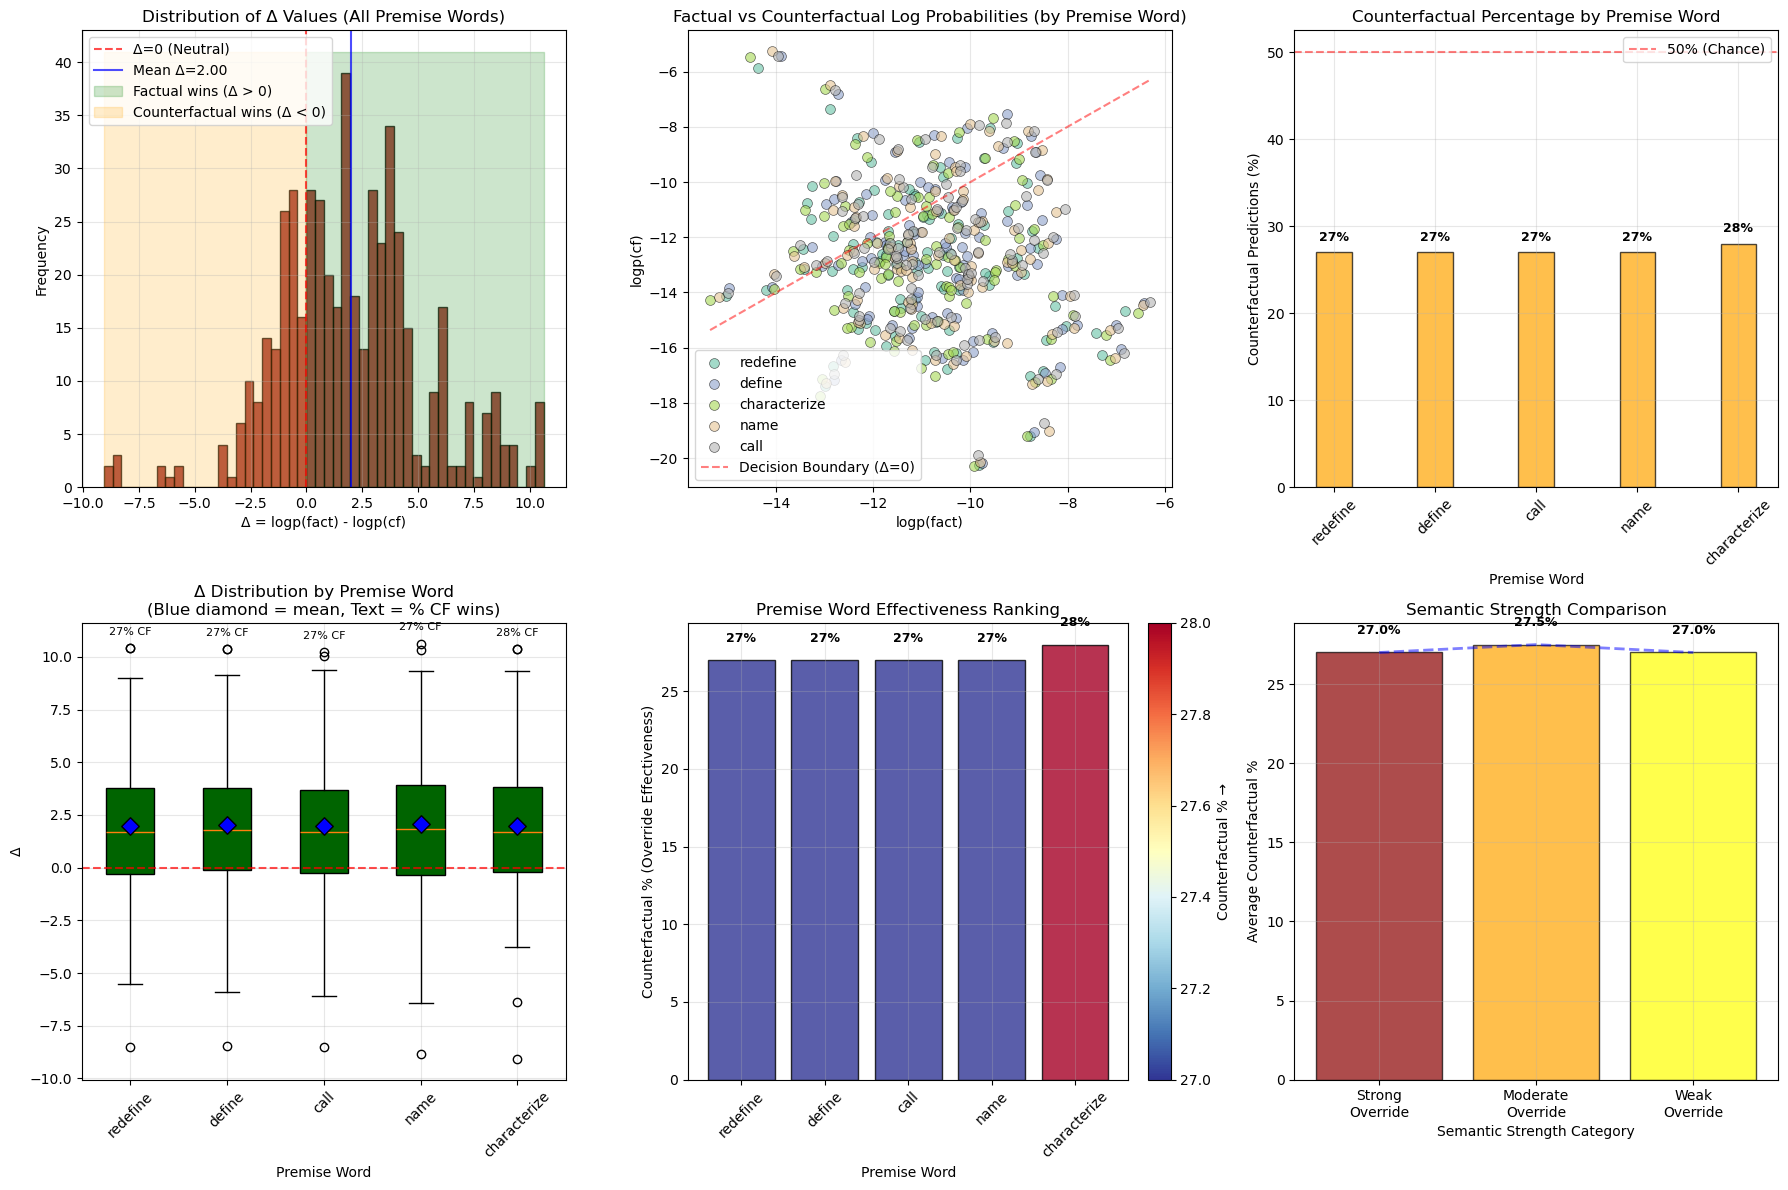


DETAILED ANALYSIS TABLE - PREMISE WORDS

Sorted by Counterfactual Percentage (descending):
                N  % Factual  % Counterfactual  Δ mean  Δ std  % Δ < 0  Effect Size               Category
characterize  100      72.00             28.00    1.99   3.36    28.00         0.59  Definitional/Override
redefine      100      73.00             27.00    1.96   3.28    27.00         0.60  Definitional/Override
define        100      73.00             27.00    2.00   3.29    27.00         0.61  Definitional/Override
call          100      73.00             27.00    1.98   3.27    27.00         0.60  Definitional/Override
name          100      73.00             27.00    2.05   3.38    27.00         0.61  Definitional/Override

SUMMARY STATISTICS

Average across all premise words:
  % Factual: 72.8%
  % Counterfactual: 27.2%
  Δ mean: 1.9969
  % Δ < 0: 27.2%

Range across premise words:
  % Counterfactual: 27.0% to 28.0%
  Δ mean: 1.9645 to 2.0533

Most effective override word: characteri

In [3]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class PremiseWordResult:
    """Stores results for a single prompt with premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class PremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Premise words to analyze (Definitional/Override category)
        self.premise_words = ['redefine', 'define', 'call', 'name', 'characterize']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'redefine': 'Definitional/Override',
            'define': 'Definitional/Override', 
            'call': 'Definitional/Override',
            'name': 'Definitional/Override',
            'characterize': 'Definitional/Override'
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            
            # For Objective II, we don't group by premise verbs from original dataset
            # We'll use all items with all premise words
            
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        
        Args:
            original_prompt: Original prompt (e.g., "Redefine: Airbus A380 was created by Adobe")
            subject: Subject of the statement (e.g., "Airbus A380")
            target_new: Counterfactual answer (e.g., "Adobe")
        
        Returns:
            Complete counterfactual statement (CF)
        """
        # For premise verbs, the prompt format is "PV: <statement>"
        # Let's extract the statement part
        if ':' in original_prompt:
            # Get everything after the first colon
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        # If extraction fails, construct a simple statement
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        
        Args:
            prompt: Input prompt
            target_tokens: List of token IDs to compute probability for
        
        Returns:
            Total log probability of the target sequence
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[PremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = PremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None, items_per_premise: Optional[int] = None):
        """Run the Premise Word experiment"""
        print(f"\n{'='*70}")
        print(f"OBJECTIVE II: EFFECT OF PREMISE WORDS - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} premise words:")
        print(f"  {', '.join(self.premise_words)}")
        print(f"Category: {self.premise_word_categories['redefine']}")
        
        # Determine how many items to process per premise word
        if items_per_premise:
            items_per_word = items_per_premise
        else:
            # If no limit, use all items for each premise word
            items_per_word = len(all_items)
        
        print(f"\nProcessing up to {items_per_word} items per premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * items_per_word}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            # Take subset of items for this premise word
            word_items = all_items[:items_per_word]
            
            for item in tqdm(word_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        self.plot_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for Premise Word experiment"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Calculate overall metrics
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        counterfactual_count = total - factual_count
        
        factual_percent = (factual_count / total) * 100
        counterfactual_percent = (counterfactual_count / total) * 100
        
        # Calculate average log probabilities and delta
        avg_factual_logp = np.mean([r.factual_logp for r in self.results])
        avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in self.results])
        avg_delta = np.mean([r.delta for r in self.results])
        
        # Calculate delta statistics
        delta_std = np.std([r.delta for r in self.results])
        delta_abs_mean = np.mean([abs(r.delta) for r in self.results])
        
        print(f"\n{'='*60}")
        print("OBJECTIVE II RESULTS - EFFECT OF PREMISE WORDS")
        print(f"{'='*60}")
        print(f"\nOverall Metrics (All Premise Words):")
        print(f"  Total prompts analyzed: {total}")
        print(f"  Factual predictions: {factual_count} ({factual_percent:.1f}%)")
        print(f"  Counterfactual predictions: {counterfactual_count} ({counterfactual_percent:.1f}%)")
        print(f"\nAverage Log Probabilities:")
        print(f"  logp(fact): {avg_factual_logp:.4f}")
        print(f"  logp(cf):   {avg_counterfactual_logp:.4f}")
        print(f"  Δ:          {avg_delta:.4f} (logp(fact) - logp(cf))")
        print(f"\nΔ Statistics:")
        print(f"  Δ std dev:  {delta_std:.4f}")
        print(f"  |Δ| mean:   {delta_abs_mean:.4f}")
        
        # Expected behavior analysis
        print(f"\n{'='*60}")
        print("EXPECTED BEHAVIOR ANALYSIS")
        print(f"{'='*60}")
        print("\nFor Definitional/Override premise words, we expect:")
        print("  - These words may bias the model toward accepting the provided text")
        print("  - Higher counterfactual percentage might indicate override effect")
        print("  - Words like 'redefine' might strongly override factual knowledge")
        print("  - Words like 'define' might have moderate override effect")
        print("  - Words like 'name' or 'call' might have weaker override effect")
        
        # Count how many follow each pattern
        positive_delta_count = sum(1 for r in self.results if r.delta > 0)
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        positive_delta_percent = (positive_delta_count / total) * 100
        negative_delta_percent = (negative_delta_count / total) * 100
        
        print(f"\nOverall Pattern:")
        print(f"  Prompts with Δ > 0 (factual wins): {positive_delta_count}/{total} ({positive_delta_percent:.1f}%)")
        print(f"  Prompts with Δ < 0 (counterfactual wins): {negative_delta_count}/{total} ({negative_delta_percent:.1f}%)")
        
        # Analyze by premise word
        print(f"\n{'='*60}")
        print("ANALYSIS BY PREMISE WORD")
        print(f"{'='*60}")
        print(f"\n{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'Avg Δ':<10} {'Override Strength':<15} {'Effect Direction':<15}")
        print("-" * 85)
        
        word_stats = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                word_total = len(word_results)
                word_factual = sum(1 for r in word_results if r.prediction == "factual")
                word_factual_pct = (word_factual / word_total) * 100
                word_delta = np.mean([r.delta for r in word_results])
                word_negative_delta = sum(1 for r in word_results if r.delta < 0)
                word_override_pct = (word_negative_delta / word_total) * 100
                
                # Calculate override strength (based on negative delta percentage)
                if word_override_pct > 66:
                    override_strength = "Strong"
                elif word_override_pct > 33:
                    override_strength = "Moderate"
                else:
                    override_strength = "Weak"
                
                # Determine effect direction
                if word_delta < 0:
                    effect_direction = "Counterfactual"
                elif word_delta > 0.5:  # Strong positive delta
                    effect_direction = "Factual (strong)"
                elif word_delta > 0.1:  # Moderate positive delta
                    effect_direction = "Factual (moderate)"
                else:
                    effect_direction = "Neutral"
                
                word_stats[word] = {
                    'count': word_total,
                    'factual_pct': word_factual_pct,
                    'counterfactual_pct': 100 - word_factual_pct,
                    'avg_delta': word_delta,
                    'override_pct': word_override_pct,
                    'override_strength': override_strength,
                    'effect_direction': effect_direction
                }
                
                print(f"{word:<15} {word_total:<8} {word_factual_pct:<10.1f} "
                      f"{100-word_factual_pct:<10.1f} {word_delta:<10.4f} {override_strength:<15} {effect_direction:<15}")
        
        # Calculate premise word effectiveness ranking
        print(f"\n{'='*60}")
        print("PREMISE WORD EFFECTIVENESS RANKING")
        print(f"{'='*60}")
        
        # Rank by override percentage (higher = more effective at overriding)
        sorted_by_override = sorted(
            [(word, stats['override_pct']) for word, stats in word_stats.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        print(f"\nRanking by Override Effectiveness (highest to lowest):")
        for rank, (word, override_pct) in enumerate(sorted_by_override, 1):
            print(f"  {rank}. {word:<12}: {override_pct:.1f}% counterfactual wins")
        
        # Rank by Δ value (most negative = strongest override)
        sorted_by_delta = sorted(
            [(word, stats['avg_delta']) for word, stats in word_stats.items()],
            key=lambda x: x[1]
        )
        
        print(f"\nRanking by Δ Value (most negative to most positive):")
        for rank, (word, delta) in enumerate(sorted_by_delta, 1):
            direction = "counterfactual" if delta < 0 else "factual"
            print(f"  {rank}. {word:<12}: Δ = {delta:+.4f} ({direction})")
        
        # Calculate semantic grouping analysis
        strong_override_words = ['redefine', 'define']
        moderate_override_words = ['characterize', 'call']
        weak_override_words = ['name']
        
        strong_group_pct = np.mean([word_stats[w]['counterfactual_pct'] for w in strong_override_words if w in word_stats])
        moderate_group_pct = np.mean([word_stats[w]['counterfactual_pct'] for w in moderate_override_words if w in word_stats])
        weak_group_pct = np.mean([word_stats[w]['counterfactual_pct'] for w in weak_override_words if w in word_stats])
        
        print(f"\n{'='*60}")
        print("SEMANTIC GROUPING ANALYSIS")
        print(f"{'='*60}")
        print(f"\nGroup Analysis by Semantic Strength:")
        print(f"  Strong override words ({', '.join(strong_override_words)}): {strong_group_pct:.1f}% counterfactual")
        print(f"  Moderate override words ({', '.join(moderate_override_words)}): {moderate_group_pct:.1f}% counterfactual")
        print(f"  Weak override words ({', '.join(weak_override_words)}): {weak_group_pct:.1f}% counterfactual")
        
        # Calculate strength gradient
        if strong_group_pct > 0 and weak_group_pct > 0:
            strength_gradient = strong_group_pct - weak_group_pct
            print(f"  Strength gradient: {strength_gradient:+.1f}% (strong - weak)")
        
        return word_stats
    
    def plot_results(self):
        """Plot Premise Word experiment results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Plot 1: Distribution of Δ values for all premise words
        deltas = [r.delta for r in self.results]
        axes[0].hist(deltas, bins=50, alpha=0.7, color='darkred', edgecolor='black')
        axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Δ=0 (Neutral)')
        axes[0].axvline(x=np.mean(deltas), color='blue', linestyle='-', alpha=0.7, 
                       label=f'Mean Δ={np.mean(deltas):.2f}')
        
        # Shade areas for interpretation
        ymin, ymax = axes[0].get_ylim()
        axes[0].fill_betweenx([ymin, ymax], 0, max(deltas), alpha=0.2, color='green', 
                            label='Factual wins (Δ > 0)')
        axes[0].fill_betweenx([ymin, ymax], min(deltas), 0, alpha=0.2, color='orange', 
                            label='Counterfactual wins (Δ < 0)')
        
        axes[0].set_xlabel('Δ = logp(fact) - logp(cf)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of Δ Values (All Premise Words)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Scatter plot of logp(fact) vs logp(cf) colored by premise word
        factual_logps = [r.factual_logp for r in self.results]
        counterfactual_logps = [r.counterfactual_logp for r in self.results]
        
        # Color points by premise word
        unique_words = list(set([r.premise_word for r in self.results]))
        colors = plt.cm.Set2(np.linspace(0, 1, len(unique_words)))
        word_to_color = {word: colors[i] for i, word in enumerate(unique_words)}
        
        for word in unique_words:
            word_results = [r for r in self.results if r.premise_word == word]
            word_factual = [r.factual_logp for r in word_results]
            word_counterfactual = [r.counterfactual_logp for r in word_results]
            
            axes[1].scatter(word_factual, word_counterfactual, 
                           color=word_to_color[word], alpha=0.6, 
                           edgecolors='black', linewidth=0.5, label=word, s=50)
        
        axes[1].plot([min(factual_logps), max(factual_logps)], 
                    [min(factual_logps), max(factual_logps)], 
                    'r--', alpha=0.5, label='Decision Boundary (Δ=0)')
        
        axes[1].set_xlabel('logp(fact)')
        axes[1].set_ylabel('logp(cf)')
        axes[1].set_title('Factual vs Counterfactual Log Probabilities (by Premise Word)')
        axes[1].legend(loc='best')
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Counterfactual percentage by premise word
        word_data = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                word_total = len(word_results)
                word_counterfactual = sum(1 for r in word_results if r.prediction == "counterfactual")
                word_data[word] = {
                    'counterfactual': word_counterfactual,
                    'factual': word_total - word_counterfactual,
                    'counterfactual_pct': (word_counterfactual / word_total) * 100
                }
        
        if word_data:
            x = np.arange(len(word_data))
            width = 0.35
            
            counterfactual_pct = [word_data[word]['counterfactual_pct'] for word in word_data.keys()]
            
            bars = axes[2].bar(x, counterfactual_pct, width, color='orange', alpha=0.7, edgecolor='black')
            axes[2].set_xlabel('Premise Word')
            axes[2].set_ylabel('Counterfactual Predictions (%)')
            axes[2].set_title('Counterfactual Percentage by Premise Word')
            axes[2].set_xticks(x)
            axes[2].set_xticklabels(word_data.keys(), rotation=45)
            axes[2].grid(True, alpha=0.3)
            axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
            
            # Add percentage labels
            for bar, percentage in zip(bars, counterfactual_pct):
                height = bar.get_height()
                axes[2].text(bar.get_x() + bar.get_width()/2, height + 1, 
                            f'{percentage:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            axes[2].legend()
        
        # Plot 4: Δ distribution by premise word (box plot)
        word_deltas = {}
        word_means = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                deltas_list = [r.delta for r in word_results]
                word_deltas[word] = deltas_list
                word_means[word] = np.mean(deltas_list)
        
        if word_deltas:
            positions = range(1, len(word_deltas) + 1)
            
            # Boxplot
            bp = axes[3].boxplot(word_deltas.values(), positions=positions, patch_artist=True)
            
            # Color boxes based on mean Δ
            for i, (word, patch) in enumerate(zip(word_deltas.keys(), bp['boxes'])):
                mean_val = word_means[word]
                
                # Color gradient from orange (negative) to green (positive)
                if mean_val < -1:
                    color = 'darkorange'
                elif mean_val < 0:
                    color = 'orange'
                elif mean_val < 1:
                    color = 'lightgreen'
                else:
                    color = 'darkgreen'
                
                patch.set_facecolor(color)
                
                # Add mean as a diamond
                axes[3].scatter(positions[i], mean_val, color='blue', s=80, zorder=3, 
                               marker='D', edgecolor='black')
                
                # Add counterfactual win percentage
                counterfactual_wins = sum(1 for d in word_deltas[word] if d < 0)
                cf_win_pct = (counterfactual_wins / len(word_deltas[word])) * 100
                axes[3].text(positions[i], np.max(word_deltas[word]) * 1.05,
                            f'{cf_win_pct:.0f}% CF', ha='center', va='bottom', fontsize=8)
            
            axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[3].set_xticks(positions)
            axes[3].set_xticklabels(word_deltas.keys(), rotation=45)
            axes[3].set_xlabel('Premise Word')
            axes[3].set_ylabel('Δ')
            axes[3].set_title('Δ Distribution by Premise Word\n(Blue diamond = mean, Text = % CF wins)')
            axes[3].grid(True, alpha=0.3)
        
        # Plot 5: Premise word effectiveness comparison
        if word_data:
            effectiveness_data = []
            for word in self.premise_words:
                if word in word_data:
                    effectiveness_data.append({
                        'word': word,
                        'counterfactual_pct': word_data[word]['counterfactual_pct'],
                        'category': self.premise_word_categories.get(word, 'Unknown')
                    })
            
            if effectiveness_data:
                x = np.arange(len(effectiveness_data))
                values = [d['counterfactual_pct'] for d in effectiveness_data]
                words = [d['word'] for d in effectiveness_data]
                
                # Color by value (gradient)
                norm = plt.Normalize(min(values), max(values))
                colors = plt.cm.RdYlBu_r(norm(values))
                
                bars = axes[4].bar(x, values, color=colors, alpha=0.8, edgecolor='black')
                axes[4].set_xlabel('Premise Word')
                axes[4].set_ylabel('Counterfactual % (Override Effectiveness)')
                axes[4].set_title('Premise Word Effectiveness Ranking')
                axes[4].set_xticks(x)
                axes[4].set_xticklabels(words, rotation=45)
                axes[4].grid(True, alpha=0.3)
                
                # Add value labels
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    axes[4].text(bar.get_x() + bar.get_width()/2, height + 1, 
                                f'{value:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
                
                # Add colorbar
                sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=axes[4], orientation='vertical', fraction=0.05, pad=0.04)
                cbar.set_label('Counterfactual % →')
        
        # Plot 6: Semantic strength comparison
        strong_words = ['redefine', 'define']
        moderate_words = ['characterize', 'call']
        weak_words = ['name']
        
        strong_values = []
        moderate_values = []
        weak_values = []
        
        for word in strong_words:
            if word in word_data:
                strong_values.append(word_data[word]['counterfactual_pct'])
        
        for word in moderate_words:
            if word in word_data:
                moderate_values.append(word_data[word]['counterfactual_pct'])
        
        for word in weak_words:
            if word in word_data:
                weak_values.append(word_data[word]['counterfactual_pct'])
        
        if strong_values or moderate_values or weak_values:
            categories = []
            values = []
            colors = []
            
            if strong_values:
                categories.append('Strong\nOverride')
                values.append(np.mean(strong_values))
                colors.append('darkred')
            
            if moderate_values:
                categories.append('Moderate\nOverride')
                values.append(np.mean(moderate_values))
                colors.append('orange')
            
            if weak_values:
                categories.append('Weak\nOverride')
                values.append(np.mean(weak_values))
                colors.append('yellow')
            
            x = np.arange(len(categories))
            bars = axes[5].bar(x, values, color=colors, alpha=0.7, edgecolor='black')
            axes[5].set_xlabel('Semantic Strength Category')
            axes[5].set_ylabel('Average Counterfactual %')
            axes[5].set_title('Semantic Strength Comparison')
            axes[5].set_xticks(x)
            axes[5].set_xticklabels(categories)
            axes[5].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[5].text(bar.get_x() + bar.get_width()/2, height + 1, 
                            f'{value:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Add strength gradient line
            if len(values) > 1:
                axes[5].plot(x, values, 'b--', alpha=0.5, linewidth=2)
        
        plt.tight_layout()
        plt.savefig(f'objective_II_premise_words_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_detailed_analysis_table(self):
        """Create a detailed analysis table of premise word effects"""
        if not self.results:
            print("No results to analyze")
            return
        
        # Collect data by premise word
        word_data = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                word_total = len(word_results)
                word_factual = sum(1 for r in word_results if r.prediction == "factual")
                word_factual_pct = (word_factual / word_total) * 100
                word_delta = np.mean([r.delta for r in word_results])
                word_delta_std = np.std([r.delta for r in word_results])
                word_negative_delta = sum(1 for r in word_results if r.delta < 0)
                word_override_pct = (word_negative_delta / word_total) * 100
                
                # Calculate effect size
                effect_size = abs(word_delta) / word_delta_std if word_delta_std > 0 else 0
                
                word_data[word] = {
                    'N': word_total,
                    '% Factual': word_factual_pct,
                    '% Counterfactual': 100 - word_factual_pct,
                    'Δ mean': word_delta,
                    'Δ std': word_delta_std,
                    '% Δ < 0': word_override_pct,
                    'Effect Size': effect_size,
                    'Category': self.premise_word_categories.get(word, 'Unknown')
                }
        
        # Create DataFrame
        df = pd.DataFrame.from_dict(word_data, orient='index')
        
        # Sort by % Counterfactual (descending)
        df = df.sort_values('% Counterfactual', ascending=False)
        
        print(f"\n{'='*70}")
        print("DETAILED ANALYSIS TABLE - PREMISE WORDS")
        print(f"{'='*70}")
        print("\nSorted by Counterfactual Percentage (descending):")
        print(df.to_string(float_format=lambda x: f'{x:.2f}' if isinstance(x, float) else str(x)))
        
        # Calculate summary statistics
        print(f"\n{'='*70}")
        print("SUMMARY STATISTICS")
        print(f"{'='*70}")
        
        if not df.empty:
            print(f"\nAverage across all premise words:")
            print(f"  % Factual: {df['% Factual'].mean():.1f}%")
            print(f"  % Counterfactual: {df['% Counterfactual'].mean():.1f}%")
            print(f"  Δ mean: {df['Δ mean'].mean():.4f}")
            print(f"  % Δ < 0: {df['% Δ < 0'].mean():.1f}%")
            
            # Range
            print(f"\nRange across premise words:")
            print(f"  % Counterfactual: {df['% Counterfactual'].min():.1f}% to {df['% Counterfactual'].max():.1f}%")
            print(f"  Δ mean: {df['Δ mean'].min():.4f} to {df['Δ mean'].max():.4f}")
            
            # Most and least effective
            most_cf = df['% Counterfactual'].idxmax()
            least_cf = df['% Counterfactual'].idxmin()
            print(f"\nMost effective override word: {most_cf} ({df.loc[most_cf, '% Counterfactual']:.1f}% counterfactual)")
            print(f"Least effective override word: {least_cf} ({df.loc[least_cf, '% Counterfactual']:.1f}% counterfactual)")
        
        return df
    
    def compare_with_objective_I(self, 
                                baseline_path: str = "baseline_results.json",
                                both_allowed_path: str = "both_allowed_results.json"):
        """Compare Objective II results with key Objective I experiments"""
        comparisons = []
        
        try:
            # Load baseline results (Experiment 1)
            with open(baseline_path, 'r') as f:
                baseline_data = json.load(f)
            baseline_summary = baseline_data['summary']
            comparisons.append(('Baseline (Obj I)', baseline_summary))
        except FileNotFoundError:
            print(f"✗ Baseline results file not found at {baseline_path}")
        
        try:
            # Load Both Allowed results (Experiment 7)
            with open(both_allowed_path, 'r') as f:
                both_allowed_data = json.load(f)
            both_allowed_summary = both_allowed_data['summary']
            comparisons.append(('Both Allowed (Obj I)', both_allowed_summary))
        except FileNotFoundError:
            print(f"✗ Both Allowed results file not found at {both_allowed_path}")
        
        if not comparisons:
            print("No Objective I comparison data available")
            return
        
        # Calculate our summary (average across all premise words)
        premise_word_stats = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                word_total = len(word_results)
                word_factual = sum(1 for r in word_results if r.prediction == "factual")
                word_factual_pct = (word_factual / word_total) * 100
                word_delta = np.mean([r.delta for r in word_results])
                premise_word_stats[word] = {
                    'factual_pct': word_factual_pct,
                    'delta': word_delta
                }
        
        # Calculate average across all premise words
        if premise_word_stats:
            avg_factual_pct = np.mean([stats['factual_pct'] for stats in premise_word_stats.values()])
            avg_delta = np.mean([stats['delta'] for stats in premise_word_stats.values()])
            
            # Also get the most effective premise word
            most_effective_word = min(premise_word_stats.items(), key=lambda x: x[1]['factual_pct'])[0]
            most_effective_stats = premise_word_stats[most_effective_word]
            
            comparisons.append((f'Premise Words Avg (Obj II)', {
                'factual_percent': avg_factual_pct,
                'avg_delta': avg_delta
            }))
            
            comparisons.append((f'Most Effective: {most_effective_word}', {
                'factual_percent': most_effective_stats['factual_pct'],
                'avg_delta': most_effective_stats['delta']
            }))
        
        print(f"\n{'='*80}")
        print("COMPARISON: OBJECTIVE I vs OBJECTIVE II")
        print(f"{'='*80}")
        print(f"\n{'Experiment':<30} {'% Factual':<12} {'% Counterfactual':<17} {'Avg Δ':<12}")
        print("-" * 80)
        
        for exp_name, summary in comparisons:
            factual_pct = summary.get('factual_percent', 0)
            counterfactual_pct = 100 - factual_pct
            avg_delta = summary.get('avg_delta', 0)
            
            print(f"{exp_name:<30} {factual_pct:<12.1f} {counterfactual_pct:<17.1f} {avg_delta:<12.4f}")
        
        print(f"\nInterpretation:")
        print(f"- Objective I: Effect of Meta Prompts (instructional framing)")
        print(f"- Objective II: Effect of Premise Words (semantic priming)")
        print(f"\nKey Questions:")
        print(f"1. Do premise words override factual knowledge more than baseline?")
        print(f"2. How do premise words compare to 'Both Allowed' natural competition?")
        print(f"3. Which premise words are most effective at biasing toward counterfactual?")
        
        # Calculate effectiveness metrics
        if 'Baseline (Obj I)' in [name for name, _ in comparisons] and 'Premise Words Avg (Obj II)' in [name for name, _ in comparisons]:
            baseline_idx = [name for name, _ in comparisons].index('Baseline (Obj I)')
            premise_avg_idx = [name for name, _ in comparisons].index('Premise Words Avg (Obj II)')
            
            baseline_factual = comparisons[baseline_idx][1].get('factual_percent', 0)
            premise_avg_factual = comparisons[premise_avg_idx][1].get('factual_percent', 0)
            
            factual_change = premise_avg_factual - baseline_factual
            
            print(f"\nEffectiveness Analysis:")
            print(f"  Baseline factual %: {baseline_factual:.1f}%")
            print(f"  Premise words avg factual %: {premise_avg_factual:.1f}%")
            print(f"  Change: {factual_change:+.1f}%")
            
            if factual_change < -10:
                print(f"  Conclusion: Premise words STRONGLY override factual knowledge")
            elif factual_change < -5:
                print(f"  Conclusion: Premise words MODERATELY override factual knowledge")
            elif factual_change < 0:
                print(f"  Conclusion: Premise words WEAKLY override factual knowledge")
            else:
                print(f"  Conclusion: Premise words DO NOT override factual knowledge")
    
    def save_results(self, output_path: str = "premise_words_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_word': result.premise_word,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise word
        word_summary = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                word_total = len(word_results)
                word_factual = sum(1 for r in word_results if r.prediction == "factual")
                word_factual_pct = (word_factual / word_total) * 100
                word_delta = np.mean([r.delta for r in word_results])
                word_delta_std = np.std([r.delta for r in word_results])
                word_negative_delta = sum(1 for r in word_results if r.delta < 0)
                word_override_pct = (word_negative_delta / word_total) * 100
                
                word_summary[word] = {
                    'count': word_total,
                    'factual_percent': word_factual_pct,
                    'counterfactual_percent': 100 - word_factual_pct,
                    'avg_delta': word_delta,
                    'delta_std': word_delta_std,
                    'override_percent': word_override_pct,
                    'category': self.premise_word_categories.get(word, 'Unknown'),
                    'effect_size': abs(word_delta) / word_delta_std if word_delta_std > 0 else 0
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        negative_delta_count = sum(1 for r in self.results if r.delta < 0)
        override_percent = (negative_delta_count / total) * 100
        
        # Calculate ranking
        ranking = sorted(
            [(word, stats['counterfactual_percent']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'objective': 'II - Effect of Premise Words',
                'prompt_template': self.premise_word_template,
                'premise_words_tested': self.premise_words,
                'category': 'Definitional/Override',
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'delta_std': np.std([r.delta for r in self.results]),
                    'abs_delta_mean': np.mean([abs(r.delta) for r in self.results]),
                    'override_percent': override_percent,
                    'premise_word_ranking': ranking,
                    'most_effective_word': ranking[0][0] if ranking else None,
                    'least_effective_word': ranking[-1][0] if ranking else None
                },
                'premise_word_summary': word_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Example usage
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 10000  # Total items to use from dataset
    ITEMS_PER_PREMISE = 100  # Items to test per premise word
    
    # Run Objective II Experiment
    experiment = PremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    results = experiment.run_experiment(
        sample_size=SAMPLE_SIZE, 
        items_per_premise=ITEMS_PER_PREMISE
    )
    
    # Create detailed analysis table
    experiment.create_detailed_analysis_table()
    
    # Save detailed results
    experiment.save_results()
    
    # Compare with Objective I experiments (if available)
    experiment.compare_with_objective_I(
        "baseline_results.json",
        "both_allowed_results.json"
    )
    
    # Print example prompts and results
    if results:
        print("\n📋 Example Prompts and Results (first 3 per premise word):")
        print("=" * 100)
        
        for word in experiment.premise_words[:3]:  # Show first 3 premise words
            word_results = [r for r in results if r.premise_word == word][:3]
            
            print(f"\n{'='*50}")
            print(f"Premise Word: {word.upper()}")
            print(f"{'='*50}")
            
            for i, result in enumerate(word_results):
                print(f"\nExample {i+1} for '{word}':")
                print(f"  Subject: {result.subject}")
                print(f"  Question: {result.question}")
                print(f"  Counterfactual Statement (CF): '{result.counterfactual_statement}'")
                print(f"  Factual answer: '{result.factual_answer}'")
                print(f"  Counterfactual answer: '{result.counterfactual_answer}'")
                print(f"  Prompt used:")
                # Show first 120 characters of prompt
                prompt_preview = result.prompt[:120] + "..." if len(result.prompt) > 120 else result.prompt
                print(f"    {prompt_preview}")
                print(f"  Prediction: {result.prediction}")
                print(f"  logp(fact): {result.factual_logp:.4f}")
                print(f"  logp(cf): {result.counterfactual_logp:.4f}")
                print(f"  Δ: {result.delta:.4f} (factual {'wins' if result.delta > 0 else 'loses'})")
                print(f"  {'-'*40}")

OBJECTIVE II: EFFECT OF PREMISE WORDS
Testing premise words: redefine, define, call, name, characterize
Model: gpt2-small
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000

OBJECTIVE II: EFFECT OF PREMISE WORDS - GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 premise words:
  1. redefine
  2. define
  3. call
  4. name
  5. characterize

Processing 1000 items for each premise word...
Total expected prompts: 5000


Premise words: 100%|██████████| 5/5 [02:58<00:00, 35.69s/it]


✓ Processed 5000 prompts successfully

OBJECTIVE II: DETAILED METRICS FOR ALL PREMISE WORDS

Format for each premise word:
  logp(fact): average log probability of factual answer
  logp(cf):   average log probability of counterfactual answer
  Δ:          logp(fact) - logp(cf)

Premise Word    Count    %Factual   %CF        logp(fact)      logp(cf)        Δ               Std Δ          
                                               (mean±std)      (mean±std)      (mean±std)                     
------------------------------------------------------------------------------------------------------------------------
redefine        1000     71.8       28.2       -11.0352±1.6180  -12.7808±2.3527   1.7456±3.0919 
define          1000     72.4       27.6       -10.7229±1.6409  -12.5084±2.4126   1.7855±3.1178 
call            1000     71.6       28.4       -10.7261±1.6619  -12.4503±2.4415   1.7241±3.1069 
name            1000     71.4       28.6       -10.7895±1.6833  -12.5510±2.5147   1.761

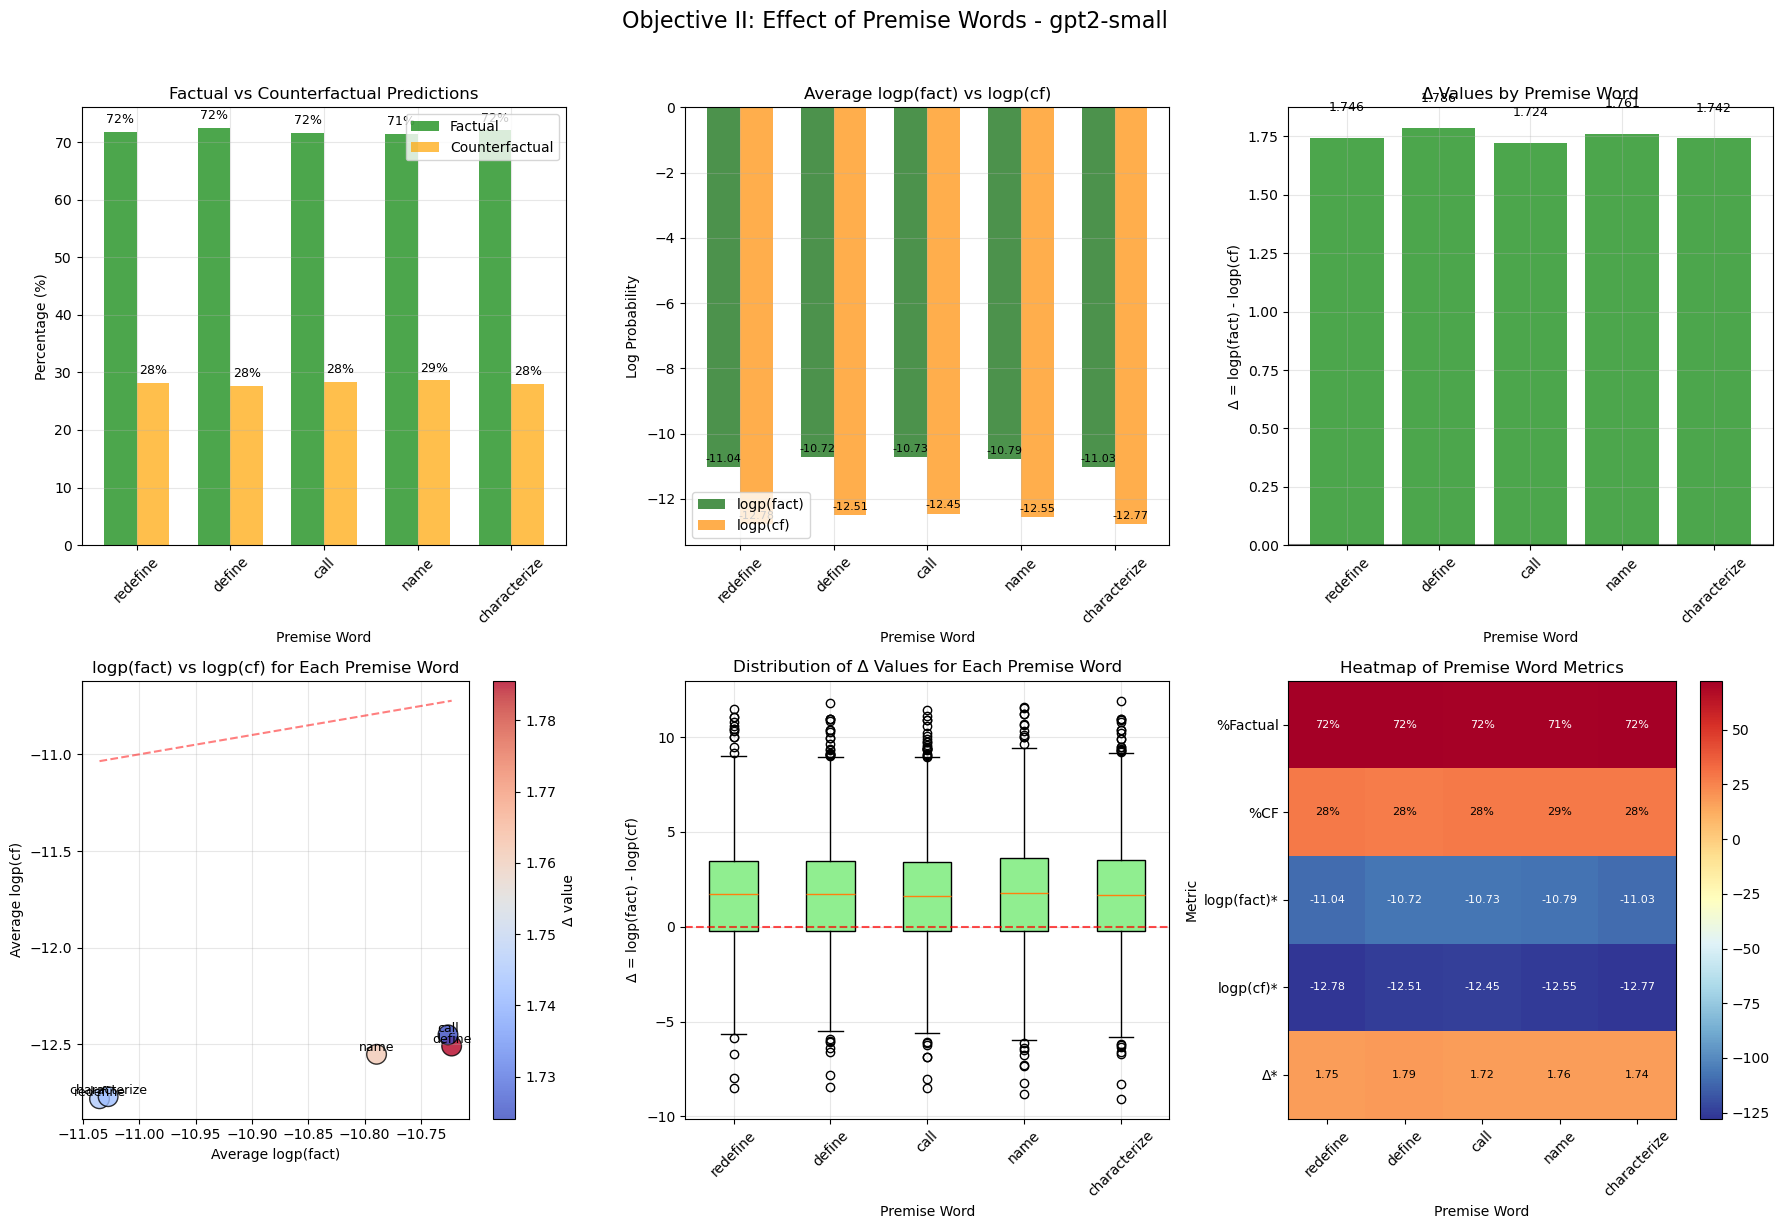


DETAILED EXAMPLES FOR EACH PREMISE WORD

PREMIZE WORD: REDEFINE

Example 1:
  Subject: Sarvepalli Radhakrishnan
  Question: What country does Sarvepalli Radhakrishnan have citizenship from?
  Counterfactual Statement: 'Sarvepalli Radhakrishnan, who has a citizenship from Russia. Sarvepalli Radhakrishnan, who has a citizenship from'
  Factual Answer: ' India'
  Counterfactual Answer: ' Russia'
  Prediction: factual (Δ > 0)
  Metrics:
    logp(fact): -10.488905
    logp(cf):   -13.209332
    Δ:          2.720427 (logp(fact) - logp(cf))
  Prompt (first 150 chars):
    Answer the following question.
Instruction: redefine
Text: "Sarvepalli Radhakrishnan, who has a citizenship from Russia. Sarvepalli Radhakrishnan, who...
  ----------------------------------------

Example 2:
  Subject: Ethiopia
  Question: What continent does Ethiopia belong to?
  Counterfactual Statement: 'Ethiopia belongs to the continent of Antarctica. Ethiopia belongs to the continent of'
  Factual Answer: ' Africa'
  

In [5]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class PremiseWordResult:
    """Stores results for a single prompt with premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class PremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # All premise words to analyze (Definitional/Override category)
        self.premise_words = ['redefine', 'define', 'call', 'name', 'characterize']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'redefine': 'Definitional/Override',
            'define': 'Definitional/Override', 
            'call': 'Definitional/Override',
            'name': 'Definitional/Override',
            'characterize': 'Definitional/Override'
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        if ':' in original_prompt:
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[PremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = PremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Premise Word experiment"""
        print(f"\n{'='*70}")
        print(f"OBJECTIVE II: EFFECT OF PREMISE WORDS - {self.model_name.upper()}")
        print(f"{'='*70}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} premise words:")
        for i, word in enumerate(self.premise_words, 1):
            print(f"  {i}. {word}")
        
        print(f"\nProcessing {len(all_items)} items for each premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * len(all_items)}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            for item in tqdm(all_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for all premise words with detailed metrics"""
        if not self.results:
            print("No results to analyze")
            return
        
        print(f"\n{'='*80}")
        print("OBJECTIVE II: DETAILED METRICS FOR ALL PREMISE WORDS")
        print(f"{'='*80}")
        print("\nFormat for each premise word:")
        print("  logp(fact): average log probability of factual answer")
        print("  logp(cf):   average log probability of counterfactual answer")
        print("  Δ:          logp(fact) - logp(cf)")
        
        # Dictionary to store aggregated results by premise word
        word_metrics = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                # Calculate metrics
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                counterfactual_pct = 100 - factual_pct
                
                # Calculate average log probabilities
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                
                # Calculate standard deviations
                std_factual_logp = np.std([r.factual_logp for r in word_results])
                std_counterfactual_logp = np.std([r.counterfactual_logp for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                # Store metrics
                word_metrics[word] = {
                    'count': total,
                    'factual_pct': factual_pct,
                    'counterfactual_pct': counterfactual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_factual_logp': std_factual_logp,
                    'std_counterfactual_logp': std_counterfactual_logp,
                    'std_delta': std_delta,
                    'median_factual_logp': np.median([r.factual_logp for r in word_results]),
                    'median_counterfactual_logp': np.median([r.counterfactual_logp for r in word_results]),
                    'median_delta': np.median([r.delta for r in word_results])
                }
        
        # Print detailed table for all premise words
        print(f"\n{'='*120}")
        print(f"{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'logp(fact)':<15} {'logp(cf)':<15} {'Δ':<15} {'Std Δ':<15}")
        print(f"{'':<15} {'':<8} {'':<10} {'':<10} {'(mean±std)':<15} {'(mean±std)':<15} {'(mean±std)':<15} {'':<15}")
        print("-" * 120)
        
        for word, metrics in word_metrics.items():
            print(f"{word:<15} {metrics['count']:<8} {metrics['factual_pct']:<10.1f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['avg_factual_logp']:7.4f}±{metrics['std_factual_logp']:<7.4f} "
                  f"{metrics['avg_counterfactual_logp']:7.4f}±{metrics['std_counterfactual_logp']:<7.4f} "
                  f"{metrics['avg_delta']:7.4f}±{metrics['std_delta']:<7.4f}")
        
        # Print individual premise word summaries
        print(f"\n{'='*80}")
        print("INDIVIDUAL PREMISE WORD SUMMARIES")
        print(f"{'='*80}")
        
        for word, metrics in word_metrics.items():
            print(f"\n{'='*60}")
            print(f"PREMIZE WORD: {word.upper()}")
            print(f"{'='*60}")
            print(f"  Number of prompts analyzed: {metrics['count']}")
            print(f"  Factual predictions: {metrics['factual_pct']:.1f}%")
            print(f"  Counterfactual predictions: {metrics['counterfactual_pct']:.1f}%")
            print(f"\n  Average Log Probabilities:")
            print(f"    logp(fact): {metrics['avg_factual_logp']:.4f} (std: {metrics['std_factual_logp']:.4f})")
            print(f"    logp(cf):   {metrics['avg_counterfactual_logp']:.4f} (std: {metrics['std_counterfactual_logp']:.4f})")
            print(f"    Δ:          {metrics['avg_delta']:.4f} (std: {metrics['std_delta']:.4f})")
            print(f"\n  Median Values:")
            print(f"    logp(fact): {metrics['median_factual_logp']:.4f}")
            print(f"    logp(cf):   {metrics['median_counterfactual_logp']:.4f}")
            print(f"    Δ:          {metrics['median_delta']:.4f}")
            
            # Interpretation
            if metrics['avg_delta'] > 0.5:
                interpretation = "STRONG factual bias"
            elif metrics['avg_delta'] > 0.1:
                interpretation = "Moderate factual bias"
            elif metrics['avg_delta'] > -0.1:
                interpretation = "Balanced/neutral"
            elif metrics['avg_delta'] > -0.5:
                interpretation = "Moderate counterfactual bias"
            else:
                interpretation = "STRONG counterfactual bias"
            
            print(f"\n  Interpretation: {interpretation}")
        
        # Summary statistics across all premise words
        print(f"\n{'='*80}")
        print("SUMMARY ACROSS ALL PREMISE WORDS")
        print(f"{'='*80}")
        
        # Calculate averages across all premise words
        avg_factual_logp_all = np.mean([m['avg_factual_logp'] for m in word_metrics.values()])
        avg_counterfactual_logp_all = np.mean([m['avg_counterfactual_logp'] for m in word_metrics.values()])
        avg_delta_all = np.mean([m['avg_delta'] for m in word_metrics.values()])
        avg_factual_pct_all = np.mean([m['factual_pct'] for m in word_metrics.values()])
        
        print(f"\n  Average across all {len(word_metrics)} premise words:")
        print(f"    logp(fact): {avg_factual_logp_all:.4f}")
        print(f"    logp(cf):   {avg_counterfactual_logp_all:.4f}")
        print(f"    Δ:          {avg_delta_all:.4f}")
        print(f"    % Factual:  {avg_factual_pct_all:.1f}%")
        
        # Ranking by Δ value (most negative to most positive)
        print(f"\n{'='*80}")
        print("RANKING BY Δ VALUE (logp(fact) - logp(cf))")
        print(f"{'='*80}")
        
        sorted_by_delta = sorted(word_metrics.items(), key=lambda x: x[1]['avg_delta'])
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Δ':<15} {'logp(fact)':<15} {'logp(cf)':<15} {'%Factual':<10}")
        print("-" * 80)
        
        for rank, (word, metrics) in enumerate(sorted_by_delta, 1):
            print(f"{rank:<6} {word:<15} {metrics['avg_delta']:<15.4f} "
                  f"{metrics['avg_factual_logp']:<15.4f} "
                  f"{metrics['avg_counterfactual_logp']:<15.4f} "
                  f"{metrics['factual_pct']:<10.1f}")
        
        # Print interpretation of ranking
        print(f"\nInterpretation of Δ ranking:")
        print(f"  1. Negative Δ values indicate counterfactual answers are more likely")
        print(f"  2. Positive Δ values indicate factual answers are more likely")
        print(f"  3. Δ close to 0 indicates balanced probability between factual and counterfactual")
        
        # Create visualizations
        self.plot_results(word_metrics)
        
        return word_metrics
    
    def plot_results(self, word_metrics):
        """Create visualizations of premise word results"""
        if not word_metrics:
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Prepare data for plots
        words = list(word_metrics.keys())
        factual_pcts = [word_metrics[w]['factual_pct'] for w in words]
        counterfactual_pcts = [word_metrics[w]['counterfactual_pct'] for w in words]
        avg_factual_logps = [word_metrics[w]['avg_factual_logp'] for w in words]
        avg_counterfactual_logps = [word_metrics[w]['avg_counterfactual_logp'] for w in words]
        avg_deltas = [word_metrics[w]['avg_delta'] for w in words]
        
        # Plot 1: Factual vs Counterfactual percentages
        x = np.arange(len(words))
        width = 0.35
        
        axes[0].bar(x - width/2, factual_pcts, width, label='Factual', color='green', alpha=0.7)
        axes[0].bar(x + width/2, counterfactual_pcts, width, label='Counterfactual', color='orange', alpha=0.7)
        axes[0].set_xlabel('Premise Word')
        axes[0].set_ylabel('Percentage (%)')
        axes[0].set_title('Factual vs Counterfactual Predictions')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(words, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Add percentage labels
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            axes[0].text(i - width/2, fact + 1, f'{fact:.0f}%', ha='center', va='bottom', fontsize=9)
            axes[0].text(i + width/2, cf + 1, f'{cf:.0f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: logp(fact) and logp(cf) comparison
        x = np.arange(len(words))
        
        axes[1].bar(x - width/2, avg_factual_logps, width, label='logp(fact)', color='darkgreen', alpha=0.7)
        axes[1].bar(x + width/2, avg_counterfactual_logps, width, label='logp(cf)', color='darkorange', alpha=0.7)
        axes[1].set_xlabel('Premise Word')
        axes[1].set_ylabel('Log Probability')
        axes[1].set_title('Average logp(fact) vs logp(cf)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(words, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (fact_logp, cf_logp) in enumerate(zip(avg_factual_logps, avg_counterfactual_logps)):
            axes[1].text(i - width/2, fact_logp + 0.1, f'{fact_logp:.2f}', ha='center', va='bottom', fontsize=8)
            axes[1].text(i + width/2, cf_logp + 0.1, f'{cf_logp:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Δ values
        colors = ['red' if d < 0 else 'green' for d in avg_deltas]
        bars = axes[2].bar(words, avg_deltas, color=colors, alpha=0.7)
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[2].set_xlabel('Premise Word')
        axes[2].set_ylabel('Δ = logp(fact) - logp(cf)')
        axes[2].set_title('Δ Values by Premise Word')
        axes[2].set_xticklabels(words, rotation=45)
        axes[2].grid(True, alpha=0.3)
        
        # Add Δ value labels
        for bar, delta in zip(bars, avg_deltas):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
                        f'{delta:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        # Plot 4: Scatter plot of logp(fact) vs logp(cf)
        scatter = axes[3].scatter(avg_factual_logps, avg_counterfactual_logps, 
                                  c=avg_deltas, cmap='coolwarm', s=200, alpha=0.8, edgecolors='black')
        axes[3].plot([min(avg_factual_logps), max(avg_factual_logps)], 
                    [min(avg_factual_logps), max(avg_factual_logps)], 
                    'r--', alpha=0.5, label='y=x (Δ=0)')
        axes[3].set_xlabel('Average logp(fact)')
        axes[3].set_ylabel('Average logp(cf)')
        axes[3].set_title('logp(fact) vs logp(cf) for Each Premise Word')
        axes[3].grid(True, alpha=0.3)
        
        # Add premise word labels to points
        for i, word in enumerate(words):
            axes[3].text(avg_factual_logps[i], avg_counterfactual_logps[i], word, 
                        fontsize=9, ha='center', va='bottom')
        
        # Add colorbar for Δ values
        cbar = plt.colorbar(scatter, ax=axes[3])
        cbar.set_label('Δ value')
        
        # Plot 5: Distribution of Δ values across all results
        all_deltas = []
        word_labels = []
        
        for word in words:
            word_results = [r for r in self.results if r.premise_word == word]
            word_deltas = [r.delta for r in word_results]
            all_deltas.extend(word_deltas)
            word_labels.extend([word] * len(word_deltas))
        
        # Create boxplot
        box_data = []
        for word in words:
            word_results = [r for r in self.results if r.premise_word == word]
            word_deltas = [r.delta for r in word_results]
            if word_deltas:
                box_data.append(word_deltas)
        
        if box_data:
            bp = axes[4].boxplot(box_data, labels=words, patch_artist=True)
            axes[4].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Δ=0')
            axes[4].set_xlabel('Premise Word')
            axes[4].set_ylabel('Δ = logp(fact) - logp(cf)')
            axes[4].set_title('Distribution of Δ Values for Each Premise Word')
            axes[4].set_xticklabels(words, rotation=45)
            axes[4].grid(True, alpha=0.3)
            
            # Color boxes by median Δ
            for i, box in enumerate(bp['boxes']):
                median_val = np.median(box_data[i])
                box.set_facecolor('lightgreen' if median_val > 0 else 'lightcoral')
        
        # Plot 6: Heatmap of average metrics
        metrics_matrix = np.array([
            [word_metrics[w]['factual_pct'] for w in words],
            [word_metrics[w]['counterfactual_pct'] for w in words],
            [word_metrics[w]['avg_factual_logp'] * 10 for w in words],  # Scaled for visualization
            [word_metrics[w]['avg_counterfactual_logp'] * 10 for w in words],  # Scaled
            [word_metrics[w]['avg_delta'] * 10 for w in words]  # Scaled
        ])
        
        im = axes[5].imshow(metrics_matrix, cmap='RdYlBu_r', aspect='auto')
        axes[5].set_xlabel('Premise Word')
        axes[5].set_ylabel('Metric')
        axes[5].set_title('Heatmap of Premise Word Metrics')
        axes[5].set_xticks(range(len(words)))
        axes[5].set_xticklabels(words, rotation=45)
        axes[5].set_yticks(range(5))
        axes[5].set_yticklabels(['%Factual', '%CF', 'logp(fact)*', 'logp(cf)*', 'Δ*'])
        
        # Add text annotations
        for i in range(5):
            for j in range(len(words)):
                if i == 0 or i == 1:  # Percentage metrics
                    text = f'{metrics_matrix[i, j]:.0f}%'
                else:  # Log probability metrics (scaled)
                    text = f'{metrics_matrix[i, j]/10:.2f}'
                axes[5].text(j, i, text, ha='center', va='center', 
                           color='black' if abs(metrics_matrix[i, j]) < 50 else 'white',
                           fontsize=8)
        
        plt.colorbar(im, ax=axes[5])
        
        plt.suptitle(f'Objective II: Effect of Premise Words - {self.model_name}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_premise_words_detailed_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_detailed_examples(self, examples_per_word: int = 3):
        """Print detailed examples for each premise word"""
        if not self.results:
            print("No results to display")
            return
        
        print(f"\n{'='*100}")
        print("DETAILED EXAMPLES FOR EACH PREMISE WORD")
        print(f"{'='*100}")
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if not word_results:
                print(f"\nNo results for premise word: {word}")
                continue
            
            print(f"\n{'='*50}")
            print(f"PREMIZE WORD: {word.upper()}")
            print(f"{'='*50}")
            
            # Take first N examples
            for i, result in enumerate(word_results[:examples_per_word], 1):
                print(f"\nExample {i}:")
                print(f"  Subject: {result.subject}")
                print(f"  Question: {result.question}")
                print(f"  Counterfactual Statement: '{result.counterfactual_statement}'")
                print(f"  Factual Answer: '{result.factual_answer}'")
                print(f"  Counterfactual Answer: '{result.counterfactual_answer}'")
                print(f"  Prediction: {result.prediction} (Δ {'>' if result.delta > 0 else '<'} 0)")
                print(f"  Metrics:")
                print(f"    logp(fact): {result.factual_logp:.6f}")
                print(f"    logp(cf):   {result.counterfactual_logp:.6f}")
                print(f"    Δ:          {result.delta:.6f} (logp(fact) - logp(cf))")
                print(f"  Prompt (first 150 chars):")
                prompt_preview = result.prompt[:150] + "..." if len(result.prompt) > 150 else result.prompt
                print(f"    {prompt_preview}")
                print(f"  {'-'*40}")
            
            # Print summary for this premise word
            total = len(word_results)
            factual_count = sum(1 for r in word_results if r.prediction == "factual")
            factual_pct = (factual_count / total) * 100
            avg_factual_logp = np.mean([r.factual_logp for r in word_results])
            avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
            avg_delta = np.mean([r.delta for r in word_results])
            
            print(f"\n  Summary for '{word}':")
            print(f"    Total examples: {total}")
            print(f"    % Factual: {factual_pct:.1f}%")
            print(f"    Average logp(fact): {avg_factual_logp:.4f}")
            print(f"    Average logp(cf):   {avg_counterfactual_logp:.4f}")
            print(f"    Average Δ:          {avg_delta:.4f}")
    
    def save_detailed_results_csv(self, output_path: str = "premise_words_detailed_results.csv"):
        """Save detailed results to CSV file"""
        if not self.results:
            print("No results to save")
            return
        
        # Prepare data for CSV
        csv_data = []
        for result in self.results:
            csv_data.append({
                'premise_word': result.premise_word,
                'subject': result.subject,
                'question': result.question,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'logp_fact': result.factual_logp,
                'logp_cf': result.counterfactual_logp,
                'delta': result.delta,
                'prediction': result.prediction,
                'prompt_preview': result.prompt[:100] + "..." if len(result.prompt) > 100 else result.prompt
            })
        
        # Create DataFrame and save to CSV
        df = pd.DataFrame(csv_data)
        df.to_csv(output_path, index=False)
        print(f"✓ Detailed results saved to {output_path}")
        
        # Also create summary CSV by premise word
        summary_data = []
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                summary_data.append({
                    'premise_word': word,
                    'total_examples': total,
                    'factual_count': factual_count,
                    'factual_percentage': factual_pct,
                    'counterfactual_percentage': 100 - factual_pct,
                    'avg_logp_fact': avg_factual_logp,
                    'avg_logp_cf': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_delta': std_delta,
                    'median_delta': np.median([r.delta for r in word_results]),
                    'min_delta': min([r.delta for r in word_results]) if word_results else 0,
                    'max_delta': max([r.delta for r in word_results]) if word_results else 0
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_csv_path = output_path.replace('.csv', '_summary.csv')
        summary_df.to_csv(summary_csv_path, index=False)
        print(f"✓ Summary results saved to {summary_csv_path}")
        
        return df, summary_df

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Number of items to process (set to None for full dataset)
    
    print(f"{'='*80}")
    print("OBJECTIVE II: EFFECT OF PREMISE WORDS")
    print(f"{'='*80}")
    print(f"Testing premise words: redefine, define, call, name, characterize")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"{'='*80}")
    
    # Create and run experiment
    experiment = PremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run the experiment
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Print detailed examples
        experiment.print_detailed_examples(examples_per_word=2)
        
        # Save results to CSV
        experiment.save_detailed_results_csv()
        
        # Final summary
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETE")
        print(f"{'='*80}")
        print(f"Total prompts processed: {len(results)}")
        print(f"Premise words tested: {', '.join(experiment.premise_words)}")
        print(f"\nFor each premise word, the following metrics were collected:")
        print("  - logp(fact): Average log probability of factual answer")
        print("  - logp(cf): Average log probability of counterfactual answer")
        print("  - Δ: logp(fact) - logp(cf)")
        print(f"\nResults saved to:")
        print("  - premise_words_detailed_results.csv (detailed per-prompt results)")
        print("  - premise_words_detailed_results_summary.csv (aggregated by premise word)")
        print("  - objective_II_premise_words_detailed_{model_name}.png (visualizations)")

OBJECTIVE II PART 2: VERIFICATION/FACT-CHECKING PREMISE WORDS
Testing premise words: verify, validate, fact check, confirm, cross-check
Model: gpt2-small
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000

OBJECTIVE II PART 2: VERIFICATION/FACT-CHECKING PREMISE WORDS
Model: GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 verification premise words:
  1. verify
  2. validate
  3. fact check
  4. confirm
  5. cross-check

Processing 1000 items for each premise word...
Total expected prompts: 5000


Premise words: 100%|██████████| 5/5 [03:02<00:00, 36.56s/it]


✓ Processed 5000 prompts successfully

VERIFICATION PREMISE WORDS: DETAILED METRICS

Format for each premise word:
  logp(fact): average log probability of factual answer
  logp(cf):   average log probability of counterfactual answer
  Δ:          logp(fact) - logp(cf)

Expected Bias: Verification words should bias toward factual answers

Premise Word    Count    %Factual   %CF        logp(fact)      logp(cf)        Δ               Factual Consist. Exp. Bias                 Match 
                                               (mean±std)      (mean±std)      (mean±std)      (% Δ>0)                                   Exp.  
----------------------------------------------------------------------------------------------------------------------------------
verify          1000     72.7       27.3       -10.7872±1.6174  -12.5727±2.4262   1.7855±3.0785  72.7            Should bias toward factual (verify truth) ✓     
validate        1000     73.0       27.0       -10.7807±1.6393  -12.5781±2.46

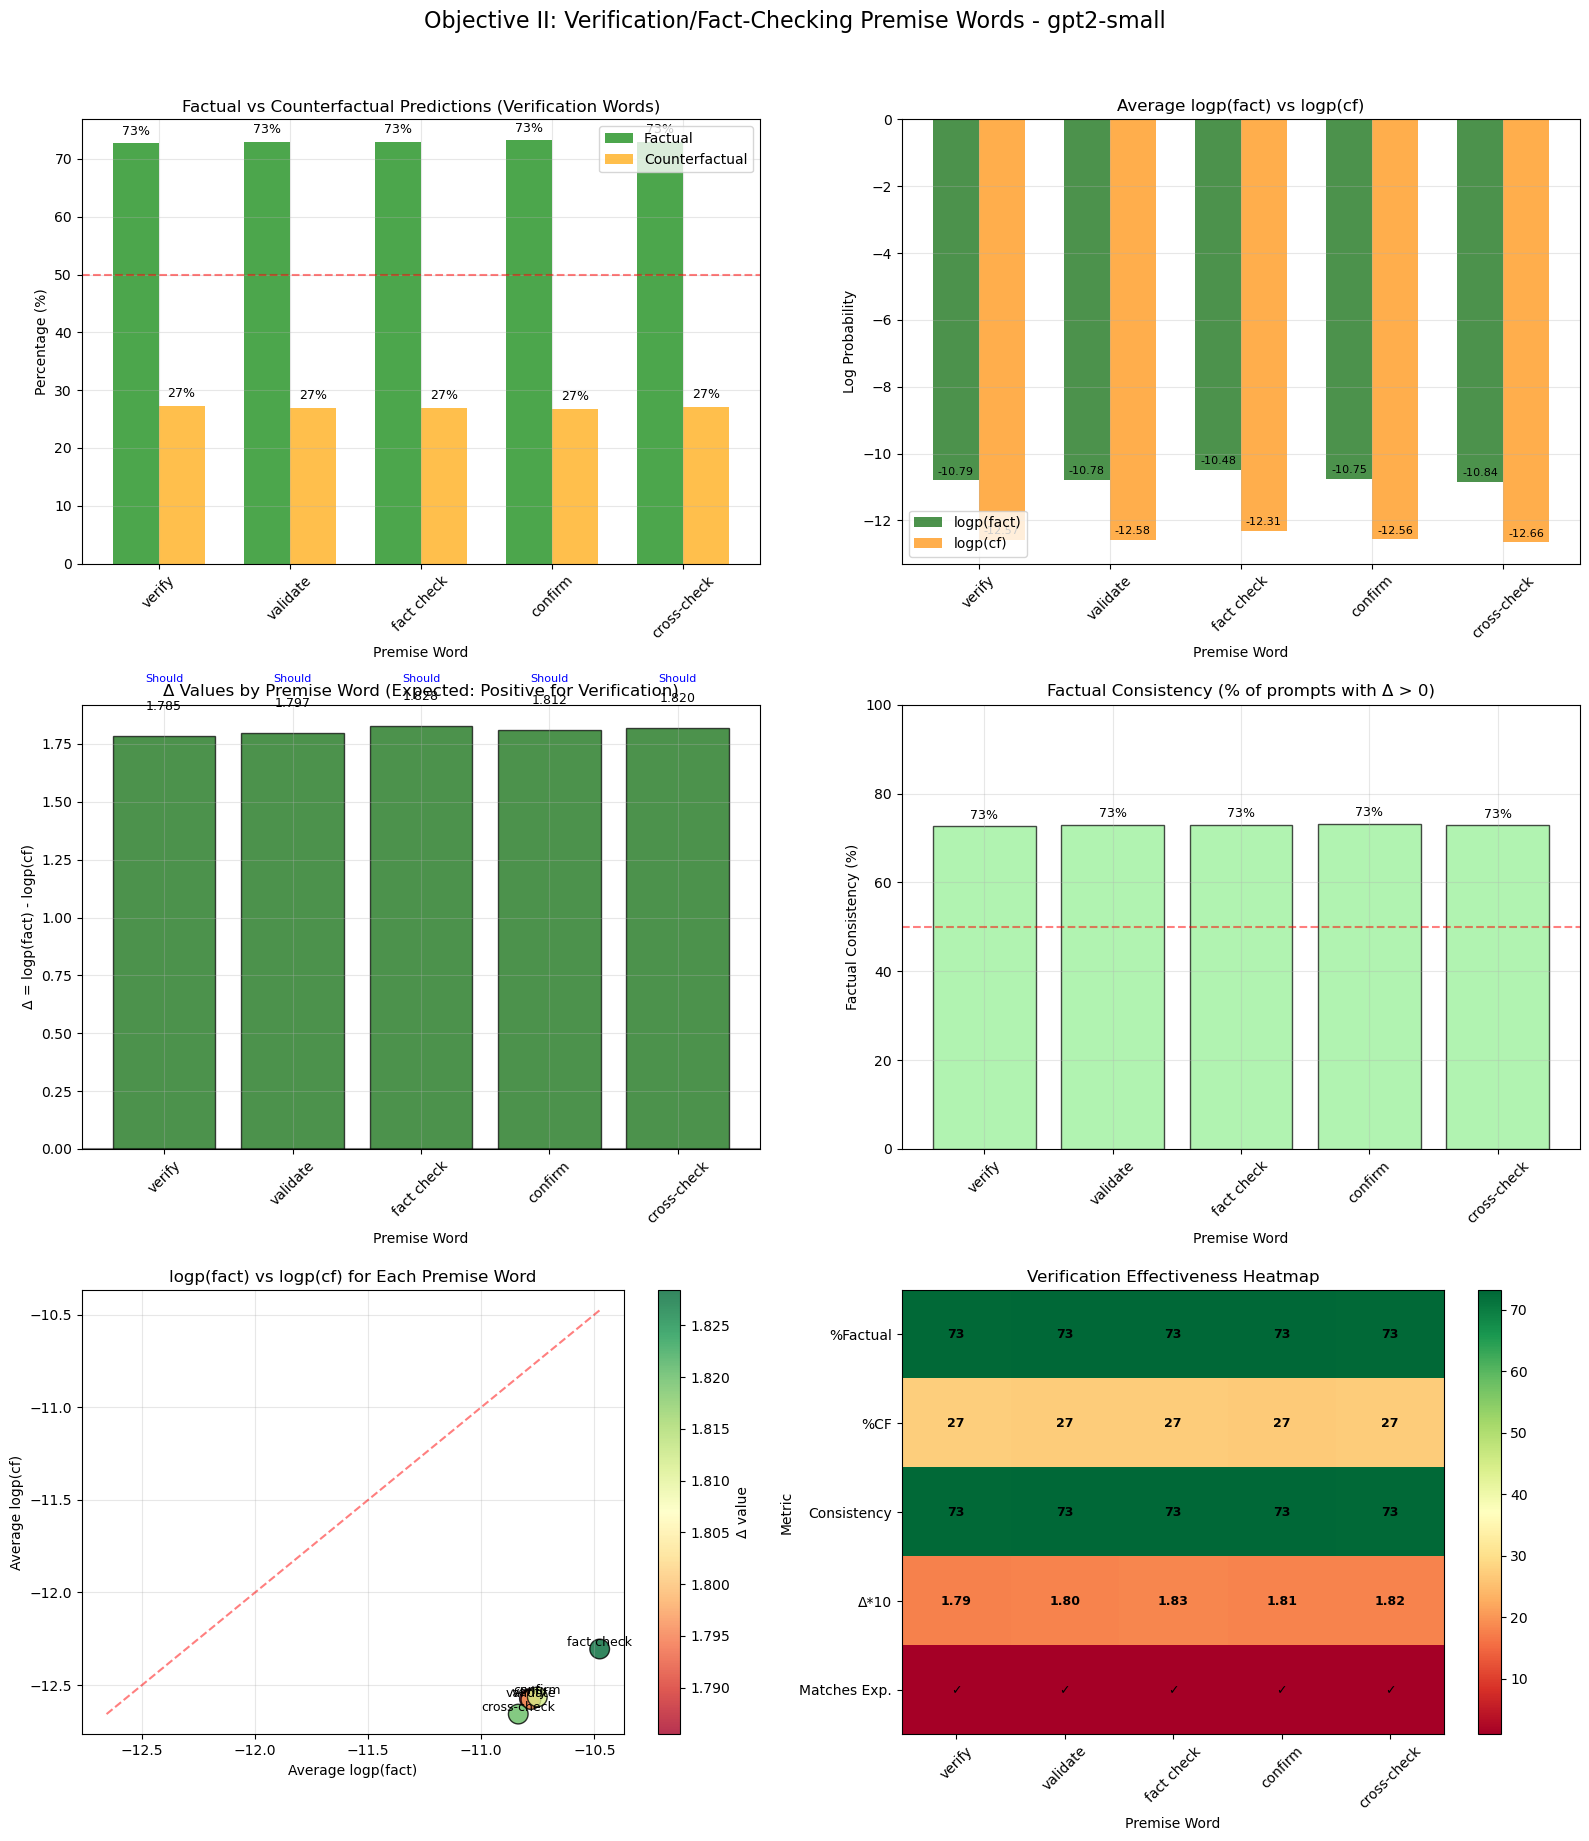

✗ Definitional results file not found at premise_words_results.json
  Run the definitional premise words experiment first for comparison

EXPERIMENT COMPLETE
Total prompts processed: 5000
Verification premise words tested: verify, validate, fact check, confirm, cross-check

Key Metrics Collected for Each Premise Word:
  - % factual: Percentage of factual predictions
  - % counterfactual: Percentage of counterfactual predictions
  - logp(fact): Average log probability of factual answer
  - logp(cf): Average log probability of counterfactual answer
  - Δ: logp(fact) - logp(cf)
  - Factual Consistency: % of prompts with Δ > 0

Expected Behavior: Verification words should bias toward factual answers (Δ > 0)

Results saved to:
  - verification_premise_words_results.json
  - objective_II_verification_words_{model_name}.png (visualizations)


In [7]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class VerificationPremiseWordResult:
    """Stores results for a single prompt with verification premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class VerificationPremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Verification/Fact-Checking premise words to analyze
        self.premise_words = ['verify', 'validate', 'fact check', 'confirm', 'cross-check']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'verify': 'Verification/Fact-Checking',
            'validate': 'Verification/Fact-Checking', 
            'fact check': 'Verification/Fact-Checking',
            'confirm': 'Verification/Fact-Checking',
            'cross-check': 'Verification/Fact-Checking'
        }
        
        # Expected bias for each word
        self.expected_bias = {
            'verify': 'Should bias toward factual (verify truth)',
            'validate': 'Should bias toward factual (validate accuracy)',
            'fact check': 'Should strongly bias toward factual (check facts)',
            'confirm': 'Should bias toward factual (confirm truth)',
            'cross-check': 'Should bias toward factual (cross-reference)'
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        if ':' in original_prompt:
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[VerificationPremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = VerificationPremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Verification Premise Word experiment"""
        print(f"\n{'='*80}")
        print(f"OBJECTIVE II PART 2: VERIFICATION/FACT-CHECKING PREMISE WORDS")
        print(f"{'='*80}")
        print(f"Model: {self.model_name.upper()}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} verification premise words:")
        for i, word in enumerate(self.premise_words, 1):
            print(f"  {i}. {word}")
        
        print(f"\nProcessing {len(all_items)} items for each premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * len(all_items)}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            for item in tqdm(all_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for all verification premise words with detailed metrics"""
        if not self.results:
            print("No results to analyze")
            return
        
        print(f"\n{'='*100}")
        print("VERIFICATION PREMISE WORDS: DETAILED METRICS")
        print(f"{'='*100}")
        print("\nFormat for each premise word:")
        print("  logp(fact): average log probability of factual answer")
        print("  logp(cf):   average log probability of counterfactual answer")
        print("  Δ:          logp(fact) - logp(cf)")
        print("\nExpected Bias: Verification words should bias toward factual answers")
        
        # Dictionary to store aggregated results by premise word
        word_metrics = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                # Calculate metrics
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                counterfactual_pct = 100 - factual_pct
                
                # Calculate average log probabilities
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                
                # Calculate standard deviations
                std_factual_logp = np.std([r.factual_logp for r in word_results])
                std_counterfactual_logp = np.std([r.counterfactual_logp for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                # Calculate additional statistics
                median_factual_logp = np.median([r.factual_logp for r in word_results])
                median_counterfactual_logp = np.median([r.counterfactual_logp for r in word_results])
                median_delta = np.median([r.delta for r in word_results])
                
                # Calculate factual win consistency (how consistently factual wins)
                factual_wins = sum(1 for r in word_results if r.delta > 0)
                factual_consistency = (factual_wins / total) * 100
                
                # Store metrics
                word_metrics[word] = {
                    'count': total,
                    'factual_pct': factual_pct,
                    'counterfactual_pct': counterfactual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_factual_logp': std_factual_logp,
                    'std_counterfactual_logp': std_counterfactual_logp,
                    'std_delta': std_delta,
                    'median_factual_logp': median_factual_logp,
                    'median_counterfactual_logp': median_counterfactual_logp,
                    'median_delta': median_delta,
                    'factual_consistency': factual_consistency,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'matches_expectation': '✓' if avg_delta > 0 else '✗'
                }
        
        # Print detailed table for all premise words
        print(f"\n{'='*130}")
        print(f"{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'logp(fact)':<15} {'logp(cf)':<15} {'Δ':<15} {'Factual Consist.':<15} {'Exp. Bias':<25} {'Match':<6}")
        print(f"{'':<15} {'':<8} {'':<10} {'':<10} {'(mean±std)':<15} {'(mean±std)':<15} {'(mean±std)':<15} {'(% Δ>0)':<15} {'':<25} {'Exp.':<6}")
        print("-" * 130)
        
        for word, metrics in word_metrics.items():
            print(f"{word:<15} {metrics['count']:<8} {metrics['factual_pct']:<10.1f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['avg_factual_logp']:7.4f}±{metrics['std_factual_logp']:<7.4f} "
                  f"{metrics['avg_counterfactual_logp']:7.4f}±{metrics['std_counterfactual_logp']:<7.4f} "
                  f"{metrics['avg_delta']:7.4f}±{metrics['std_delta']:<7.4f} "
                  f"{metrics['factual_consistency']:<15.1f} "
                  f"{self.expected_bias.get(word, 'Unknown'):<25} "
                  f"{metrics['matches_expectation']:<6}")
        
        # Print individual premise word summaries
        print(f"\n{'='*80}")
        print("INDIVIDUAL PREMISE WORD SUMMARIES")
        print(f"{'='*80}")
        
        for word, metrics in word_metrics.items():
            print(f"\n{'='*60}")
            print(f"PREMIZE WORD: {word.upper()}")
            print(f"{'='*60}")
            print(f"  Number of prompts analyzed: {metrics['count']}")
            print(f"  Factual predictions: {metrics['factual_pct']:.1f}%")
            print(f"  Counterfactual predictions: {metrics['counterfactual_pct']:.1f}%")
            print(f"\n  Average Log Probabilities:")
            print(f"    logp(fact): {metrics['avg_factual_logp']:.4f} (std: {metrics['std_factual_logp']:.4f})")
            print(f"    logp(cf):   {metrics['avg_counterfactual_logp']:.4f} (std: {metrics['std_counterfactual_logp']:.4f})")
            print(f"    Δ:          {metrics['avg_delta']:.4f} (std: {metrics['std_delta']:.4f})")
            print(f"\n  Median Values:")
            print(f"    logp(fact): {metrics['median_factual_logp']:.4f}")
            print(f"    logp(cf):   {metrics['median_counterfactual_logp']:.4f}")
            print(f"    Δ:          {metrics['median_delta']:.4f}")
            print(f"\n  Factual Consistency: {metrics['factual_consistency']:.1f}% of prompts have Δ > 0")
            print(f"  Expected Bias: {self.expected_bias.get(word, 'Unknown')}")
            print(f"  Matches Expectation: {metrics['matches_expectation']} (Expected Δ > 0)")
        
        # Summary statistics across all premise words
        print(f"\n{'='*80}")
        print("SUMMARY ACROSS ALL VERIFICATION PREMISE WORDS")
        print(f"{'='*80}")
        
        # Calculate averages across all premise words
        avg_factual_logp_all = np.mean([m['avg_factual_logp'] for m in word_metrics.values()])
        avg_counterfactual_logp_all = np.mean([m['avg_counterfactual_logp'] for m in word_metrics.values()])
        avg_delta_all = np.mean([m['avg_delta'] for m in word_metrics.values()])
        avg_factual_pct_all = np.mean([m['factual_pct'] for m in word_metrics.values()])
        avg_factual_consistency_all = np.mean([m['factual_consistency'] for m in word_metrics.values()])
        
        print(f"\n  Average across all {len(word_metrics)} verification premise words:")
        print(f"    logp(fact): {avg_factual_logp_all:.4f}")
        print(f"    logp(cf):   {avg_counterfactual_logp_all:.4f}")
        print(f"    Δ:          {avg_delta_all:.4f}")
        print(f"    % Factual:  {avg_factual_pct_all:.1f}%")
        print(f"    Factual Consistency: {avg_factual_consistency_all:.1f}%")
        
        # Check if verification words work as expected
        verification_success_rate = sum(1 for m in word_metrics.values() if m['avg_delta'] > 0) / len(word_metrics) * 100
        print(f"\n  Verification Effectiveness:")
        print(f"    Premise words with Δ > 0: {verification_success_rate:.1f}%")
        
        if verification_success_rate > 80:
            print("    Conclusion: Verification words STRONGLY bias toward factual")
        elif verification_success_rate > 60:
            print("    Conclusion: Verification words MODERATELY bias toward factual")
        elif verification_success_rate > 40:
            print("    Conclusion: Verification words WEAKLY bias toward factual")
        else:
            print("    Conclusion: Verification words DO NOT bias toward factual as expected")
        
        # Ranking by Δ value (most positive to most negative)
        print(f"\n{'='*80}")
        print("RANKING BY Δ VALUE (logp(fact) - logp(cf))")
        print(f"{'='*80}")
        
        sorted_by_delta = sorted(word_metrics.items(), key=lambda x: x[1]['avg_delta'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Δ':<15} {'logp(fact)':<15} {'logp(cf)':<15} {'%Factual':<10} {'Consistency':<12}")
        print("-" * 90)
        
        for rank, (word, metrics) in enumerate(sorted_by_delta, 1):
            print(f"{rank:<6} {word:<15} {metrics['avg_delta']:<15.4f} "
                  f"{metrics['avg_factual_logp']:<15.4f} "
                  f"{metrics['avg_counterfactual_logp']:<15.4f} "
                  f"{metrics['factual_pct']:<10.1f} "
                  f"{metrics['factual_consistency']:<12.1f}")
        
        # Ranking by factual consistency
        print(f"\n{'='*80}")
        print("RANKING BY FACTUAL CONSISTENCY (% of prompts with Δ > 0)")
        print(f"{'='*80}")
        
        sorted_by_consistency = sorted(word_metrics.items(), key=lambda x: x[1]['factual_consistency'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Consistency':<15} {'Δ':<15} {'%Factual':<10}")
        print("-" * 70)
        
        for rank, (word, metrics) in enumerate(sorted_by_consistency, 1):
            print(f"{rank:<6} {word:<15} {metrics['factual_consistency']:<15.1f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['factual_pct']:<10.1f}")
        
        # Create visualizations
        self.plot_results(word_metrics)
        
        return word_metrics
    
    def plot_results(self, word_metrics):
        """Create visualizations of verification premise word results"""
        if not word_metrics:
            return
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        # Prepare data for plots
        words = list(word_metrics.keys())
        factual_pcts = [word_metrics[w]['factual_pct'] for w in words]
        counterfactual_pcts = [word_metrics[w]['counterfactual_pct'] for w in words]
        avg_factual_logps = [word_metrics[w]['avg_factual_logp'] for w in words]
        avg_counterfactual_logps = [word_metrics[w]['avg_counterfactual_logp'] for w in words]
        avg_deltas = [word_metrics[w]['avg_delta'] for w in words]
        factual_consistencies = [word_metrics[w]['factual_consistency'] for w in words]
        
        # Plot 1: Factual vs Counterfactual percentages
        x = np.arange(len(words))
        width = 0.35
        
        axes[0].bar(x - width/2, factual_pcts, width, label='Factual', color='green', alpha=0.7)
        axes[0].bar(x + width/2, counterfactual_pcts, width, label='Counterfactual', color='orange', alpha=0.7)
        axes[0].set_xlabel('Premise Word')
        axes[0].set_ylabel('Percentage (%)')
        axes[0].set_title('Factual vs Counterfactual Predictions (Verification Words)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(words, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
        
        # Add percentage labels
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            axes[0].text(i - width/2, fact + 1, f'{fact:.0f}%', ha='center', va='bottom', fontsize=9)
            axes[0].text(i + width/2, cf + 1, f'{cf:.0f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: logp(fact) and logp(cf) comparison
        x = np.arange(len(words))
        
        axes[1].bar(x - width/2, avg_factual_logps, width, label='logp(fact)', color='darkgreen', alpha=0.7)
        axes[1].bar(x + width/2, avg_counterfactual_logps, width, label='logp(cf)', color='darkorange', alpha=0.7)
        axes[1].set_xlabel('Premise Word')
        axes[1].set_ylabel('Log Probability')
        axes[1].set_title('Average logp(fact) vs logp(cf)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(words, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (fact_logp, cf_logp) in enumerate(zip(avg_factual_logps, avg_counterfactual_logps)):
            axes[1].text(i - width/2, fact_logp + 0.1, f'{fact_logp:.2f}', ha='center', va='bottom', fontsize=8)
            axes[1].text(i + width/2, cf_logp + 0.1, f'{cf_logp:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Δ values with expected bias indication
        colors = []
        for word, delta in zip(words, avg_deltas):
            if delta > 0.5:
                colors.append('darkgreen')  # Strong factual bias
            elif delta > 0.1:
                colors.append('lightgreen')  # Moderate factual bias
            elif delta > -0.1:
                colors.append('gray')  # Neutral
            elif delta > -0.5:
                colors.append('lightcoral')  # Moderate counterfactual bias
            else:
                colors.append('darkred')  # Strong counterfactual bias
        
        bars = axes[2].bar(words, avg_deltas, color=colors, alpha=0.7, edgecolor='black')
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[2].set_xlabel('Premise Word')
        axes[2].set_ylabel('Δ = logp(fact) - logp(cf)')
        axes[2].set_title('Δ Values by Premise Word (Expected: Positive for Verification)')
        axes[2].set_xticklabels(words, rotation=45)
        axes[2].grid(True, alpha=0.3)
        
        # Add expected bias indicators
        for i, (word, delta) in enumerate(zip(words, avg_deltas)):
            expected = self.expected_bias.get(word, '')
            axes[2].text(i, max(avg_deltas) * 1.1 if avg_deltas else 1, 
                        expected.split()[0], ha='center', va='bottom', fontsize=8, color='blue')
        
        # Add Δ value labels
        for bar, delta in zip(bars, avg_deltas):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
                        f'{delta:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        # Plot 4: Factual Consistency (% of prompts with Δ > 0)
        colors = []
        for consistency in factual_consistencies:
            if consistency > 80:
                colors.append('darkgreen')
            elif consistency > 60:
                colors.append('lightgreen')
            elif consistency > 40:
                colors.append('yellow')
            else:
                colors.append('lightcoral')
        
        bars = axes[3].bar(words, factual_consistencies, color=colors, alpha=0.7, edgecolor='black')
        axes[3].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
        axes[3].set_xlabel('Premise Word')
        axes[3].set_ylabel('Factual Consistency (%)')
        axes[3].set_title('Factual Consistency (% of prompts with Δ > 0)')
        axes[3].set_xticklabels(words, rotation=45)
        axes[3].grid(True, alpha=0.3)
        axes[3].set_ylim([0, 100])
        
        # Add consistency labels
        for bar, consistency in zip(bars, factual_consistencies):
            height = bar.get_height()
            axes[3].text(bar.get_x() + bar.get_width()/2, height + 1, 
                        f'{consistency:.0f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 5: Scatter plot of logp(fact) vs logp(cf) colored by Δ
        scatter = axes[4].scatter(avg_factual_logps, avg_counterfactual_logps, 
                                  c=avg_deltas, cmap='RdYlGn', s=200, alpha=0.8, edgecolors='black')
        axes[4].plot([min(avg_factual_logps + avg_counterfactual_logps), 
                     max(avg_factual_logps + avg_counterfactual_logps)], 
                    [min(avg_factual_logps + avg_counterfactual_logps), 
                     max(avg_factual_logps + avg_counterfactual_logps)], 
                    'r--', alpha=0.5, label='y=x (Δ=0)')
        axes[4].set_xlabel('Average logp(fact)')
        axes[4].set_ylabel('Average logp(cf)')
        axes[4].set_title('logp(fact) vs logp(cf) for Each Premise Word')
        axes[4].grid(True, alpha=0.3)
        
        # Add premise word labels to points
        for i, word in enumerate(words):
            axes[4].text(avg_factual_logps[i], avg_counterfactual_logps[i], word, 
                        fontsize=9, ha='center', va='bottom')
        
        # Add colorbar for Δ values
        cbar = plt.colorbar(scatter, ax=axes[4])
        cbar.set_label('Δ value')
        
        # Plot 6: Verification Effectiveness Heatmap
        metrics_for_heatmap = np.array([
            factual_pcts,
            counterfactual_pcts,
            factual_consistencies,
            [d * 10 for d in avg_deltas],  # Scaled for visualization
            [word_metrics[w]['matches_expectation'] == '✓' for w in words]  # Boolean
        ])
        
        im = axes[5].imshow(metrics_for_heatmap, cmap='RdYlGn', aspect='auto')
        axes[5].set_xlabel('Premise Word')
        axes[5].set_ylabel('Metric')
        axes[5].set_title('Verification Effectiveness Heatmap')
        axes[5].set_xticks(range(len(words)))
        axes[5].set_xticklabels(words, rotation=45)
        axes[5].set_yticks(range(5))
        axes[5].set_yticklabels(['%Factual', '%CF', 'Consistency', 'Δ*10', 'Matches Exp.'])
        
        # Add text annotations
        for i in range(5):
            for j in range(len(words)):
                if i == 4:  # Boolean metric
                    text = '✓' if word_metrics[words[j]]['matches_expectation'] == '✓' else '✗'
                    color = 'black'
                elif i == 3:  # Scaled Δ
                    text = f'{metrics_for_heatmap[i, j]/10:.2f}'
                    color = 'white' if abs(metrics_for_heatmap[i, j]) > 25 else 'black'
                else:  # Percentage metrics
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                    color = 'white' if abs(metrics_for_heatmap[i, j] - 50) > 30 else 'black'
                
                axes[5].text(j, i, text, ha='center', va='center', 
                           color=color, fontsize=9, fontweight='bold')
        
        plt.colorbar(im, ax=axes[5])
        
        plt.suptitle(f'Objective II: Verification/Fact-Checking Premise Words - {self.model_name}', 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_verification_words_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_definitional_words(self, definitional_results_path: str = "premise_words_results.json"):
        """Compare verification words with definitional words from previous experiment"""
        try:
            with open(definitional_results_path, 'r') as f:
                definitional_data = json.load(f)
            
            # Extract definitional word metrics
            definitional_metrics = {}
            if 'premise_word_summary' in definitional_data:
                for word, stats in definitional_data['premise_word_summary'].items():
                    definitional_metrics[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Definitional/Override'
                    }
            
            # Calculate our verification word metrics
            verification_metrics = {}
            for word in self.premise_words:
                word_results = [r for r in self.results if r.premise_word == word]
                if word_results:
                    total = len(word_results)
                    factual_count = sum(1 for r in word_results if r.prediction == "factual")
                    factual_pct = (factual_count / total) * 100
                    avg_delta = np.mean([r.delta for r in word_results])
                    
                    verification_metrics[word] = {
                        'factual_pct': factual_pct,
                        'avg_delta': avg_delta,
                        'category': 'Verification/Fact-Checking'
                    }
            
            if not definitional_metrics or not verification_metrics:
                print("Not enough data for comparison")
                return
            
            print(f"\n{'='*80}")
            print("COMPARISON: DEFINITIONAL vs VERIFICATION PREMISE WORDS")
            print(f"{'='*80}")
            
            # Combine data
            all_words = list(definitional_metrics.keys()) + list(verification_metrics.keys())
            all_data = {**definitional_metrics, **verification_metrics}
            
            # Print comparison table
            print(f"\n{'Word':<15} {'Category':<25} {'%Factual':<12} {'Δ':<12}")
            print("-" * 70)
            
            for word in sorted(all_words):
                data = all_data.get(word)
                if data:
                    print(f"{word:<15} {data['category']:<25} {data['factual_pct']:<12.1f} {data['avg_delta']:<12.4f}")
            
            # Calculate category averages
            def_avg_factual = np.mean([d['factual_pct'] for d in definitional_metrics.values()])
            def_avg_delta = np.mean([d['avg_delta'] for d in definitional_metrics.values()])
            ver_avg_factual = np.mean([d['factual_pct'] for d in verification_metrics.values()])
            ver_avg_delta = np.mean([d['avg_delta'] for d in verification_metrics.values()])
            
            print(f"\n{'='*70}")
            print("CATEGORY AVERAGES")
            print(f"{'='*70}")
            print(f"\n{'Category':<25} {'Avg %Factual':<15} {'Avg Δ':<15}")
            print("-" * 55)
            print(f"{'Definitional/Override':<25} {def_avg_factual:<15.1f} {def_avg_delta:<15.4f}")
            print(f"{'Verification/Fact-Checking':<25} {ver_avg_factual:<15.1f} {ver_avg_delta:<15.4f}")
            
            # Calculate difference
            factual_diff = ver_avg_factual - def_avg_factual
            delta_diff = ver_avg_delta - def_avg_delta
            
            print(f"\nDifference (Verification - Definitional):")
            print(f"  %Factual difference: {factual_diff:+.1f}%")
            print(f"  Δ difference: {delta_diff:+.4f}")
            
            # Interpretation
            print(f"\nInterpretation:")
            if factual_diff > 10 and delta_diff > 0.5:
                print("  Verification words STRONGLY more factual than definitional words")
            elif factual_diff > 5 and delta_diff > 0.2:
                print("  Verification words MODERATELY more factual than definitional words")
            elif factual_diff > 0:
                print("  Verification words SLIGHTLY more factual than definitional words")
            elif factual_diff < -10:
                print("  Definitional words STRONGLY more factual than verification words")
            elif factual_diff < -5:
                print("  Definitional words MODERATELY more factual than verification words")
            else:
                print("  Similar factual bias between categories")
                
        except FileNotFoundError:
            print(f"✗ Definitional results file not found at {definitional_results_path}")
            print("  Run the definitional premise words experiment first for comparison")
    
    def save_results(self, output_path: str = "verification_premise_words_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_word': result.premise_word,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise word
        word_summary = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                delta_std = np.std([r.delta for r in word_results])
                factual_wins = sum(1 for r in word_results if r.delta > 0)
                factual_consistency = (factual_wins / total) * 100
                
                word_summary[word] = {
                    'count': total,
                    'factual_percent': factual_pct,
                    'counterfactual_percent': 100 - factual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'delta_std': delta_std,
                    'factual_consistency': factual_consistency,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'matches_expectation': avg_delta > 0
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        factual_wins_count = sum(1 for r in self.results if r.delta > 0)
        factual_consistency = (factual_wins_count / total) * 100
        
        # Calculate ranking
        ranking_by_delta = sorted(
            [(word, stats['avg_delta']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_consistency = sorted(
            [(word, stats['factual_consistency']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'objective': 'II - Effect of Verification Premise Words',
                'prompt_template': self.premise_word_template,
                'premise_words_tested': self.premise_words,
                'category': 'Verification/Fact-Checking',
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': np.mean([r.delta for r in self.results]),
                    'delta_std': np.std([r.delta for r in self.results]),
                    'factual_consistency': factual_consistency,
                    'ranking_by_delta': ranking_by_delta,
                    'ranking_by_consistency': ranking_by_consistency,
                    'most_factual_word': ranking_by_delta[0][0] if ranking_by_delta else None,
                    'most_consistent_word': ranking_by_consistency[0][0] if ranking_by_consistency else None,
                    'verification_effectiveness': sum(1 for stats in word_summary.values() if stats['avg_delta'] > 0) / len(word_summary) * 100
                },
                'premise_word_summary': word_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Number of items to process (set to None for full dataset)
    
    print(f"{'='*80}")
    print("OBJECTIVE II PART 2: VERIFICATION/FACT-CHECKING PREMISE WORDS")
    print(f"{'='*80}")
    print(f"Testing premise words: verify, validate, fact check, confirm, cross-check")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"{'='*80}")
    
    # Create and run experiment
    experiment = VerificationPremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run the experiment
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save results
        # experiment.save_results()
        
        # Compare with definitional words if available
        experiment.compare_with_definitional_words("premise_words_results.json")
        
        # Final summary
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETE")
        print(f"{'='*80}")
        print(f"Total prompts processed: {len(results)}")
        print(f"Verification premise words tested: {', '.join(experiment.premise_words)}")
        print(f"\nKey Metrics Collected for Each Premise Word:")
        print("  - % factual: Percentage of factual predictions")
        print("  - % counterfactual: Percentage of counterfactual predictions")
        print("  - logp(fact): Average log probability of factual answer")
        print("  - logp(cf): Average log probability of counterfactual answer")
        print("  - Δ: logp(fact) - logp(cf)")
        print("  - Factual Consistency: % of prompts with Δ > 0")
        print(f"\nExpected Behavior: Verification words should bias toward factual answers (Δ > 0)")
        print(f"\nResults saved to:")
        print("  - verification_premise_words_results.json")
        print("  - objective_II_verification_words_{model_name}.png (visualizations)")

OBJECTIVE II PART 3: EVALUATION/ANALYSIS PREMISE WORDS
Testing premise words: assess, review, evaluate, analyze, examine
Model: gpt2-small
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000

OBJECTIVE II PART 3: EVALUATION/ANALYSIS PREMISE WORDS
Model: GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 evaluation/analysis premise words:
  1. assess
  2. review
  3. evaluate
  4. analyze
  5. examine

Processing 1000 items for each premise word...
Total expected prompts: 5000


Premise words: 100%|██████████| 5/5 [03:09<00:00, 37.85s/it]


✓ Processed 5000 prompts successfully

EVALUATION/ANALYSIS PREMISE WORDS: DETAILED METRICS

Format for each premise word:
  logp(fact): average log probability of factual answer
  logp(cf):   average log probability of counterfactual answer
  Δ:          logp(fact) - logp(cf)

Expected Bias: Evaluation/Analysis words are expected to be more neutral/analytical

Premise Word    Count    %Factual   %CF        logp(fact)      logp(cf)        Δ               Neutral %    Factual Consist. Neutrality  
                                               (mean±std)      (mean±std)      (mean±std)      (|Δ|<0.1)    (% Δ>0)         Score       
--------------------------------------------------------------------------------------------------------------------------------------------
assess          1000     73.5       26.5       -10.6177±1.6572  -12.4917±2.4310   1.8740±3.1469  2.0          73.5            6.3         
review          1000     73.4       26.6       -10.5140±1.6601  -12.3936±2.4343   

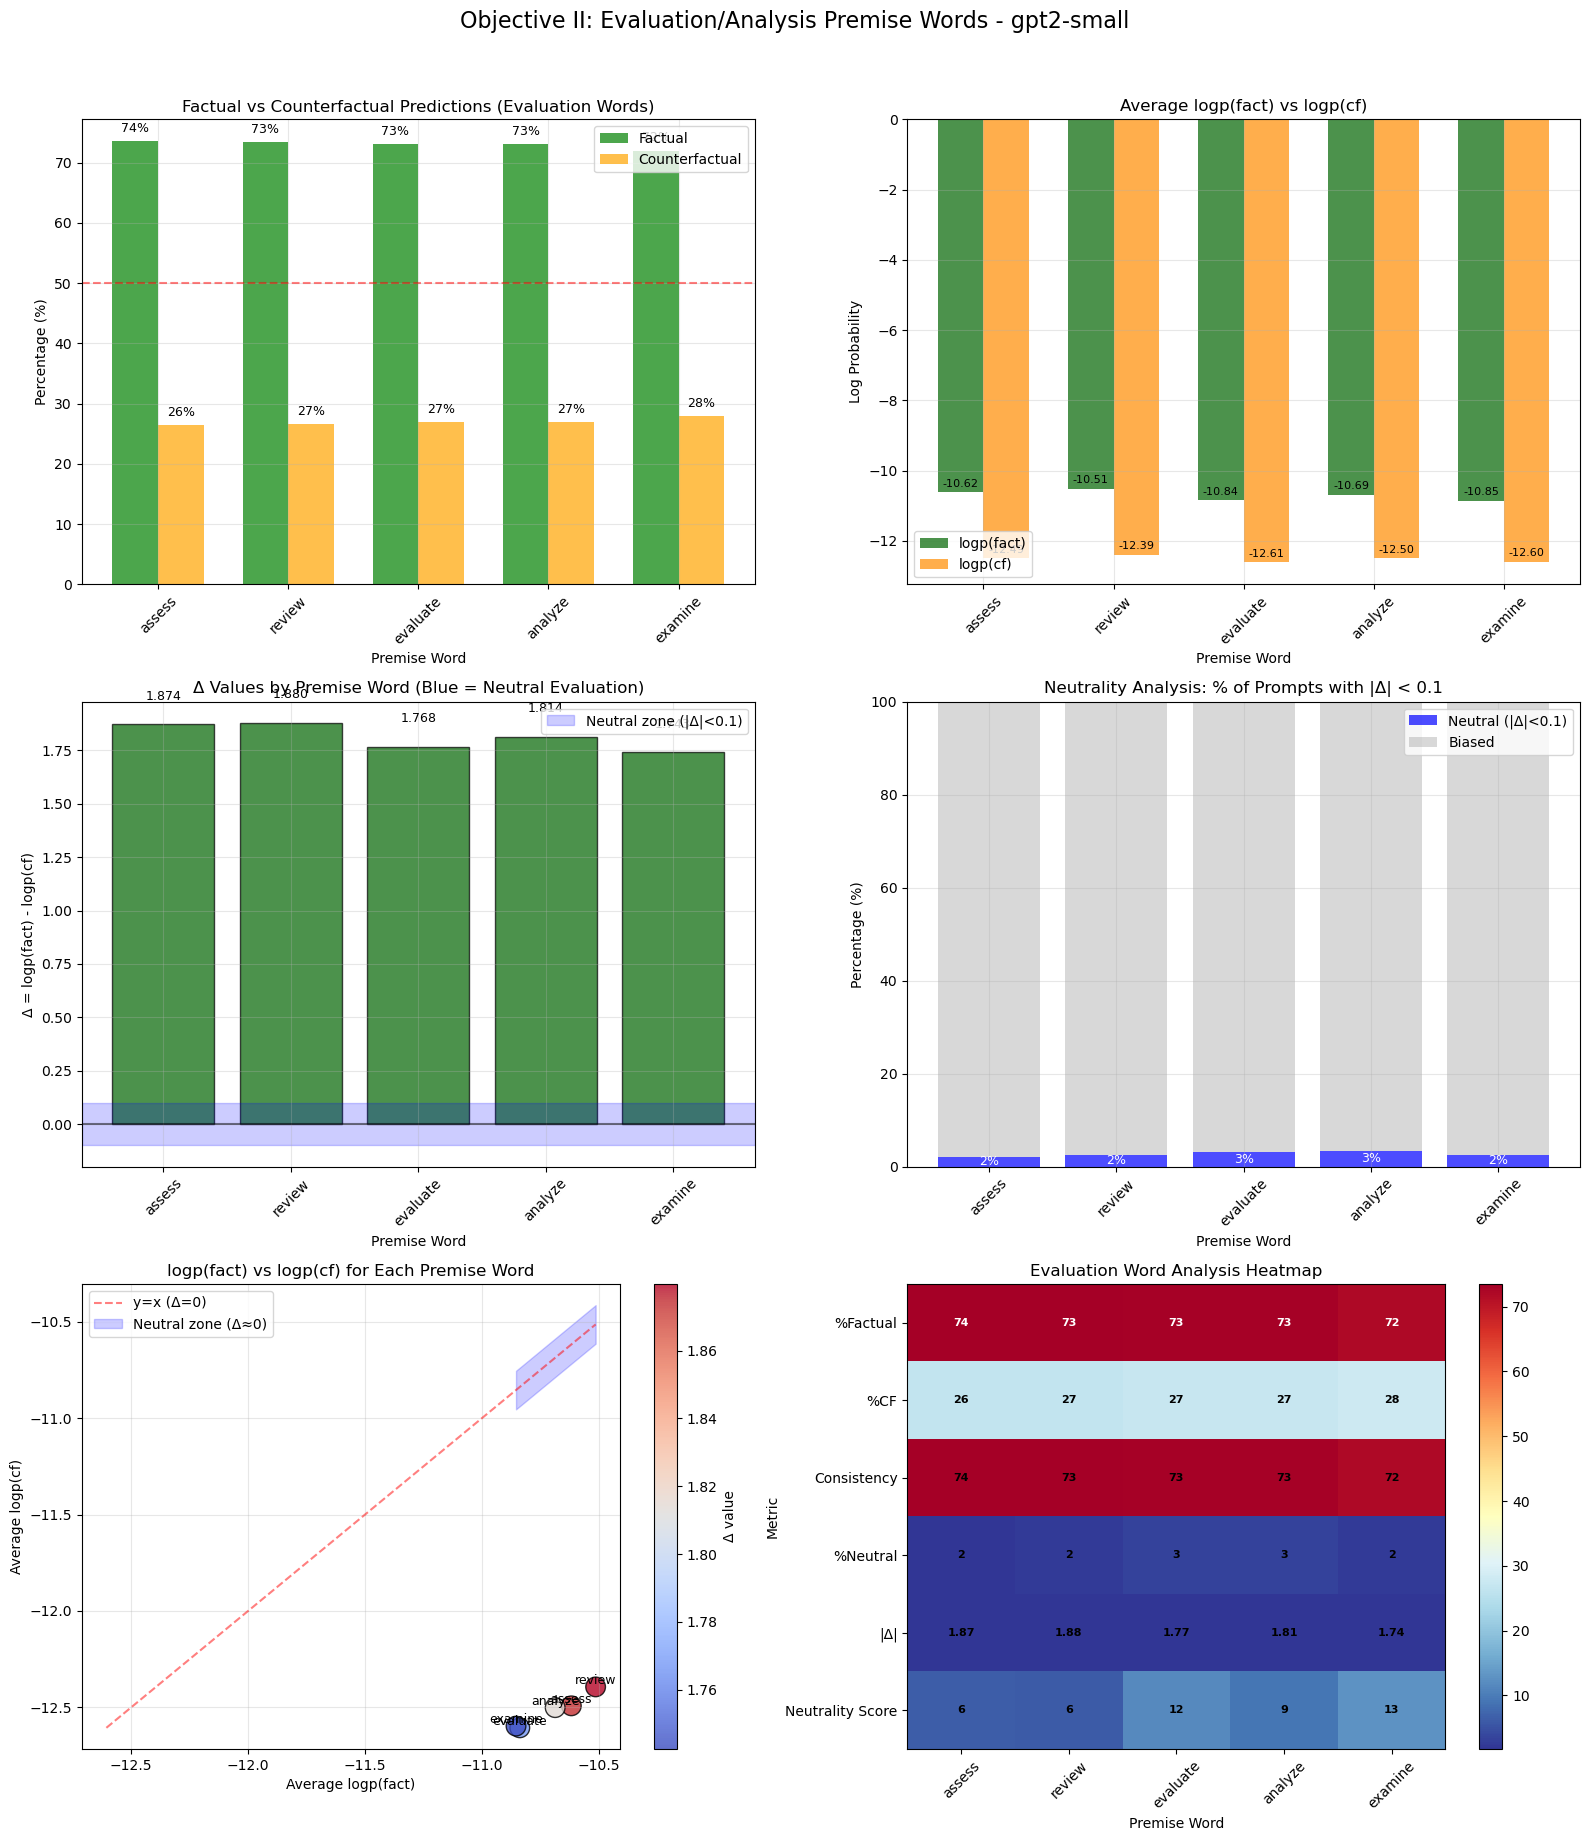

✓ Results saved to evaluation_premise_words_results.json
✗ Definitional results file not found at premise_words_results.json
✗ Verification results file not found at verification_premise_words_results.json

COMPARISON: ALL PREMISE WORD CATEGORIES

Word            Category                  %Factual     Δ           
----------------------------------------------------------------------
analyze         Evaluation/Analysis       73.0         1.8142      
assess          Evaluation/Analysis       73.5         1.8740      
evaluate        Evaluation/Analysis       73.0         1.7677      
examine         Evaluation/Analysis       72.0         1.7425      
review          Evaluation/Analysis       73.4         1.8796      

CATEGORY AVERAGES

Category                  Avg %Factual    Avg Δ           Word Count  
----------------------------------------------------------------------
Evaluation/Analysis       73.0            1.8156          5           

CATEGORY COMPARISON ANALYSIS

Interpret

In [8]:
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class EvaluationPremiseWordResult:
    """Stores results for a single prompt with evaluation/analysis premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class EvaluationPremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Evaluation/Analysis premise words to analyze
        self.premise_words = ['assess', 'review', 'evaluate', 'analyze', 'examine']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'assess': 'Evaluation/Analysis',
            'review': 'Evaluation/Analysis', 
            'evaluate': 'Evaluation/Analysis',
            'analyze': 'Evaluation/Analysis',
            'examine': 'Evaluation/Analysis'
        }
        
        # Expected bias for each word (evaluation words might be more neutral)
        self.expected_bias = {
            'assess': 'Neutral analytical assessment',
            'review': 'Neutral review/assessment',
            'evaluate': 'Neutral evaluation',
            'analyze': 'Neutral analysis',
            'examine': 'Neutral examination'
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        if ':' in original_prompt:
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[EvaluationPremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = EvaluationPremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Evaluation Premise Word experiment"""
        print(f"\n{'='*80}")
        print(f"OBJECTIVE II PART 3: EVALUATION/ANALYSIS PREMISE WORDS")
        print(f"{'='*80}")
        print(f"Model: {self.model_name.upper()}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} evaluation/analysis premise words:")
        for i, word in enumerate(self.premise_words, 1):
            print(f"  {i}. {word}")
        
        print(f"\nProcessing {len(all_items)} items for each premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * len(all_items)}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            for item in tqdm(all_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for all evaluation/analysis premise words with detailed metrics"""
        if not self.results:
            print("No results to analyze")
            return
        
        print(f"\n{'='*100}")
        print("EVALUATION/ANALYSIS PREMISE WORDS: DETAILED METRICS")
        print(f"{'='*100}")
        print("\nFormat for each premise word:")
        print("  logp(fact): average log probability of factual answer")
        print("  logp(cf):   average log probability of counterfactual answer")
        print("  Δ:          logp(fact) - logp(cf)")
        print("\nExpected Bias: Evaluation/Analysis words are expected to be more neutral/analytical")
        
        # Dictionary to store aggregated results by premise word
        word_metrics = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                # Calculate metrics
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                counterfactual_pct = 100 - factual_pct
                
                # Calculate average log probabilities
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                
                # Calculate standard deviations
                std_factual_logp = np.std([r.factual_logp for r in word_results])
                std_counterfactual_logp = np.std([r.counterfactual_logp for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                # Calculate additional statistics
                median_factual_logp = np.median([r.factual_logp for r in word_results])
                median_counterfactual_logp = np.median([r.counterfactual_logp for r in word_results])
                median_delta = np.median([r.delta for r in word_results])
                
                # Calculate factual win consistency (how consistently factual wins)
                factual_wins = sum(1 for r in word_results if r.delta > 0)
                factual_consistency = (factual_wins / total) * 100
                
                # Calculate neutral zone percentage (|Δ| < 0.1)
                neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.1)
                neutral_pct = (neutral_count / total) * 100
                
                # Store metrics
                word_metrics[word] = {
                    'count': total,
                    'factual_pct': factual_pct,
                    'counterfactual_pct': counterfactual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_factual_logp': std_factual_logp,
                    'std_counterfactual_logp': std_counterfactual_logp,
                    'std_delta': std_delta,
                    'median_factual_logp': median_factual_logp,
                    'median_counterfactual_logp': median_counterfactual_logp,
                    'median_delta': median_delta,
                    'factual_consistency': factual_consistency,
                    'neutral_pct': neutral_pct,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'neutrality_score': 100 - abs(avg_delta) * 50  # Higher = more neutral
                }
        
        # Print detailed table for all premise words
        print(f"\n{'='*140}")
        print(f"{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'logp(fact)':<15} {'logp(cf)':<15} {'Δ':<15} {'Neutral %':<12} {'Factual Consist.':<15} {'Neutrality':<12}")
        print(f"{'':<15} {'':<8} {'':<10} {'':<10} {'(mean±std)':<15} {'(mean±std)':<15} {'(mean±std)':<15} {'(|Δ|<0.1)':<12} {'(% Δ>0)':<15} {'Score':<12}")
        print("-" * 140)
        
        for word, metrics in word_metrics.items():
            print(f"{word:<15} {metrics['count']:<8} {metrics['factual_pct']:<10.1f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['avg_factual_logp']:7.4f}±{metrics['std_factual_logp']:<7.4f} "
                  f"{metrics['avg_counterfactual_logp']:7.4f}±{metrics['std_counterfactual_logp']:<7.4f} "
                  f"{metrics['avg_delta']:7.4f}±{metrics['std_delta']:<7.4f} "
                  f"{metrics['neutral_pct']:<12.1f} "
                  f"{metrics['factual_consistency']:<15.1f} "
                  f"{metrics['neutrality_score']:<12.1f}")
        
        # Print individual premise word summaries
        print(f"\n{'='*80}")
        print("INDIVIDUAL PREMISE WORD SUMMARIES")
        print(f"{'='*80}")
        
        for word, metrics in word_metrics.items():
            print(f"\n{'='*60}")
            print(f"PREMISE WORD: {word.upper()}")
            print(f"{'='*60}")
            print(f"  Number of prompts analyzed: {metrics['count']}")
            print(f"  Factual predictions: {metrics['factual_pct']:.1f}%")
            print(f"  Counterfactual predictions: {metrics['counterfactual_pct']:.1f}%")
            print(f"  Neutral predictions (|Δ| < 0.1): {metrics['neutral_pct']:.1f}%")
            print(f"\n  Average Log Probabilities:")
            print(f"    logp(fact): {metrics['avg_factual_logp']:.4f} (std: {metrics['std_factual_logp']:.4f})")
            print(f"    logp(cf):   {metrics['avg_counterfactual_logp']:.4f} (std: {metrics['std_counterfactual_logp']:.4f})")
            print(f"    Δ:          {metrics['avg_delta']:.4f} (std: {metrics['std_delta']:.4f})")
            print(f"\n  Median Values:")
            print(f"    logp(fact): {metrics['median_factual_logp']:.4f}")
            print(f"    logp(cf):   {metrics['median_counterfactual_logp']:.4f}")
            print(f"    Δ:          {metrics['median_delta']:.4f}")
            print(f"\n  Factual Consistency: {metrics['factual_consistency']:.1f}% of prompts have Δ > 0")
            print(f"  Neutrality Score: {metrics['neutrality_score']:.1f}/100 (higher = more neutral)")
            print(f"  Expected Bias: {self.expected_bias.get(word, 'Unknown')}")
            
            # Interpretation based on Δ
            if abs(metrics['avg_delta']) < 0.1:
                bias_strength = "NEUTRAL (balanced analysis)"
            elif metrics['avg_delta'] > 0.5:
                bias_strength = "STRONG factual bias"
            elif metrics['avg_delta'] > 0.1:
                bias_strength = "Moderate factual bias"
            elif metrics['avg_delta'] < -0.5:
                bias_strength = "STRONG counterfactual bias"
            elif metrics['avg_delta'] < -0.1:
                bias_strength = "Moderate counterfactual bias"
            else:
                bias_strength = "Slight bias"
            
            print(f"  Interpretation: {bias_strength}")
        
        # Summary statistics across all premise words
        print(f"\n{'='*80}")
        print("SUMMARY ACROSS ALL EVALUATION/ANALYSIS PREMISE WORDS")
        print(f"{'='*80}")
        
        # Calculate averages across all premise words
        avg_factual_logp_all = np.mean([m['avg_factual_logp'] for m in word_metrics.values()])
        avg_counterfactual_logp_all = np.mean([m['avg_counterfactual_logp'] for m in word_metrics.values()])
        avg_delta_all = np.mean([m['avg_delta'] for m in word_metrics.values()])
        avg_factual_pct_all = np.mean([m['factual_pct'] for m in word_metrics.values()])
        avg_factual_consistency_all = np.mean([m['factual_consistency'] for m in word_metrics.values()])
        avg_neutral_pct_all = np.mean([m['neutral_pct'] for m in word_metrics.values()])
        avg_neutrality_score_all = np.mean([m['neutrality_score'] for m in word_metrics.values()])
        
        print(f"\n  Average across all {len(word_metrics)} evaluation/analysis premise words:")
        print(f"    logp(fact): {avg_factual_logp_all:.4f}")
        print(f"    logp(cf):   {avg_counterfactual_logp_all:.4f}")
        print(f"    Δ:          {avg_delta_all:.4f}")
        print(f"    % Factual:  {avg_factual_pct_all:.1f}%")
        print(f"    Factual Consistency: {avg_factual_consistency_all:.1f}%")
        print(f"    Neutral prompts (|Δ|<0.1): {avg_neutral_pct_all:.1f}%")
        print(f"    Average Neutrality Score: {avg_neutrality_score_all:.1f}/100")
        
        # Evaluate neutrality of evaluation words
        print(f"\n  Neutrality Analysis:")
        neutral_word_count = sum(1 for m in word_metrics.values() if abs(m['avg_delta']) < 0.1)
        print(f"    Words with |Δ| < 0.1 (neutral): {neutral_word_count}/{len(word_metrics)}")
        
        if avg_neutral_pct_all > 30:
            print("    Conclusion: Evaluation words show MODERATE neutrality")
        elif avg_neutral_pct_all > 20:
            print("    Conclusion: Evaluation words show SOME neutrality")
        else:
            print("    Conclusion: Evaluation words show LOW neutrality")
        
        # Ranking by Δ value (most neutral to most biased)
        print(f"\n{'='*80}")
        print("RANKING BY NEUTRALITY (|Δ| closest to 0)")
        print(f"{'='*80}")
        
        sorted_by_neutrality = sorted(word_metrics.items(), key=lambda x: abs(x[1]['avg_delta']))
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'|Δ|':<15} {'Δ':<15} {'%Factual':<10} {'Neutral %':<12}")
        print("-" * 80)
        
        for rank, (word, metrics) in enumerate(sorted_by_neutrality, 1):
            print(f"{rank:<6} {word:<15} {abs(metrics['avg_delta']):<15.4f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['factual_pct']:<10.1f} "
                  f"{metrics['neutral_pct']:<12.1f}")
        
        # Ranking by factual consistency
        print(f"\n{'='*80}")
        print("RANKING BY FACTUAL CONSISTENCY (% of prompts with Δ > 0)")
        print(f"{'='*80}")
        
        sorted_by_consistency = sorted(word_metrics.items(), key=lambda x: x[1]['factual_consistency'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Consistency':<15} {'Δ':<15} {'%Factual':<10}")
        print("-" * 70)
        
        for rank, (word, metrics) in enumerate(sorted_by_consistency, 1):
            print(f"{rank:<6} {word:<15} {metrics['factual_consistency']:<15.1f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['factual_pct']:<10.1f}")
        
        # Create visualizations
        self.plot_results(word_metrics)
        
        return word_metrics
    
    def plot_results(self, word_metrics):
        """Create visualizations of evaluation/analysis premise word results"""
        if not word_metrics:
            return
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        # Prepare data for plots
        words = list(word_metrics.keys())
        factual_pcts = [word_metrics[w]['factual_pct'] for w in words]
        counterfactual_pcts = [word_metrics[w]['counterfactual_pct'] for w in words]
        avg_factual_logps = [word_metrics[w]['avg_factual_logp'] for w in words]
        avg_counterfactual_logps = [word_metrics[w]['avg_counterfactual_logp'] for w in words]
        avg_deltas = [word_metrics[w]['avg_delta'] for w in words]
        factual_consistencies = [word_metrics[w]['factual_consistency'] for w in words]
        neutral_pcts = [word_metrics[w]['neutral_pct'] for w in words]
        
        # Plot 1: Factual vs Counterfactual percentages
        x = np.arange(len(words))
        width = 0.35
        
        axes[0].bar(x - width/2, factual_pcts, width, label='Factual', color='green', alpha=0.7)
        axes[0].bar(x + width/2, counterfactual_pcts, width, label='Counterfactual', color='orange', alpha=0.7)
        axes[0].set_xlabel('Premise Word')
        axes[0].set_ylabel('Percentage (%)')
        axes[0].set_title('Factual vs Counterfactual Predictions (Evaluation Words)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(words, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
        
        # Add percentage labels
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            axes[0].text(i - width/2, fact + 1, f'{fact:.0f}%', ha='center', va='bottom', fontsize=9)
            axes[0].text(i + width/2, cf + 1, f'{cf:.0f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: logp(fact) and logp(cf) comparison
        x = np.arange(len(words))
        
        axes[1].bar(x - width/2, avg_factual_logps, width, label='logp(fact)', color='darkgreen', alpha=0.7)
        axes[1].bar(x + width/2, avg_counterfactual_logps, width, label='logp(cf)', color='darkorange', alpha=0.7)
        axes[1].set_xlabel('Premise Word')
        axes[1].set_ylabel('Log Probability')
        axes[1].set_title('Average logp(fact) vs logp(cf)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(words, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (fact_logp, cf_logp) in enumerate(zip(avg_factual_logps, avg_counterfactual_logps)):
            axes[1].text(i - width/2, fact_logp + 0.1, f'{fact_logp:.2f}', ha='center', va='bottom', fontsize=8)
            axes[1].text(i + width/2, cf_logp + 0.1, f'{cf_logp:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Δ values with neutrality indication
        colors = []
        for delta in avg_deltas:
            if abs(delta) < 0.1:
                colors.append('blue')  # Neutral
            elif delta > 0.5:
                colors.append('darkgreen')  # Strong factual bias
            elif delta > 0.1:
                colors.append('lightgreen')  # Moderate factual bias
            elif delta < -0.5:
                colors.append('darkred')  # Strong counterfactual bias
            else:
                colors.append('lightcoral')  # Moderate counterfactual bias
        
        bars = axes[2].bar(words, avg_deltas, color=colors, alpha=0.7, edgecolor='black')
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[2].axhspan(-0.1, 0.1, alpha=0.2, color='blue', label='Neutral zone (|Δ|<0.1)')
        axes[2].set_xlabel('Premise Word')
        axes[2].set_ylabel('Δ = logp(fact) - logp(cf)')
        axes[2].set_title('Δ Values by Premise Word (Blue = Neutral Evaluation)')
        axes[2].set_xticklabels(words, rotation=45)
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        # Add Δ value labels
        for bar, delta in zip(bars, avg_deltas):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
                        f'{delta:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        # Plot 4: Neutrality Analysis
        x = np.arange(len(words))
        width = 0.8
        
        # Create stacked bar: neutral vs non-neutral
        neutral_bars = axes[3].bar(x, neutral_pcts, width, color='blue', alpha=0.7, label='Neutral (|Δ|<0.1)')
        non_neutral_pcts = [100 - n for n in neutral_pcts]
        non_neutral_bars = axes[3].bar(x, non_neutral_pcts, width, bottom=neutral_pcts, color='gray', alpha=0.3, label='Biased')
        
        axes[3].set_xlabel('Premise Word')
        axes[3].set_ylabel('Percentage (%)')
        axes[3].set_title('Neutrality Analysis: % of Prompts with |Δ| < 0.1')
        axes[3].set_xticks(x)
        axes[3].set_xticklabels(words, rotation=45)
        axes[3].set_ylim([0, 100])
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        # Add percentage labels
        for i, neutral_pct in enumerate(neutral_pcts):
            axes[3].text(i, neutral_pct/2, f'{neutral_pct:.0f}%', ha='center', va='center', fontsize=9, color='white')
        
        # Plot 5: Scatter plot of logp(fact) vs logp(cf) colored by Δ
        scatter = axes[4].scatter(avg_factual_logps, avg_counterfactual_logps, 
                                  c=avg_deltas, cmap='coolwarm', s=200, alpha=0.8, edgecolors='black')
        axes[4].plot([min(avg_factual_logps + avg_counterfactual_logps), 
                     max(avg_factual_logps + avg_counterfactual_logps)], 
                    [min(avg_factual_logps + avg_counterfactual_logps), 
                     max(avg_factual_logps + avg_counterfactual_logps)], 
                    'r--', alpha=0.5, label='y=x (Δ=0)')
        
        # Add neutral zone
        axes[4].fill_between([min(avg_factual_logps), max(avg_factual_logps)],
                           [min(avg_factual_logps) - 0.1, max(avg_factual_logps) - 0.1],
                           [min(avg_factual_logps) + 0.1, max(avg_factual_logps) + 0.1],
                           alpha=0.2, color='blue', label='Neutral zone (Δ≈0)')
        
        axes[4].set_xlabel('Average logp(fact)')
        axes[4].set_ylabel('Average logp(cf)')
        axes[4].set_title('logp(fact) vs logp(cf) for Each Premise Word')
        axes[4].grid(True, alpha=0.3)
        axes[4].legend()
        
        # Add premise word labels to points
        for i, word in enumerate(words):
            axes[4].text(avg_factual_logps[i], avg_counterfactual_logps[i], word, 
                        fontsize=9, ha='center', va='bottom')
        
        # Add colorbar for Δ values
        cbar = plt.colorbar(scatter, ax=axes[4])
        cbar.set_label('Δ value')
        
        # Plot 6: Evaluation Effectiveness Heatmap
        metrics_for_heatmap = np.array([
            factual_pcts,
            counterfactual_pcts,
            factual_consistencies,
            neutral_pcts,
            [abs(d) for d in avg_deltas],  # Absolute Δ (distance from neutral)
            [word_metrics[w]['neutrality_score'] for w in words]
        ])
        
        im = axes[5].imshow(metrics_for_heatmap, cmap='RdYlBu_r', aspect='auto')
        axes[5].set_xlabel('Premise Word')
        axes[5].set_ylabel('Metric')
        axes[5].set_title('Evaluation Word Analysis Heatmap')
        axes[5].set_xticks(range(len(words)))
        axes[5].set_xticklabels(words, rotation=45)
        axes[5].set_yticks(range(6))
        axes[5].set_yticklabels(['%Factual', '%CF', 'Consistency', '%Neutral', '|Δ|', 'Neutrality Score'])
        
        # Add text annotations
        for i in range(6):
            for j in range(len(words)):
                if i == 5:  # Neutrality score
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                elif i in [0, 1, 2, 3]:  # Percentage metrics
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                else:  # |Δ|
                    text = f'{metrics_for_heatmap[i, j]:.2f}'
                
                color = 'white' if (i == 0 and metrics_for_heatmap[i, j] > 70) or \
                                  (i == 1 and metrics_for_heatmap[i, j] > 70) or \
                                  (i == 3 and metrics_for_heatmap[i, j] > 50) or \
                                  (i == 5 and metrics_for_heatmap[i, j] > 70) else 'black'
                
                axes[5].text(j, i, text, ha='center', va='center', 
                           color=color, fontsize=8, fontweight='bold')
        
        plt.colorbar(im, ax=axes[5])
        
        plt.suptitle(f'Objective II: Evaluation/Analysis Premise Words - {self.model_name}', 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_evaluation_words_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_other_categories(self, definitional_results_path: str = "premise_words_results.json",
                                     verification_results_path: str = "verification_premise_words_results.json"):
        """Compare evaluation words with definitional and verification words from previous experiments"""
        all_categories = {}
        
        try:
            # Load definitional results
            with open(definitional_results_path, 'r') as f:
                definitional_data = json.load(f)
            
            if 'premise_word_summary' in definitional_data:
                for word, stats in definitional_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Definitional/Override'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Definitional results file not found at {definitional_results_path}")
        
        try:
            # Load verification results
            with open(verification_results_path, 'r') as f:
                verification_data = json.load(f)
            
            if 'premise_word_summary' in verification_data:
                for word, stats in verification_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Verification/Fact-Checking'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Verification results file not found at {verification_results_path}")
        
        # Add evaluation results
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_delta = np.mean([r.delta for r in word_results])
                
                all_categories[word] = {
                    'factual_pct': factual_pct,
                    'avg_delta': avg_delta,
                    'category': 'Evaluation/Analysis'
                }
        
        if len(all_categories) < 3:  # Need at least one word from each category
            print("Not enough data for comparison")
            return
        
        print(f"\n{'='*80}")
        print("COMPARISON: ALL PREMISE WORD CATEGORIES")
        print(f"{'='*80}")
        
        # Print comparison table
        print(f"\n{'Word':<15} {'Category':<25} {'%Factual':<12} {'Δ':<12}")
        print("-" * 70)
        
        for word in sorted(all_categories.keys()):
            data = all_categories.get(word)
            if data:
                print(f"{word:<15} {data['category']:<25} {data['factual_pct']:<12.1f} {data['avg_delta']:<12.4f}")
        
        # Calculate category averages
        category_stats = {}
        for word, data in all_categories.items():
            category = data['category']
            if category not in category_stats:
                category_stats[category] = {'factual_pcts': [], 'deltas': [], 'words': []}
            category_stats[category]['factual_pcts'].append(data['factual_pct'])
            category_stats[category]['deltas'].append(data['avg_delta'])
            category_stats[category]['words'].append(word)
        
        print(f"\n{'='*70}")
        print("CATEGORY AVERAGES")
        print(f"{'='*70}")
        print(f"\n{'Category':<25} {'Avg %Factual':<15} {'Avg Δ':<15} {'Word Count':<12}")
        print("-" * 70)
        
        for category, stats in category_stats.items():
            avg_factual = np.mean(stats['factual_pcts'])
            avg_delta = np.mean(stats['deltas'])
            word_count = len(stats['words'])
            print(f"{category:<25} {avg_factual:<15.1f} {avg_delta:<15.4f} {word_count:<12}")
        
        # Category comparison analysis
        print(f"\n{'='*70}")
        print("CATEGORY COMPARISON ANALYSIS")
        print(f"{'='*70}")
        
        if 'Definitional/Override' in category_stats and 'Verification/Fact-Checking' in category_stats:
            def_factual = np.mean(category_stats['Definitional/Override']['factual_pcts'])
            ver_factual = np.mean(category_stats['Verification/Fact-Checking']['factual_pcts'])
            
            if 'Evaluation/Analysis' in category_stats:
                eval_factual = np.mean(category_stats['Evaluation/Analysis']['factual_pcts'])
                print(f"\nFactual Bias Ranking (Highest to Lowest):")
                
                categories_ranked = sorted([
                    ('Verification/Fact-Checking', ver_factual),
                    ('Evaluation/Analysis', eval_factual),
                    ('Definitional/Override', def_factual)
                ], key=lambda x: x[1], reverse=True)
                
                for rank, (cat, pct) in enumerate(categories_ranked, 1):
                    print(f"  {rank}. {cat}: {pct:.1f}% factual")
        
        print(f"\nInterpretation:")
        print("  • Definitional/Override: Expected to accept counterfactuals more readily")
        print("  • Verification/Fact-Checking: Expected to bias toward factual verification")
        print("  • Evaluation/Analysis: Expected to be more neutral/analytical")
    
    def save_results(self, output_path: str = "evaluation_premise_words_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_word': result.premise_word,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise word
        word_summary = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                delta_std = np.std([r.delta for r in word_results])
                factual_wins = sum(1 for r in word_results if r.delta > 0)
                factual_consistency = (factual_wins / total) * 100
                neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.1)
                neutral_pct = (neutral_count / total) * 100
                neutrality_score = 100 - abs(avg_delta) * 50
                
                word_summary[word] = {
                    'count': total,
                    'factual_percent': factual_pct,
                    'counterfactual_percent': 100 - factual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'delta_std': delta_std,
                    'factual_consistency': factual_consistency,
                    'neutral_percent': neutral_pct,
                    'neutrality_score': neutrality_score,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'neutrality_rating': 'High' if abs(avg_delta) < 0.1 else 'Moderate' if abs(avg_delta) < 0.3 else 'Low'
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        factual_wins_count = sum(1 for r in self.results if r.delta > 0)
        factual_consistency = (factual_wins_count / total) * 100
        neutral_count = sum(1 for r in self.results if abs(r.delta) < 0.1)
        neutral_percent = (neutral_count / total) * 100
        avg_delta_all = np.mean([r.delta for r in self.results])
        neutrality_score_all = 100 - abs(avg_delta_all) * 50
        
        # Calculate ranking
        ranking_by_neutrality = sorted(
            [(word, stats['neutrality_score']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_delta = sorted(
            [(word, stats['avg_delta']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_consistency = sorted(
            [(word, stats['factual_consistency']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'objective': 'II - Effect of Evaluation/Analysis Premise Words',
                'prompt_template': self.premise_word_template,
                'premise_words_tested': self.premise_words,
                'category': 'Evaluation/Analysis',
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'neutral_percent': neutral_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': avg_delta_all,
                    'delta_std': np.std([r.delta for r in self.results]),
                    'factual_consistency': factual_consistency,
                    'neutrality_score': neutrality_score_all,
                    'neutrality_interpretation': 'High' if abs(avg_delta_all) < 0.1 else 'Moderate' if abs(avg_delta_all) < 0.3 else 'Low',
                    'ranking_by_neutrality': ranking_by_neutrality,
                    'ranking_by_delta': ranking_by_delta,
                    'ranking_by_consistency': ranking_by_consistency,
                    'most_neutral_word': ranking_by_neutrality[0][0] if ranking_by_neutrality else None,
                    'most_factual_word': ranking_by_delta[0][0] if ranking_by_delta else None,
                    'most_consistent_word': ranking_by_consistency[0][0] if ranking_by_consistency else None
                },
                'premise_word_summary': word_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Number of items to process (set to None for full dataset)
    
    print(f"{'='*80}")
    print("OBJECTIVE II PART 3: EVALUATION/ANALYSIS PREMISE WORDS")
    print(f"{'='*80}")
    print(f"Testing premise words: assess, review, evaluate, analyze, examine")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"{'='*80}")
    
    # Create and run experiment
    experiment = EvaluationPremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run the experiment
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save results
        experiment.save_results()
        
        # Compare with other categories if available
        experiment.compare_with_other_categories(
            definitional_results_path="premise_words_results.json",
            verification_results_path="verification_premise_words_results.json"
        )
        
        # Final summary
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETE")
        print(f"{'='*80}")
        print(f"Total prompts processed: {len(results)}")
        print(f"Evaluation/Analysis premise words tested: {', '.join(experiment.premise_words)}")
        print(f"\nKey Metrics Collected for Each Premise Word:")
        print("  - % factual: Percentage of factual predictions")
        print("  - % counterfactual: Percentage of counterfactual predictions")
        print("  - logp(fact): Average log probability of factual answer")
        print("  - logp(cf): Average log probability of counterfactual answer")
        print("  - Δ: logp(fact) - logp(cf)")
        print("  - % Neutral: Percentage of prompts with |Δ| < 0.1")
        print("  - Factual Consistency: % of prompts with Δ > 0")
        print("  - Neutrality Score: 0-100 scale (higher = more neutral)")
        print(f"\nExpected Behavior: Evaluation/Analysis words are expected to be more neutral/analytical")
        print(f"\nResults saved to:")
        print("  - evaluation_premise_words_results.json")
        print("  - objective_II_evaluation_words_{model_name}.png (visualizations)")

OBJECTIVE II PART 4: HYPOTHETICAL/FICTIONAL PREMISE WORDS
Testing premise words: suppose, imagine, assume, consider, pretend
Model: gpt2-small
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000

OBJECTIVE II PART 4: HYPOTHETICAL/FICTIONAL PREMISE WORDS
Model: GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 hypothetical/fictional premise words:
  1. suppose (Expected: Strong counterfactual bias)
  2. imagine (Expected: Strong counterfactual bias)
  3. assume (Expected: Moderate counterfactual bias)
  4. consider (Expected: Moderate counterfactual bias)
  5. pretend (Expected: Strong counterfactual bias)

Processing 1000 items for each premise word...
Total expected prompts: 5000


Premise words: 100%|██████████| 5/5 [03:08<00:00, 37.62s/it]


✓ Processed 5000 prompts successfully

HYPOTHETICAL/FICTIONAL PREMISE WORDS: DETAILED METRICS

Format for each premise word:
  logp(fact): average log probability of factual answer
  logp(cf):   average log probability of counterfactual answer
  Δ:          logp(fact) - logp(cf)

Expected Bias: Hypothetical/Fictional words should strongly bias toward counterfactual answers (Δ < 0)

Interpretation of Δ:
  Δ < 0: Counterfactual answer more likely (Expected for hypothetical words)
  Δ > 0: Factual answer more likely (Contrary to expectation)
  Δ ≈ 0: Balanced probability

Premise Word    Count    %Factual   %CF        logp(fact)      logp(cf)        Δ               CF Consist.  Strong CF%   Exp.   Match 
                                               (mean±std)      (mean±std)      (mean±std)      (% Δ<0)      (Δ<-0.5)     Bias   Exp.  
--------------------------------------------------------------------------------------------------------------------------------------------
suppose      

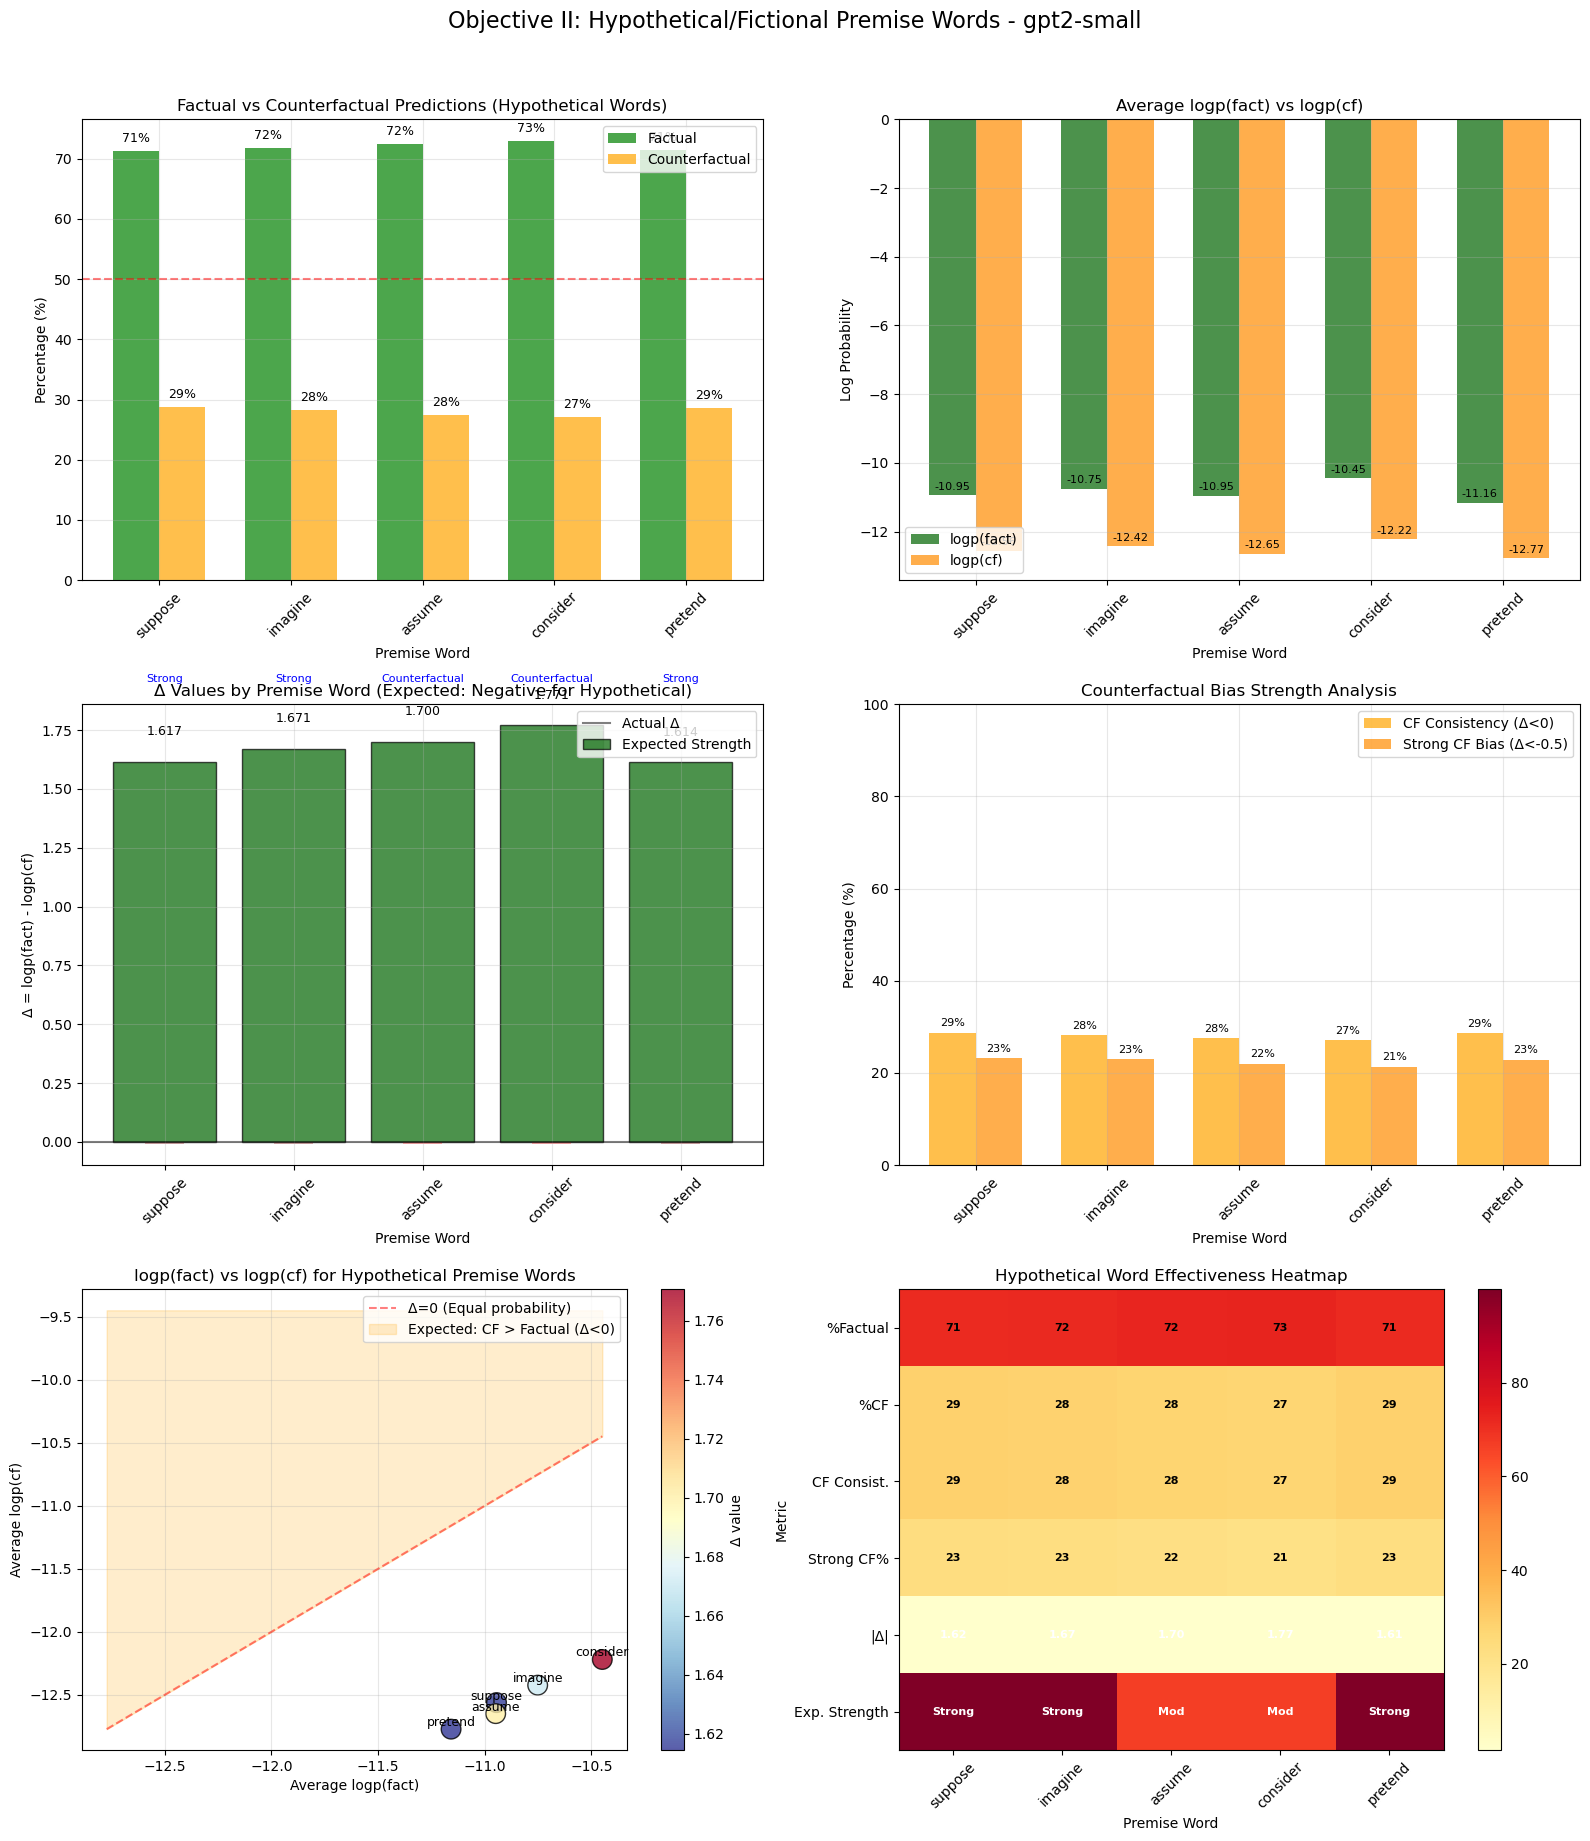

✗ Definitional results file not found at premise_words_results.json
✗ Verification results file not found at verification_premise_words_results.json
✗ Evaluation results file not found at evaluation_premise_words_results.json

COMPREHENSIVE COMPARISON: ALL PREMISE WORD CATEGORIES

Word            Category                  %Factual     Δ            Expected       
-------------------------------------------------------------------------------------
assume          Hypothetical/Fictional    72.5         1.7003       Counterfactual 
consider        Hypothetical/Fictional    72.9         1.7707       Counterfactual 
imagine         Hypothetical/Fictional    71.8         1.6714       Counterfactual 
pretend         Hypothetical/Fictional    71.4         1.6145       Counterfactual 
suppose         Hypothetical/Fictional    71.3         1.6167       Counterfactual 

CATEGORY AVERAGES (Ranked by Δ)

Category                  Avg %Factual    Avg Δ           Word Count  
-----------------------

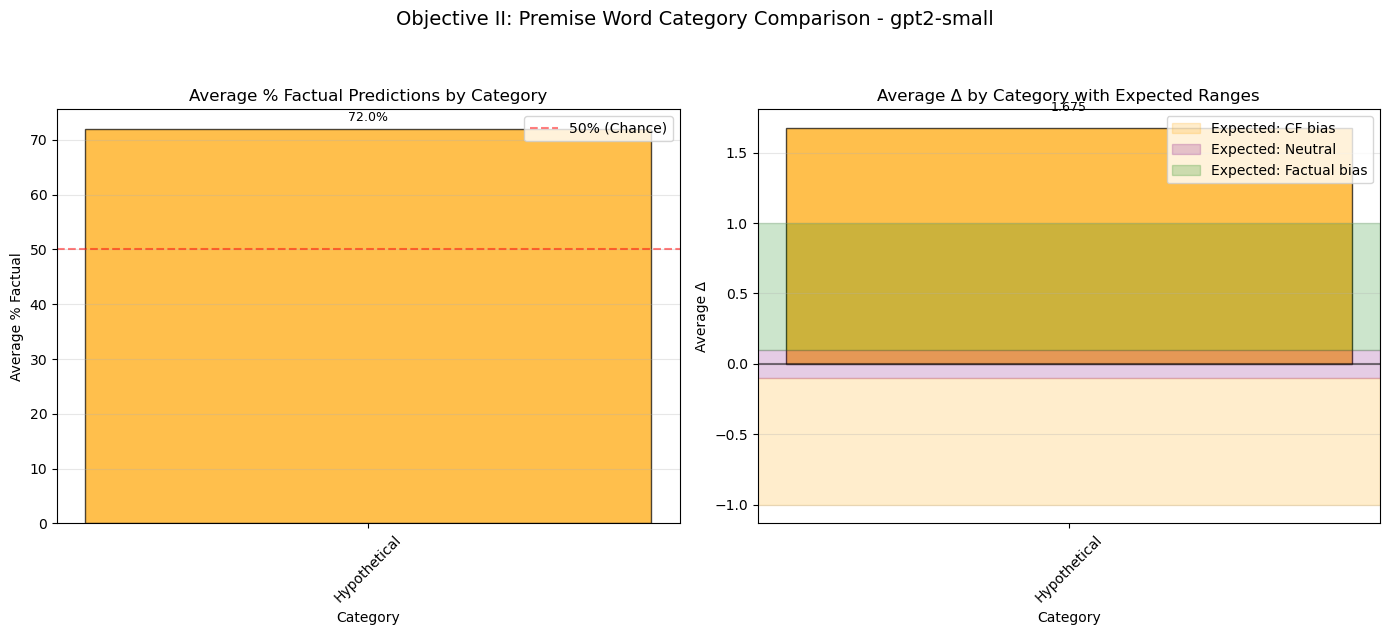


EXPERIMENT COMPLETE
Total prompts processed: 5000
Hypothetical/Fictional premise words tested: suppose, imagine, assume, consider, pretend

Key Metrics Collected for Each Premise Word:
  - % factual: Percentage of factual predictions
  - % counterfactual: Percentage of counterfactual predictions
  - logp(fact): Average log probability of factual answer
  - logp(cf): Average log probability of counterfactual answer
  - Δ: logp(fact) - logp(cf)
  - Counterfactual Consistency: % of prompts with Δ < 0
  - Strong Counterfactual Bias: % of prompts with Δ < -0.5

Expected Behavior: Hypothetical/Fictional words should strongly bias toward counterfactual answers (Δ < 0)

Results saved to:
  - hypothetical_premise_words_results.json
  - objective_II_hypothetical_words_{model_name}.png (visualizations)
  - objective_II_category_comparison_{model_name}.png (category comparison)


In [10]:
# objective_II_hypothetical_fictional.ipynb

import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class HypotheticalPremiseWordResult:
    """Stores results for a single prompt with hypothetical/fictional premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class HypotheticalPremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Hypothetical/Fictional premise words to analyze
        self.premise_words = ['suppose', 'imagine', 'assume', 'consider', 'pretend']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'suppose': 'Hypothetical/Fictional',
            'imagine': 'Hypothetical/Fictional', 
            'assume': 'Hypothetical/Fictional',
            'consider': 'Hypothetical/Fictional',
            'pretend': 'Hypothetical/Fictional'
        }
        
        # Expected bias for each word (hypothetical words should bias toward counterfactual)
        self.expected_bias = {
            'suppose': 'Strong counterfactual bias (hypothetical framing)',
            'imagine': 'Strong counterfactual bias (imaginative framing)',
            'assume': 'Counterfactual bias (assumption framing)',
            'consider': 'Counterfactual bias (consideration framing)',
            'pretend': 'Strong counterfactual bias (pretend/play framing)'
        }
        
        # Strength of expected bias (on scale of 1-3)
        self.expected_bias_strength = {
            'suppose': 3,  # Strong
            'imagine': 3,  # Strong
            'assume': 2,   # Moderate
            'consider': 2, # Moderate
            'pretend': 3   # Strong
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        if ':' in original_prompt:
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[HypotheticalPremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = HypotheticalPremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Hypothetical Premise Word experiment"""
        print(f"\n{'='*80}")
        print(f"OBJECTIVE II PART 4: HYPOTHETICAL/FICTIONAL PREMISE WORDS")
        print(f"{'='*80}")
        print(f"Model: {self.model_name.upper()}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} hypothetical/fictional premise words:")
        for i, word in enumerate(self.premise_words, 1):
            strength = self.expected_bias_strength[word]
            strength_str = "Strong" if strength == 3 else "Moderate" if strength == 2 else "Weak"
            print(f"  {i}. {word} (Expected: {strength_str} counterfactual bias)")
        
        print(f"\nProcessing {len(all_items)} items for each premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * len(all_items)}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            for item in tqdm(all_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for all hypothetical/fictional premise words with detailed metrics"""
        if not self.results:
            print("No results to analyze")
            return
        
        print(f"\n{'='*100}")
        print("HYPOTHETICAL/FICTIONAL PREMISE WORDS: DETAILED METRICS")
        print(f"{'='*100}")
        print("\nFormat for each premise word:")
        print("  logp(fact): average log probability of factual answer")
        print("  logp(cf):   average log probability of counterfactual answer")
        print("  Δ:          logp(fact) - logp(cf)")
        print("\nExpected Bias: Hypothetical/Fictional words should strongly bias toward counterfactual answers (Δ < 0)")
        print("\nInterpretation of Δ:")
        print("  Δ < 0: Counterfactual answer more likely (Expected for hypothetical words)")
        print("  Δ > 0: Factual answer more likely (Contrary to expectation)")
        print("  Δ ≈ 0: Balanced probability")
        
        # Dictionary to store aggregated results by premise word
        word_metrics = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                # Calculate metrics
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                counterfactual_pct = 100 - factual_pct
                
                # Calculate average log probabilities
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                
                # Calculate standard deviations
                std_factual_logp = np.std([r.factual_logp for r in word_results])
                std_counterfactual_logp = np.std([r.counterfactual_logp for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                # Calculate additional statistics
                median_factual_logp = np.median([r.factual_logp for r in word_results])
                median_counterfactual_logp = np.median([r.counterfactual_logp for r in word_results])
                median_delta = np.median([r.delta for r in word_results])
                
                # Calculate counterfactual win consistency (how consistently counterfactual wins)
                counterfactual_wins = sum(1 for r in word_results if r.delta < 0)
                counterfactual_consistency = (counterfactual_wins / total) * 100
                
                # Calculate strong counterfactual bias (Δ < -0.5)
                strong_cf_bias_count = sum(1 for r in word_results if r.delta < -0.5)
                strong_cf_bias_pct = (strong_cf_bias_count / total) * 100
                
                # Calculate expected bias match
                expected_negative = self.expected_bias_strength[word] >= 2  # Moderate or strong expected counterfactual bias
                matches_expectation = avg_delta < 0 if expected_negative else abs(avg_delta) < 0.1
                expectation_match_pct = 100 if matches_expectation else 0
                
                # Calculate bias strength score
                if avg_delta < -0.5:
                    bias_strength = "Strong Counterfactual"
                    bias_score = 3
                elif avg_delta < -0.1:
                    bias_strength = "Moderate Counterfactual"
                    bias_score = 2
                elif avg_delta < 0.1:
                    bias_strength = "Neutral"
                    bias_score = 0
                elif avg_delta < 0.5:
                    bias_strength = "Moderate Factual"
                    bias_score = -2
                else:
                    bias_strength = "Strong Factual"
                    bias_score = -3
                
                # Store metrics
                word_metrics[word] = {
                    'count': total,
                    'factual_pct': factual_pct,
                    'counterfactual_pct': counterfactual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_factual_logp': std_factual_logp,
                    'std_counterfactual_logp': std_counterfactual_logp,
                    'std_delta': std_delta,
                    'median_factual_logp': median_factual_logp,
                    'median_counterfactual_logp': median_counterfactual_logp,
                    'median_delta': median_delta,
                    'counterfactual_consistency': counterfactual_consistency,
                    'strong_cf_bias_pct': strong_cf_bias_pct,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'expected_strength': self.expected_bias_strength[word],
                    'matches_expectation': matches_expectation,
                    'expectation_match_pct': expectation_match_pct,
                    'bias_strength': bias_strength,
                    'bias_score': bias_score,
                    'expected_vs_actual_match': '✓' if (expected_negative and avg_delta < 0) or (not expected_negative and abs(avg_delta) < 0.1) else '✗'
                }
        
        # Print detailed table for all premise words
        print(f"\n{'='*140}")
        print(f"{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'logp(fact)':<15} {'logp(cf)':<15} {'Δ':<15} {'CF Consist.':<12} {'Strong CF%':<12} {'Exp.':<6} {'Match':<6}")
        print(f"{'':<15} {'':<8} {'':<10} {'':<10} {'(mean±std)':<15} {'(mean±std)':<15} {'(mean±std)':<15} {'(% Δ<0)':<12} {'(Δ<-0.5)':<12} {'Bias':<6} {'Exp.':<6}")
        print("-" * 140)
        
        for word, metrics in word_metrics.items():
            print(f"{word:<15} {metrics['count']:<8} {metrics['factual_pct']:<10.1f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['avg_factual_logp']:7.4f}±{metrics['std_factual_logp']:<7.4f} "
                  f"{metrics['avg_counterfactual_logp']:7.4f}±{metrics['std_counterfactual_logp']:<7.4f} "
                  f"{metrics['avg_delta']:7.4f}±{metrics['std_delta']:<7.4f} "
                  f"{metrics['counterfactual_consistency']:<12.1f} "
                  f"{metrics['strong_cf_bias_pct']:<12.1f} "
                  f"{'Strong' if metrics['expected_strength'] == 3 else 'Mod' if metrics['expected_strength'] == 2 else 'Weak':<6} "
                  f"{metrics['expected_vs_actual_match']:<6}")
        
        # Print individual premise word summaries
        print(f"\n{'='*80}")
        print("INDIVIDUAL PREMISE WORD SUMMARIES")
        print(f"{'='*80}")
        
        for word, metrics in word_metrics.items():
            print(f"\n{'='*60}")
            print(f"PREMISE WORD: {word.upper()}")
            print(f"{'='*60}")
            print(f"  Number of prompts analyzed: {metrics['count']}")
            print(f"  Factual predictions: {metrics['factual_pct']:.1f}%")
            print(f"  Counterfactual predictions: {metrics['counterfactual_pct']:.1f}%")
            print(f"  Strong counterfactual bias (Δ < -0.5): {metrics['strong_cf_bias_pct']:.1f}%")
            print(f"\n  Average Log Probabilities:")
            print(f"    logp(fact): {metrics['avg_factual_logp']:.4f} (std: {metrics['std_factual_logp']:.4f})")
            print(f"    logp(cf):   {metrics['avg_counterfactual_logp']:.4f} (std: {metrics['std_counterfactual_logp']:.4f})")
            print(f"    Δ:          {metrics['avg_delta']:.4f} (std: {metrics['std_delta']:.4f})")
            print(f"\n  Median Values:")
            print(f"    logp(fact): {metrics['median_factual_logp']:.4f}")
            print(f"    logp(cf):   {metrics['median_counterfactual_logp']:.4f}")
            print(f"    Δ:          {metrics['median_delta']:.4f}")
            print(f"\n  Counterfactual Consistency: {metrics['counterfactual_consistency']:.1f}% of prompts have Δ < 0")
            print(f"  Expected Bias: {self.expected_bias.get(word, 'Unknown')}")
            print(f"  Expected Strength: {'Strong' if metrics['expected_strength'] == 3 else 'Moderate' if metrics['expected_strength'] == 2 else 'Weak'}")
            print(f"  Actual Bias Strength: {metrics['bias_strength']}")
            print(f"  Matches Expectation: {metrics['expected_vs_actual_match']} (Expected Δ < 0)")
            
            # Detailed interpretation
            print(f"\n  Interpretation:")
            if metrics['avg_delta'] < -0.5:
                if metrics['expected_strength'] == 3:
                    print(f"    ✓ STRONG counterfactual bias as expected for '{word}'")
                elif metrics['expected_strength'] == 2:
                    print(f"    ✓ STRONGER counterfactual bias than expected for '{word}'")
                else:
                    print(f"    ! UNEXPECTEDLY STRONG counterfactual bias for '{word}'")
            elif metrics['avg_delta'] < -0.1:
                if metrics['expected_strength'] >= 2:
                    print(f"    ✓ Moderate counterfactual bias as expected for '{word}'")
                else:
                    print(f"    ! Moderate counterfactual bias (somewhat unexpected for '{word}')")
            elif metrics['avg_delta'] < 0.1:
                print(f"    ⚠ NEUTRAL bias (unexpected for hypothetical word '{word}')")
            else:
                print(f"    ✗ FACTUAL bias (contrary to expectation for hypothetical word '{word}')")
        
        # Summary statistics across all premise words
        print(f"\n{'='*80}")
        print("SUMMARY ACROSS ALL HYPOTHETICAL/FICTIONAL PREMISE WORDS")
        print(f"{'='*80}")
        
        # Calculate averages across all premise words
        avg_factual_logp_all = np.mean([m['avg_factual_logp'] for m in word_metrics.values()])
        avg_counterfactual_logp_all = np.mean([m['avg_counterfactual_logp'] for m in word_metrics.values()])
        avg_delta_all = np.mean([m['avg_delta'] for m in word_metrics.values()])
        avg_factual_pct_all = np.mean([m['factual_pct'] for m in word_metrics.values()])
        avg_counterfactual_pct_all = np.mean([m['counterfactual_pct'] for m in word_metrics.values()])
        avg_cf_consistency_all = np.mean([m['counterfactual_consistency'] for m in word_metrics.values()])
        avg_strong_cf_bias_all = np.mean([m['strong_cf_bias_pct'] for m in word_metrics.values()])
        
        print(f"\n  Average across all {len(word_metrics)} hypothetical/fictional premise words:")
        print(f"    logp(fact): {avg_factual_logp_all:.4f}")
        print(f"    logp(cf):   {avg_counterfactual_logp_all:.4f}")
        print(f"    Δ:          {avg_delta_all:.4f}")
        print(f"    % Factual:  {avg_factual_pct_all:.1f}%")
        print(f"    % Counterfactual: {avg_counterfactual_pct_all:.1f}%")
        print(f"    Counterfactual Consistency: {avg_cf_consistency_all:.1f}%")
        print(f"    Strong CF Bias (Δ < -0.5): {avg_strong_cf_bias_all:.1f}%")
        
        # Check if hypothetical words work as expected
        hypothetical_success_rate = sum(1 for m in word_metrics.values() if m['avg_delta'] < 0) / len(word_metrics) * 100
        expectation_match_rate = sum(1 for m in word_metrics.values() if m['matches_expectation']) / len(word_metrics) * 100
        
        print(f"\n  Hypothetical Word Effectiveness:")
        print(f"    Premise words with Δ < 0 (counterfactual bias): {hypothetical_success_rate:.1f}%")
        print(f"    Premise words matching expectation: {expectation_match_rate:.1f}%")
        
        if hypothetical_success_rate > 80:
            print("    Conclusion: Hypothetical words STRONGLY bias toward counterfactual as expected")
        elif hypothetical_success_rate > 60:
            print("    Conclusion: Hypothetical words MODERATELY bias toward counterfactual")
        elif hypothetical_success_rate > 40:
            print("    Conclusion: Hypothetical words WEAKLY bias toward counterfactual")
        else:
            print("    Conclusion: Hypothetical words DO NOT bias toward counterfactual as expected")
        
        # Ranking by Δ value (most negative to most positive)
        print(f"\n{'='*80}")
        print("RANKING BY Δ VALUE (Most Counterfactual to Most Factual)")
        print(f"{'='*80}")
        
        sorted_by_delta = sorted(word_metrics.items(), key=lambda x: x[1]['avg_delta'])
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Δ':<15} {'logp(fact)':<15} {'logp(cf)':<15} {'%CF':<10} {'CF Consist.':<12}")
        print("-" * 90)
        
        for rank, (word, metrics) in enumerate(sorted_by_delta, 1):
            print(f"{rank:<6} {word:<15} {metrics['avg_delta']:<15.4f} "
                  f"{metrics['avg_factual_logp']:<15.4f} "
                  f"{metrics['avg_counterfactual_logp']:<15.4f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['counterfactual_consistency']:<12.1f}")
        
        # Ranking by counterfactual consistency
        print(f"\n{'='*80}")
        print("RANKING BY COUNTERFACTUAL CONSISTENCY (% of prompts with Δ < 0)")
        print(f"{'='*80}")
        
        sorted_by_cf_consistency = sorted(word_metrics.items(), key=lambda x: x[1]['counterfactual_consistency'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'CF Consist.':<15} {'Δ':<15} {'%CF':<10}")
        print("-" * 70)
        
        for rank, (word, metrics) in enumerate(sorted_by_cf_consistency, 1):
            print(f"{rank:<6} {word:<15} {metrics['counterfactual_consistency']:<15.1f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['counterfactual_pct']:<10.1f}")
        
        # Ranking by strong counterfactual bias
        print(f"\n{'='*80}")
        print("RANKING BY STRONG COUNTERFACTUAL BIAS (% of prompts with Δ < -0.5)")
        print(f"{'='*80}")
        
        sorted_by_strong_cf = sorted(word_metrics.items(), key=lambda x: x[1]['strong_cf_bias_pct'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Strong CF%':<15} {'Δ':<15} {'CF Consist.':<15}")
        print("-" * 70)
        
        for rank, (word, metrics) in enumerate(sorted_by_strong_cf, 1):
            print(f"{rank:<6} {word:<15} {metrics['strong_cf_bias_pct']:<15.1f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['counterfactual_consistency']:<15.1f}")
        
        # Create visualizations
        self.plot_results(word_metrics)
        
        return word_metrics
    
    def plot_results(self, word_metrics):
        """Create visualizations of hypothetical/fictional premise word results"""
        if not word_metrics:
            return
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        # Prepare data for plots
        words = list(word_metrics.keys())
        factual_pcts = [word_metrics[w]['factual_pct'] for w in words]
        counterfactual_pcts = [word_metrics[w]['counterfactual_pct'] for w in words]
        avg_factual_logps = [word_metrics[w]['avg_factual_logp'] for w in words]
        avg_counterfactual_logps = [word_metrics[w]['avg_counterfactual_logp'] for w in words]
        avg_deltas = [word_metrics[w]['avg_delta'] for w in words]
        cf_consistencies = [word_metrics[w]['counterfactual_consistency'] for w in words]
        strong_cf_bias_pcts = [word_metrics[w]['strong_cf_bias_pct'] for w in words]
        
        # Plot 1: Factual vs Counterfactual percentages
        x = np.arange(len(words))
        width = 0.35
        
        axes[0].bar(x - width/2, factual_pcts, width, label='Factual', color='green', alpha=0.7)
        axes[0].bar(x + width/2, counterfactual_pcts, width, label='Counterfactual', color='orange', alpha=0.7)
        axes[0].set_xlabel('Premise Word')
        axes[0].set_ylabel('Percentage (%)')
        axes[0].set_title('Factual vs Counterfactual Predictions (Hypothetical Words)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(words, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
        
        # Add percentage labels
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            axes[0].text(i - width/2, fact + 1, f'{fact:.0f}%', ha='center', va='bottom', fontsize=9)
            axes[0].text(i + width/2, cf + 1, f'{cf:.0f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: logp(fact) and logp(cf) comparison
        x = np.arange(len(words))
        
        axes[1].bar(x - width/2, avg_factual_logps, width, label='logp(fact)', color='darkgreen', alpha=0.7)
        axes[1].bar(x + width/2, avg_counterfactual_logps, width, label='logp(cf)', color='darkorange', alpha=0.7)
        axes[1].set_xlabel('Premise Word')
        axes[1].set_ylabel('Log Probability')
        axes[1].set_title('Average logp(fact) vs logp(cf)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(words, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (fact_logp, cf_logp) in enumerate(zip(avg_factual_logps, avg_counterfactual_logps)):
            axes[1].text(i - width/2, fact_logp + 0.1, f'{fact_logp:.2f}', ha='center', va='bottom', fontsize=8)
            axes[1].text(i + width/2, cf_logp + 0.1, f'{cf_logp:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Δ values with expected bias indication
        colors = []
        expected_colors = []
        
        for word, delta in zip(words, avg_deltas):
            # Color by actual Δ
            if delta < -0.5:
                colors.append('darkorange')  # Strong counterfactual
            elif delta < -0.1:
                colors.append('orange')  # Moderate counterfactual
            elif delta < 0.1:
                colors.append('gray')  # Neutral
            elif delta < 0.5:
                colors.append('lightgreen')  # Moderate factual
            else:
                colors.append('darkgreen')  # Strong factual
            
            # Color by expected strength
            expected_strength = self.expected_bias_strength[word]
            if expected_strength == 3:
                expected_colors.append('darkred')
            elif expected_strength == 2:
                expected_colors.append('red')
            else:
                expected_colors.append('pink')
        
        # Plot actual Δ values
        bars = axes[2].bar(words, avg_deltas, color=colors, alpha=0.7, edgecolor='black', label='Actual Δ')
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Overlay expected bias indicators
        for i, (word, exp_color) in enumerate(zip(words, expected_colors)):
            axes[2].bar(i, -0.01, color=exp_color, alpha=0.3, width=0.3, label='Expected Strength' if i == 0 else "")
        
        axes[2].set_xlabel('Premise Word')
        axes[2].set_ylabel('Δ = logp(fact) - logp(cf)')
        axes[2].set_title('Δ Values by Premise Word (Expected: Negative for Hypothetical)')
        axes[2].set_xticklabels(words, rotation=45)
        axes[2].grid(True, alpha=0.3)
        axes[2].legend(['Actual Δ', 'Expected Strength'])
        
        # Add Δ value labels
        for bar, delta in zip(bars, avg_deltas):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
                        f'{delta:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        # Add expected bias labels
        for i, word in enumerate(words):
            expected = self.expected_bias.get(word, '')
            axes[2].text(i, max(avg_deltas) * 1.1 if avg_deltas else 0.5, 
                        expected.split()[0], ha='center', va='bottom', fontsize=8, color='blue')
        
        # Plot 4: Counterfactual Consistency and Strong Bias
        x = np.arange(len(words))
        width = 0.35
        
        cf_bars = axes[3].bar(x - width/2, cf_consistencies, width, color='orange', alpha=0.7, label='CF Consistency (Δ<0)')
        strong_bars = axes[3].bar(x + width/2, strong_cf_bias_pcts, width, color='darkorange', alpha=0.7, label='Strong CF Bias (Δ<-0.5)')
        
        axes[3].set_xlabel('Premise Word')
        axes[3].set_ylabel('Percentage (%)')
        axes[3].set_title('Counterfactual Bias Strength Analysis')
        axes[3].set_xticks(x)
        axes[3].set_xticklabels(words, rotation=45)
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        axes[3].set_ylim([0, 100])
        
        # Add percentage labels
        for i, (cf_cons, strong_cf) in enumerate(zip(cf_consistencies, strong_cf_bias_pcts)):
            axes[3].text(i - width/2, cf_cons + 1, f'{cf_cons:.0f}%', ha='center', va='bottom', fontsize=8)
            axes[3].text(i + width/2, strong_cf + 1, f'{strong_cf:.0f}%', ha='center', va='bottom', fontsize=8)
        
        # Plot 5: Scatter plot of logp(fact) vs logp(cf) colored by Δ
        scatter = axes[4].scatter(avg_factual_logps, avg_counterfactual_logps, 
                                  c=avg_deltas, cmap='RdYlBu_r', s=200, alpha=0.8, edgecolors='black')
        
        # Plot line for Δ=0 and expected Δ<0 region
        max_val = max(max(avg_factual_logps), max(avg_counterfactual_logps))
        min_val = min(min(avg_factual_logps), min(avg_counterfactual_logps))
        
        axes[4].plot([min_val, max_val], [min_val, max_val], 
                    'r--', alpha=0.5, label='Δ=0 (Equal probability)')
        
        # Shade area where counterfactual is more likely (below Δ=0 line)
        axes[4].fill_between([min_val, max_val], [min_val, max_val], 
                           [max_val + 1, max_val + 1],  # Extend downward
                           alpha=0.2, color='orange', label='Expected: CF > Factual (Δ<0)')
        
        axes[4].set_xlabel('Average logp(fact)')
        axes[4].set_ylabel('Average logp(cf)')
        axes[4].set_title('logp(fact) vs logp(cf) for Hypothetical Premise Words')
        axes[4].grid(True, alpha=0.3)
        axes[4].legend()
        
        # Add premise word labels to points
        for i, word in enumerate(words):
            axes[4].text(avg_factual_logps[i], avg_counterfactual_logps[i], word, 
                        fontsize=9, ha='center', va='bottom')
        
        # Add colorbar for Δ values
        cbar = plt.colorbar(scatter, ax=axes[4])
        cbar.set_label('Δ value')
        
        # Plot 6: Hypothetical Effectiveness Heatmap
        metrics_for_heatmap = np.array([
            factual_pcts,
            counterfactual_pcts,
            cf_consistencies,
            strong_cf_bias_pcts,
            [abs(d) for d in avg_deltas],  # Absolute Δ
            [word_metrics[w]['expected_strength'] * 33.3 for w in words]  # Scaled expected strength
        ])
        
        im = axes[5].imshow(metrics_for_heatmap, cmap='YlOrRd', aspect='auto')
        axes[5].set_xlabel('Premise Word')
        axes[5].set_ylabel('Metric')
        axes[5].set_title('Hypothetical Word Effectiveness Heatmap')
        axes[5].set_xticks(range(len(words)))
        axes[5].set_xticklabels(words, rotation=45)
        axes[5].set_yticks(range(6))
        axes[5].set_yticklabels(['%Factual', '%CF', 'CF Consist.', 'Strong CF%', '|Δ|', 'Exp. Strength'])
        
        # Add text annotations
        for i in range(6):
            for j in range(len(words)):
                if i == 5:  # Expected strength (scaled)
                    exp_strength = self.expected_bias_strength[words[j]]
                    text = 'Strong' if exp_strength == 3 else 'Mod' if exp_strength == 2 else 'Weak'
                elif i == 4:  # |Δ|
                    text = f'{metrics_for_heatmap[i, j]:.2f}'
                else:  # Percentage metrics
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                
                # Choose text color based on metric value
                if i in [1, 2, 3]:  # Counterfactual metrics (higher is better for hypothetical)
                    color = 'white' if metrics_for_heatmap[i, j] > 60 else 'black'
                elif i == 0:  # Factual percentage (lower is better for hypothetical)
                    color = 'white' if metrics_for_heatmap[i, j] < 40 else 'black'
                else:
                    color = 'white' if metrics_for_heatmap[i, j] > 1.5 else 'black'
                
                axes[5].text(j, i, text, ha='center', va='center', 
                           color=color, fontsize=8, fontweight='bold')
        
        plt.colorbar(im, ax=axes[5])
        
        plt.suptitle(f'Objective II: Hypothetical/Fictional Premise Words - {self.model_name}', 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_hypothetical_words_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_all_categories(self, 
                                   definitional_results_path: str = "premise_words_results.json",
                                   verification_results_path: str = "verification_premise_words_results.json",
                                   evaluation_results_path: str = "evaluation_premise_words_results.json"):
        """Compare hypothetical words with all other categories from previous experiments"""
        all_categories = {}
        
        try:
            # Load definitional results
            with open(definitional_results_path, 'r') as f:
                definitional_data = json.load(f)
            
            if 'premise_word_summary' in definitional_data:
                for word, stats in definitional_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Definitional/Override',
                        'expected_bias': 'Accept CF'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Definitional results file not found at {definitional_results_path}")
        
        try:
            # Load verification results
            with open(verification_results_path, 'r') as f:
                verification_data = json.load(f)
            
            if 'premise_word_summary' in verification_data:
                for word, stats in verification_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Verification/Fact-Checking',
                        'expected_bias': 'Factual'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Verification results file not found at {verification_results_path}")
        
        try:
            # Load evaluation results
            with open(evaluation_results_path, 'r') as f:
                evaluation_data = json.load(f)
            
            if 'premise_word_summary' in evaluation_data:
                for word, stats in evaluation_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Evaluation/Analysis',
                        'expected_bias': 'Neutral'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Evaluation results file not found at {evaluation_results_path}")
        
        # Add hypothetical results
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_delta = np.mean([r.delta for r in word_results])
                
                all_categories[word] = {
                    'factual_pct': factual_pct,
                    'avg_delta': avg_delta,
                    'category': 'Hypothetical/Fictional',
                    'expected_bias': 'Counterfactual'
                }
        
        if len(all_categories) < 5:  # Need reasonable amount of data
            print("Not enough data for comparison")
            return
        
        print(f"\n{'='*80}")
        print("COMPREHENSIVE COMPARISON: ALL PREMISE WORD CATEGORIES")
        print(f"{'='*80}")
        
        # Print comparison table
        print(f"\n{'Word':<15} {'Category':<25} {'%Factual':<12} {'Δ':<12} {'Expected':<15}")
        print("-" * 85)
        
        for word in sorted(all_categories.keys()):
            data = all_categories.get(word)
            if data:
                print(f"{word:<15} {data['category']:<25} {data['factual_pct']:<12.1f} "
                      f"{data['avg_delta']:<12.4f} {data.get('expected_bias', 'Unknown'):<15}")
        
        # Calculate category averages
        category_stats = {}
        for word, data in all_categories.items():
            category = data['category']
            if category not in category_stats:
                category_stats[category] = {'factual_pcts': [], 'deltas': [], 'words': []}
            category_stats[category]['factual_pcts'].append(data['factual_pct'])
            category_stats[category]['deltas'].append(data['avg_delta'])
            category_stats[category]['words'].append(word)
        
        print(f"\n{'='*70}")
        print("CATEGORY AVERAGES (Ranked by Δ)")
        print(f"{'='*70}")
        print(f"\n{'Category':<25} {'Avg %Factual':<15} {'Avg Δ':<15} {'Word Count':<12}")
        print("-" * 70)
        
        # Sort categories by Δ (most negative to most positive)
        sorted_categories = sorted(
            [(cat, np.mean(stats['deltas'])) for cat, stats in category_stats.items()],
            key=lambda x: x[1]
        )
        
        for category, avg_delta in sorted_categories:
            stats = category_stats[category]
            avg_factual = np.mean(stats['factual_pcts'])
            word_count = len(stats['words'])
            
            # Determine if category meets expectation
            if category == 'Definitional/Override':
                expected_direction = "Negative (CF bias)"
                meets_expectation = avg_delta < 0
            elif category == 'Verification/Fact-Checking':
                expected_direction = "Positive (Factual bias)"
                meets_expectation = avg_delta > 0
            elif category == 'Evaluation/Analysis':
                expected_direction = "Near zero (Neutral)"
                meets_expectation = abs(avg_delta) < 0.3
            elif category == 'Hypothetical/Fictional':
                expected_direction = "Negative (CF bias)"
                meets_expectation = avg_delta < 0
            else:
                expected_direction = "Unknown"
                meets_expectation = None
            
            match_symbol = "✓" if meets_expectation else "✗" if meets_expectation is False else "?"
            
            print(f"{category:<25} {avg_factual:<15.1f} {avg_delta:<15.4f} {word_count:<12} {match_symbol} {expected_direction}")
        
        # Create category comparison plot
        self.plot_category_comparison(category_stats)
        
        return category_stats
    
    def plot_category_comparison(self, category_stats):
        """Create visualization comparing all premise word categories"""
        if not category_stats:
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Prepare data
        categories = list(category_stats.keys())
        avg_factual_pcts = [np.mean(stats['factual_pcts']) for stats in category_stats.values()]
        avg_deltas = [np.mean(stats['deltas']) for stats in category_stats.values()]
        
        # Color mapping by category
        category_colors = {
            'Definitional/Override': 'blue',
            'Verification/Fact-Checking': 'green',
            'Evaluation/Analysis': 'purple',
            'Hypothetical/Fictional': 'orange'
        }
        
        colors = [category_colors.get(cat, 'gray') for cat in categories]
        
        # Plot 1: Average %Factual by category
        x = np.arange(len(categories))
        bars1 = axes[0].bar(x, avg_factual_pcts, color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Category')
        axes[0].set_ylabel('Average % Factual')
        axes[0].set_title('Average % Factual Predictions by Category')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([cat.split('/')[0] for cat in categories], rotation=45)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Chance)')
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].legend()
        
        # Add value labels
        for bar, pct in zip(bars1, avg_factual_pcts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: Average Δ by category with expected ranges
        bars2 = axes[1].bar(x, avg_deltas, color=colors, alpha=0.7, edgecolor='black')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Add expected range shading
        axes[1].axhspan(-1, -0.1, alpha=0.2, color='orange', label='Expected: CF bias')
        axes[1].axhspan(-0.1, 0.1, alpha=0.2, color='purple', label='Expected: Neutral')
        axes[1].axhspan(0.1, 1, alpha=0.2, color='green', label='Expected: Factual bias')
        
        axes[1].set_xlabel('Category')
        axes[1].set_ylabel('Average Δ')
        axes[1].set_title('Average Δ by Category with Expected Ranges')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels([cat.split('/')[0] for cat in categories], rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].legend()
        
        # Add value labels
        for bar, delta in zip(bars2, avg_deltas):
            axes[1].text(bar.get_x() + bar.get_width()/2, delta + (0.1 if delta > 0 else -0.3),
                        f'{delta:.3f}', ha='center', va='bottom' if delta > 0 else 'top', fontsize=9)
        
        plt.suptitle(f'Objective II: Premise Word Category Comparison - {self.model_name}', 
                    fontsize=14, y=1.05)
        plt.tight_layout()
        plt.savefig(f'objective_II_category_comparison_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "hypothetical_premise_words_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_word': result.premise_word,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise word
        word_summary = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                delta_std = np.std([r.delta for r in word_results])
                counterfactual_wins = sum(1 for r in word_results if r.delta < 0)
                counterfactual_consistency = (counterfactual_wins / total) * 100
                strong_cf_bias_count = sum(1 for r in word_results if r.delta < -0.5)
                strong_cf_bias_pct = (strong_cf_bias_count / total) * 100
                expected_negative = self.expected_bias_strength[word] >= 2
                matches_expectation = avg_delta < 0 if expected_negative else abs(avg_delta) < 0.1
                
                # Determine bias strength
                if avg_delta < -0.5:
                    bias_strength = "Strong Counterfactual"
                elif avg_delta < -0.1:
                    bias_strength = "Moderate Counterfactual"
                elif avg_delta < 0.1:
                    bias_strength = "Neutral"
                elif avg_delta < 0.5:
                    bias_strength = "Moderate Factual"
                else:
                    bias_strength = "Strong Factual"
                
                word_summary[word] = {
                    'count': total,
                    'factual_percent': factual_pct,
                    'counterfactual_percent': 100 - factual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'delta_std': delta_std,
                    'counterfactual_consistency': counterfactual_consistency,
                    'strong_cf_bias_percent': strong_cf_bias_pct,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'expected_strength': self.expected_bias_strength[word],
                    'matches_expectation': matches_expectation,
                    'bias_strength': bias_strength,
                    'expected_vs_actual': 'Matches' if matches_expectation else 'Contrary'
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        counterfactual_wins_count = sum(1 for r in self.results if r.delta < 0)
        counterfactual_consistency = (counterfactual_wins_count / total) * 100
        strong_cf_bias_count = sum(1 for r in self.results if r.delta < -0.5)
        strong_cf_bias_percent = (strong_cf_bias_count / total) * 100
        avg_delta_all = np.mean([r.delta for r in self.results])
        
        # Calculate expectation match rate
        expectation_matches = sum(1 for stats in word_summary.values() if stats['matches_expectation'])
        expectation_match_rate = (expectation_matches / len(word_summary)) * 100 if word_summary else 0
        
        # Calculate ranking
        ranking_by_delta = sorted(
            [(word, stats['avg_delta']) for word, stats in word_summary.items()],
            key=lambda x: x[1]
        )
        
        ranking_by_cf_consistency = sorted(
            [(word, stats['counterfactual_consistency']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_strong_cf = sorted(
            [(word, stats['strong_cf_bias_percent']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'objective': 'II - Effect of Hypothetical/Fictional Premise Words',
                'prompt_template': self.premise_word_template,
                'premise_words_tested': self.premise_words,
                'category': 'Hypothetical/Fictional',
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': avg_delta_all,
                    'delta_std': np.std([r.delta for r in self.results]),
                    'counterfactual_consistency': counterfactual_consistency,
                    'strong_cf_bias_percent': strong_cf_bias_percent,
                    'expectation_match_rate': expectation_match_rate,
                    'overall_interpretation': 'Strong CF bias' if avg_delta_all < -0.5 else 
                                            'Moderate CF bias' if avg_delta_all < -0.1 else
                                            'Neutral' if abs(avg_delta_all) < 0.1 else
                                            'Moderate Factual bias' if avg_delta_all < 0.5 else
                                            'Strong Factual bias',
                    'ranking_by_delta': ranking_by_delta,
                    'ranking_by_cf_consistency': ranking_by_cf_consistency,
                    'ranking_by_strong_cf': ranking_by_strong_cf,
                    'most_counterfactual_word': ranking_by_delta[0][0] if ranking_by_delta else None,
                    'most_consistent_cf_word': ranking_by_cf_consistency[0][0] if ranking_by_cf_consistency else None,
                    'strongest_cf_bias_word': ranking_by_strong_cf[0][0] if ranking_by_strong_cf else None,
                    'hypothetical_effectiveness': sum(1 for stats in word_summary.values() if stats['avg_delta'] < 0) / len(word_summary) * 100
                },
                'premise_word_summary': word_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Number of items to process (set to None for full dataset)
    
    print(f"{'='*80}")
    print("OBJECTIVE II PART 4: HYPOTHETICAL/FICTIONAL PREMISE WORDS")
    print(f"{'='*80}")
    print(f"Testing premise words: suppose, imagine, assume, consider, pretend")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"{'='*80}")
    
    # Create and run experiment
    experiment = HypotheticalPremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run the experiment
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save results
        # experiment.save_results()
        
        # Compare with all other categories if available
        experiment.compare_with_all_categories(
            definitional_results_path="premise_words_results.json",
            verification_results_path="verification_premise_words_results.json",
            evaluation_results_path="evaluation_premise_words_results.json"
        )
        
        # Final summary
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETE")
        print(f"{'='*80}")
        print(f"Total prompts processed: {len(results)}")
        print(f"Hypothetical/Fictional premise words tested: {', '.join(experiment.premise_words)}")
        print(f"\nKey Metrics Collected for Each Premise Word:")
        print("  - % factual: Percentage of factual predictions")
        print("  - % counterfactual: Percentage of counterfactual predictions")
        print("  - logp(fact): Average log probability of factual answer")
        print("  - logp(cf): Average log probability of counterfactual answer")
        print("  - Δ: logp(fact) - logp(cf)")
        print("  - Counterfactual Consistency: % of prompts with Δ < 0")
        print("  - Strong Counterfactual Bias: % of prompts with Δ < -0.5")
        print(f"\nExpected Behavior: Hypothetical/Fictional words should strongly bias toward counterfactual answers (Δ < 0)")
        print(f"\nResults saved to:")
        print("  - hypothetical_premise_words_results.json")
        print("  - objective_II_hypothetical_words_{model_name}.png (visualizations)")
        print("  - objective_II_category_comparison_{model_name}.png (category comparison)")

OBJECTIVE II PART 5: NEUTRAL/REPORTING PREMISE WORDS
Testing premise words: state, note, report, according to, describe
Model: gpt2-small
Dataset: ../Data/gpt2_with_questions_merged.json
Sample size: 1000

OBJECTIVE II PART 5: NEUTRAL/REPORTING PREMISE WORDS
Model: GPT2-SMALL


Loaded pretrained model gpt2-small into HookedTransformer
✓ gpt2-small loaded successfully
✓ Dataset loaded: 28953 total prompts

Testing 5 neutral/reporting premise words:
  1. state (Assertion/Declaration)
  2. note (Observation/Acknowledgment)
  3. report (Factual Reporting)
  4. according to (Source Attribution)
  5. describe (Description/Explanation)

Processing 1000 items for each premise word...
Total expected prompts: 5000


Premise words: 100%|██████████| 5/5 [03:10<00:00, 38.14s/it]


✓ Processed 5000 prompts successfully

NEUTRAL/REPORTING PREMISE WORDS: DETAILED METRICS

Format for each premise word:
  logp(fact): average log probability of factual answer
  logp(cf):   average log probability of counterfactual answer
  Δ:          logp(fact) - logp(cf)

Expected Bias: Neutral/Reporting words should show balanced/neutral responses
  Ideal: Δ ≈ 0 (balanced between factual and counterfactual)
  Good: |Δ| < 0.3 (relatively neutral)
  Poor: |Δ| > 0.5 (strong bias)

Premise Word    Count    %Factual   %CF        logp(fact)      logp(cf)        Δ               Neutral%     Balance    Neutrality   Rating  
                                               (mean±std)      (mean±std)      (mean±std)      (|Δ|<0.3)    Score      Score                
------------------------------------------------------------------------------------------------------------------------------------------------------
state           1000     71.6       28.4       -10.5959±1.6821  -12.3230±2.5301 

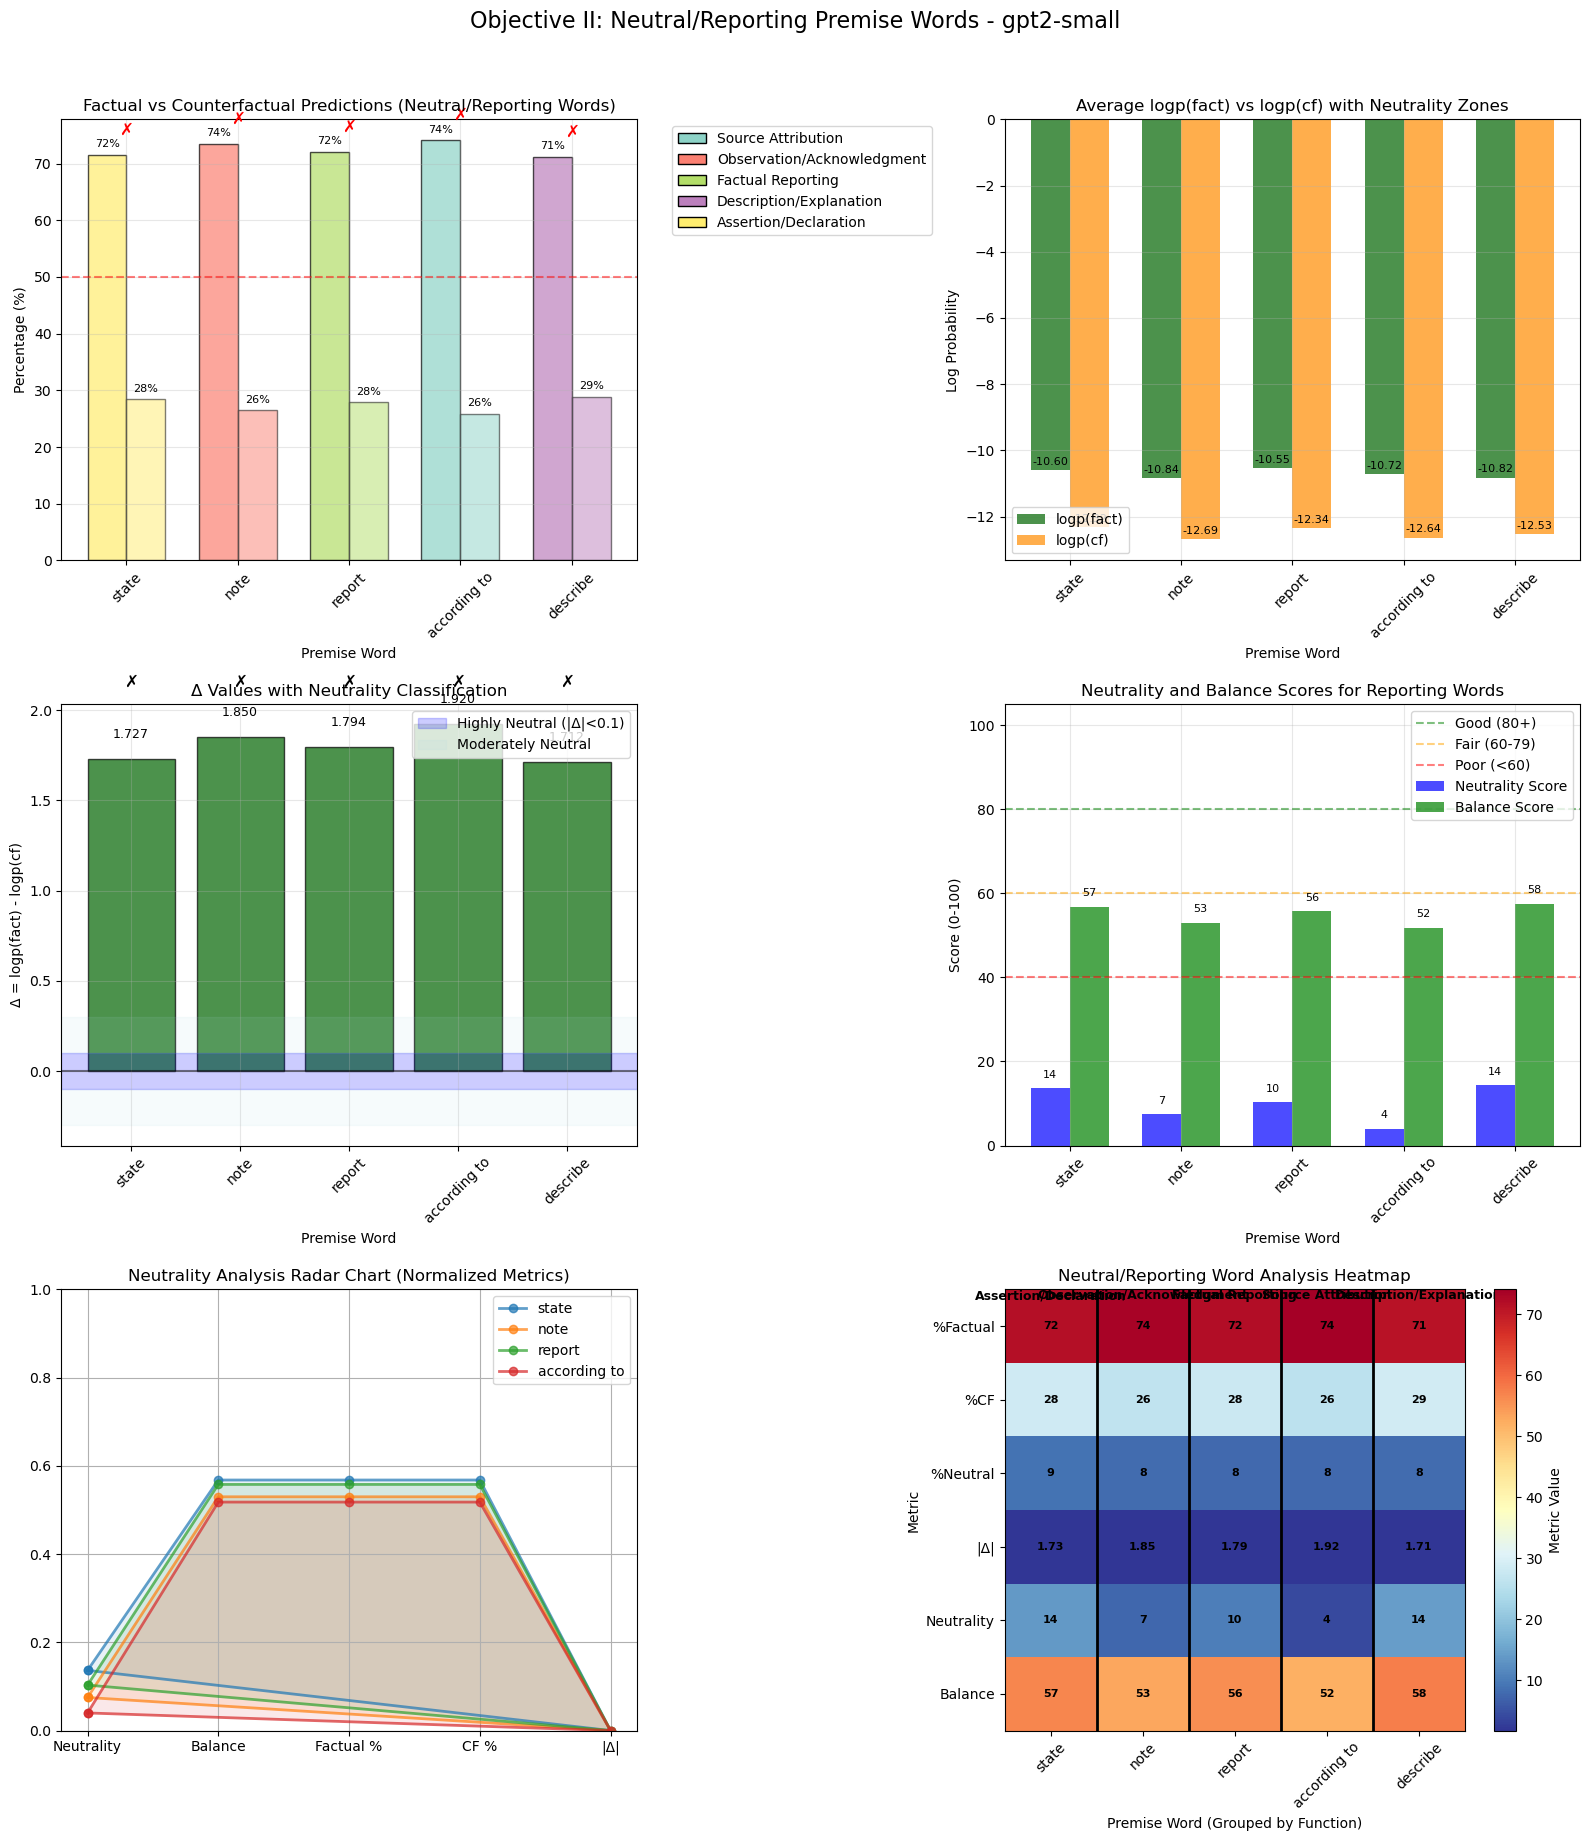

✗ Definitional results file not found at premise_words_results.json
✗ Verification results file not found at verification_premise_words_results.json
✗ Evaluation results file not found at evaluation_premise_words_results.json
✗ Hypothetical results file not found at hypothetical_premise_words_results.json

COMPREHENSIVE COMPARISON: ALL PREMISE WORD CATEGORIES

Word            Category                  %Factual     Δ            Expected        Bias      
-----------------------------------------------------------------------------------------------
according to    Neutral/Reporting         74.1         1.9201       Neutral         Factual   
describe        Neutral/Reporting         71.2         1.7120       Neutral         Factual   
note            Neutral/Reporting         73.5         1.8500       Neutral         Factual   
report          Neutral/Reporting         72.1         1.7938       Neutral         Factual   
state           Neutral/Reporting         71.6         1.7271     

In [12]:
# objective_II_neutral_reporting.ipynb

import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import gc
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

@dataclass
class NeutralPremiseWordResult:
    """Stores results for a single prompt with neutral/reporting premise word"""
    subject: str
    question: str
    premise_word: str
    counterfactual_statement: str
    factual_answer: str
    counterfactual_answer: str
    factual_tokens: List[int]
    counterfactual_tokens: List[int]
    factual_logp: float
    counterfactual_logp: float
    delta: float
    prediction: str  # "factual" or "counterfactual"
    prompt: str  # The full prompt used

class NeutralPremiseWordExperiment:
    def __init__(self, dataset_path: str, model_name: str = "gpt2-small"):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.model = None
        self.dataset = []
        self.results = []
        
        # Neutral/Reporting premise words to analyze
        self.premise_words = ['state', 'note', 'report', 'according to', 'describe']
        
        # Premise Word prompt template for Objective II
        self.premise_word_template = (
            "Answer the following question.\n"
            "Instruction: {PREMISE_WORD}\n"
            "Text: \"{CF}\"\n\n"
            "Question: {Q}\n"
            "Answer: "
        )
        
        # Categorization of premise words for analysis
        self.premise_word_categories = {
            'state': 'Neutral/Reporting',
            'note': 'Neutral/Reporting', 
            'report': 'Neutral/Reporting',
            'according to': 'Neutral/Reporting',
            'describe': 'Neutral/Reporting'
        }
        
        # Expected bias for each word (neutral words should be balanced/neutral)
        self.expected_bias = {
            'state': 'Neutral reporting of information',
            'note': 'Neutral observation/acknowledgment',
            'report': 'Neutral factual reporting',
            'according to': 'Neutral attribution/source reporting',
            'describe': 'Neutral description'
        }
        
        # Expected neutrality strength (on scale of 1-3)
        self.expected_neutrality_strength = {
            'state': 2,      # Moderate neutrality (formal reporting)
            'note': 2,       # Moderate neutrality (observation)
            'report': 3,     # Strong neutrality (factual reporting)
            'according to': 3, # Strong neutrality (source attribution)
            'describe': 2    # Moderate neutrality (description)
        }
        
        # Classification by function
        self.word_functions = {
            'state': 'Assertion/Declaration',
            'note': 'Observation/Acknowledgment',
            'report': 'Factual Reporting',
            'according to': 'Source Attribution',
            'describe': 'Description/Explanation'
        }
    
    def setup_model(self):
        """Initialize model"""
        try:
            self.clear_memory()
            device = "cuda" if torch.cuda.is_available() else "cpu"
            
            self.model = HookedTransformer.from_pretrained(
                self.model_name,
                device=device,
                torch_dtype=torch.float16 if "large" in self.model_name else None
            )
            
            self.model.eval()
            print(f"✓ {self.model_name} loaded successfully")
            return True
            
        except Exception as e:
            print(f"✗ Error loading {self.model_name}: {e}")
            return False
    
    def load_dataset(self):
        """Load and filter dataset"""
        try:
            with open(self.dataset_path, 'r') as f:
                self.dataset = json.load(f)
            
            print(f"✓ Dataset loaded: {len(self.dataset)} total prompts")
            return True
            
        except Exception as e:
            print(f"✗ Error loading dataset: {e}")
            return False
    
    def extract_counterfactual_statement(self, original_prompt: str, subject: str, target_new: str) -> str:
        """
        Extract or construct the counterfactual statement (CF) from the prompt
        """
        if ':' in original_prompt:
            parts = original_prompt.split(':', 1)
            if len(parts) > 1:
                statement_part = parts[1].strip()
                return statement_part
        
        return f"{subject} was created by {target_new}"
    
    def create_premise_word_prompt(self, premise_word: str, counterfactual_statement: str, question: str) -> str:
        """Create premise word prompt with the specified premise word"""
        return self.premise_word_template.format(
            PREMISE_WORD=premise_word,
            CF=counterfactual_statement,
            Q=question
        )
    
    def tokenize_answer(self, answer: str) -> List[int]:
        """Tokenize answer into token IDs"""
        tokens = self.model.tokenizer.encode(answer, add_special_tokens=False)
        return tokens
    
    def get_log_probabilities(self, prompt: str, target_tokens: List[int]) -> float:
        """
        Compute log probability of target tokens given prompt
        """
        # Tokenize prompt
        prompt_tokens = self.model.tokenizer.encode(prompt, add_special_tokens=False)
        
        # Combine prompt and target tokens
        all_tokens = prompt_tokens + target_tokens
        
        # Convert to tensor
        tokens_tensor = torch.tensor([all_tokens], device=self.model.cfg.device)
        
        with torch.no_grad():
            # Get logits for all positions
            logits = self.model(tokens_tensor)
            
            # Compute log probabilities using log_softmax
            log_probs = torch.log_softmax(logits, dim=-1)
            
            # Extract log probabilities for target tokens
            total_logp = 0.0
            
            for i, token_id in enumerate(target_tokens, start=len(prompt_tokens)):
                # i-1 because logits are shifted by 1 (predicting next token)
                token_logp = log_probs[0, i-1, token_id].item()
                total_logp += token_logp
        
        return total_logp
    
    def process_item_with_premise_word(self, item: Dict, premise_word: str) -> Optional[NeutralPremiseWordResult]:
        """Process a single dataset item with a specific premise word"""
        try:
            # Extract components
            question = item['question']
            factual_answer = item['target_true']
            counterfactual_answer = item['target_new']
            subject = item['subject']
            original_prompt = item['prompt']
            
            # Extract or construct counterfactual statement (CF)
            cf_statement = self.extract_counterfactual_statement(
                original_prompt, subject, counterfactual_answer
            )
            
            # Create premise word prompt
            prompt = self.create_premise_word_prompt(premise_word, cf_statement, question)
            
            # Tokenize answers
            factual_tokens = self.tokenize_answer(factual_answer)
            counterfactual_tokens = self.tokenize_answer(counterfactual_answer)
            
            # Get log probabilities
            factual_logp = self.get_log_probabilities(prompt, factual_tokens)
            counterfactual_logp = self.get_log_probabilities(prompt, counterfactual_tokens)
            
            # Compute delta
            delta = factual_logp - counterfactual_logp
            
            # Determine prediction
            prediction = "factual" if delta > 0 else "counterfactual"
            
            result = NeutralPremiseWordResult(
                subject=subject,
                question=question,
                premise_word=premise_word,
                counterfactual_statement=cf_statement,
                factual_answer=factual_answer,
                counterfactual_answer=counterfactual_answer,
                factual_tokens=factual_tokens,
                counterfactual_tokens=counterfactual_tokens,
                factual_logp=factual_logp,
                counterfactual_logp=counterfactual_logp,
                delta=delta,
                prediction=prediction,
                prompt=prompt
            )
            
            return result
            
        except Exception as e:
            print(f"Error processing item with premise word '{premise_word}': {e}")
            return None
    
    def clear_memory(self):
        """Clear GPU memory"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    def run_experiment(self, sample_size: Optional[int] = None):
        """Run the Neutral Premise Word experiment"""
        print(f"\n{'='*80}")
        print(f"OBJECTIVE II PART 5: NEUTRAL/REPORTING PREMISE WORDS")
        print(f"{'='*80}")
        print(f"Model: {self.model_name.upper()}")
        
        if not self.setup_model():
            return
        
        if not self.load_dataset():
            return
        
        # Process all items or sample
        all_items = self.dataset
        if sample_size:
            all_items = all_items[:sample_size]
        
        print(f"\nTesting {len(self.premise_words)} neutral/reporting premise words:")
        for i, word in enumerate(self.premise_words, 1):
            function = self.word_functions.get(word, "Unknown")
            print(f"  {i}. {word} ({function})")
        
        print(f"\nProcessing {len(all_items)} items for each premise word...")
        print(f"Total expected prompts: {len(self.premise_words) * len(all_items)}")
        
        # Process items for each premise word
        self.results = []
        for premise_word in tqdm(self.premise_words, desc="Premise words"):
            for item in tqdm(all_items, desc=f"  {premise_word}", leave=False):
                result = self.process_item_with_premise_word(item, premise_word)
                if result:
                    self.results.append(result)
        
        print(f"✓ Processed {len(self.results)} prompts successfully")
        
        # Analyze results
        self.analyze_results()
        
        return self.results
    
    def analyze_results(self):
        """Analyze and report results for all neutral/reporting premise words with detailed metrics"""
        if not self.results:
            print("No results to analyze")
            return
        
        print(f"\n{'='*100}")
        print("NEUTRAL/REPORTING PREMISE WORDS: DETAILED METRICS")
        print(f"{'='*100}")
        print("\nFormat for each premise word:")
        print("  logp(fact): average log probability of factual answer")
        print("  logp(cf):   average log probability of counterfactual answer")
        print("  Δ:          logp(fact) - logp(cf)")
        print("\nExpected Bias: Neutral/Reporting words should show balanced/neutral responses")
        print("  Ideal: Δ ≈ 0 (balanced between factual and counterfactual)")
        print("  Good: |Δ| < 0.3 (relatively neutral)")
        print("  Poor: |Δ| > 0.5 (strong bias)")
        
        # Dictionary to store aggregated results by premise word
        word_metrics = {}
        
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            
            if word_results:
                # Calculate metrics
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                counterfactual_pct = 100 - factual_pct
                
                # Calculate average log probabilities
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                
                # Calculate standard deviations
                std_factual_logp = np.std([r.factual_logp for r in word_results])
                std_counterfactual_logp = np.std([r.counterfactual_logp for r in word_results])
                std_delta = np.std([r.delta for r in word_results])
                
                # Calculate additional statistics
                median_factual_logp = np.median([r.factual_logp for r in word_results])
                median_counterfactual_logp = np.median([r.counterfactual_logp for r in word_results])
                median_delta = np.median([r.delta for r in word_results])
                
                # Calculate neutral zone metrics
                highly_neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.1)
                highly_neutral_pct = (highly_neutral_count / total) * 100
                
                neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.3)
                neutral_pct = (neutral_count / total) * 100
                
                biased_count = sum(1 for r in word_results if abs(r.delta) > 0.5)
                biased_pct = (biased_count / total) * 100
                
                # Calculate balance metrics
                balance_score = 100 - abs(factual_pct - 50) * 2  # 100 = perfectly balanced
                neutrality_score = 100 - abs(avg_delta) * 50     # 100 = perfectly neutral
                
                # Calculate expected neutrality match
                expected_neutral = self.expected_neutrality_strength[word] >= 2
                matches_expectation = abs(avg_delta) < 0.3 if expected_neutral else True
                expectation_match_pct = 100 if matches_expectation else 0
                
                # Classify neutrality level
                if abs(avg_delta) < 0.1:
                    neutrality_level = "Highly Neutral"
                    neutrality_class = "A"
                elif abs(avg_delta) < 0.3:
                    neutrality_level = "Moderately Neutral"
                    neutrality_class = "B"
                elif abs(avg_delta) < 0.5:
                    neutrality_level = "Slightly Biased"
                    neutrality_class = "C"
                else:
                    neutrality_level = "Strongly Biased"
                    neutrality_class = "D"
                
                # Store metrics
                word_metrics[word] = {
                    'count': total,
                    'factual_pct': factual_pct,
                    'counterfactual_pct': counterfactual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'std_factual_logp': std_factual_logp,
                    'std_counterfactual_logp': std_counterfactual_logp,
                    'std_delta': std_delta,
                    'median_factual_logp': median_factual_logp,
                    'median_counterfactual_logp': median_counterfactual_logp,
                    'median_delta': median_delta,
                    'highly_neutral_pct': highly_neutral_pct,
                    'neutral_pct': neutral_pct,
                    'biased_pct': biased_pct,
                    'balance_score': balance_score,
                    'neutrality_score': neutrality_score,
                    'expected_bias': self.expected_bias.get(word, 'Unknown'),
                    'word_function': self.word_functions.get(word, 'Unknown'),
                    'expected_neutrality': self.expected_neutrality_strength[word],
                    'matches_expectation': matches_expectation,
                    'expectation_match_pct': expectation_match_pct,
                    'neutrality_level': neutrality_level,
                    'neutrality_class': neutrality_class,
                    'neutrality_rating': '✓' if neutrality_class in ['A', 'B'] else '⚠' if neutrality_class == 'C' else '✗'
                }
        
        # Print detailed table for all premise words
        print(f"\n{'='*150}")
        print(f"{'Premise Word':<15} {'Count':<8} {'%Factual':<10} {'%CF':<10} {'logp(fact)':<15} {'logp(cf)':<15} {'Δ':<15} {'Neutral%':<12} {'Balance':<10} {'Neutrality':<12} {'Rating':<8}")
        print(f"{'':<15} {'':<8} {'':<10} {'':<10} {'(mean±std)':<15} {'(mean±std)':<15} {'(mean±std)':<15} {'(|Δ|<0.3)':<12} {'Score':<10} {'Score':<12} {'':<8}")
        print("-" * 150)
        
        for word, metrics in word_metrics.items():
            print(f"{word:<15} {metrics['count']:<8} {metrics['factual_pct']:<10.1f} "
                  f"{metrics['counterfactual_pct']:<10.1f} "
                  f"{metrics['avg_factual_logp']:7.4f}±{metrics['std_factual_logp']:<7.4f} "
                  f"{metrics['avg_counterfactual_logp']:7.4f}±{metrics['std_counterfactual_logp']:<7.4f} "
                  f"{metrics['avg_delta']:7.4f}±{metrics['std_delta']:<7.4f} "
                  f"{metrics['neutral_pct']:<12.1f} "
                  f"{metrics['balance_score']:<10.1f} "
                  f"{metrics['neutrality_score']:<12.1f} "
                  f"{metrics['neutrality_rating']:<8}")
        
        # Print individual premise word summaries
        print(f"\n{'='*80}")
        print("INDIVIDUAL PREMISE WORD SUMMARIES")
        print(f"{'='*80}")
        
        for word, metrics in word_metrics.items():
            print(f"\n{'='*60}")
            print(f"PREMISE WORD: {word.upper()}")
            print(f"{'='*60}")
            print(f"  Word Function: {metrics['word_function']}")
            print(f"  Number of prompts analyzed: {metrics['count']}")
            print(f"  Factual predictions: {metrics['factual_pct']:.1f}%")
            print(f"  Counterfactual predictions: {metrics['counterfactual_pct']:.1f}%")
            print(f"  Balance Score: {metrics['balance_score']:.1f}/100")
            print(f"\n  Neutrality Analysis:")
            print(f"    Highly neutral (|Δ| < 0.1): {metrics['highly_neutral_pct']:.1f}%")
            print(f"    Neutral (|Δ| < 0.3): {metrics['neutral_pct']:.1f}%")
            print(f"    Biased (|Δ| > 0.5): {metrics['biased_pct']:.1f}%")
            print(f"    Neutrality Score: {metrics['neutrality_score']:.1f}/100")
            print(f"    Neutrality Level: {metrics['neutrality_level']} ({metrics['neutrality_class']})")
            print(f"\n  Average Log Probabilities:")
            print(f"    logp(fact): {metrics['avg_factual_logp']:.4f} (std: {metrics['std_factual_logp']:.4f})")
            print(f"    logp(cf):   {metrics['avg_counterfactual_logp']:.4f} (std: {metrics['std_counterfactual_logp']:.4f})")
            print(f"    Δ:          {metrics['avg_delta']:.4f} (std: {metrics['std_delta']:.4f})")
            print(f"\n  Median Values:")
            print(f"    logp(fact): {metrics['median_factual_logp']:.4f}")
            print(f"    logp(cf):   {metrics['median_counterfactual_logp']:.4f}")
            print(f"    Δ:          {metrics['median_delta']:.4f}")
            print(f"\n  Expected Behavior: {self.expected_bias.get(word, 'Unknown')}")
            print(f"  Expected Neutrality: {'Strong' if metrics['expected_neutrality'] == 3 else 'Moderate' if metrics['expected_neutrality'] == 2 else 'Weak'}")
            print(f"  Matches Expectation: {'✓' if metrics['matches_expectation'] else '✗'}")
            
            # Detailed interpretation
            print(f"\n  Interpretation:")
            if metrics['neutrality_class'] == 'A':
                print(f"    ✓ EXCELLENT neutrality - Highly neutral as expected for reporting word")
            elif metrics['neutrality_class'] == 'B':
                print(f"    ✓ GOOD neutrality - Moderately neutral, appropriate for reporting")
            elif metrics['neutrality_class'] == 'C':
                print(f"    ⚠ FAIR neutrality - Somewhat biased, less neutral than expected")
            else:
                print(f"    ✗ POOR neutrality - Strongly biased, contrary to expectation")
            
            if abs(metrics['factual_pct'] - 50) < 10:
                print(f"    ✓ Good balance between factual and counterfactual predictions")
            elif abs(metrics['factual_pct'] - 50) < 20:
                print(f"    ⚠ Moderate imbalance in predictions")
            else:
                print(f"    ✗ Significant imbalance in predictions")
        
        # Summary statistics across all premise words
        print(f"\n{'='*80}")
        print("SUMMARY ACROSS ALL NEUTRAL/REPORTING PREMISE WORDS")
        print(f"{'='*80}")
        
        # Calculate averages across all premise words
        avg_factual_logp_all = np.mean([m['avg_factual_logp'] for m in word_metrics.values()])
        avg_counterfactual_logp_all = np.mean([m['avg_counterfactual_logp'] for m in word_metrics.values()])
        avg_delta_all = np.mean([m['avg_delta'] for m in word_metrics.values()])
        avg_factual_pct_all = np.mean([m['factual_pct'] for m in word_metrics.values()])
        avg_counterfactual_pct_all = np.mean([m['counterfactual_pct'] for m in word_metrics.values()])
        avg_neutral_pct_all = np.mean([m['neutral_pct'] for m in word_metrics.values()])
        avg_balance_score_all = np.mean([m['balance_score'] for m in word_metrics.values()])
        avg_neutrality_score_all = np.mean([m['neutrality_score'] for m in word_metrics.values()])
        
        # Calculate overall neutrality classification
        if abs(avg_delta_all) < 0.1:
            overall_neutrality = "Highly Neutral (Excellent)"
        elif abs(avg_delta_all) < 0.3:
            overall_neutrality = "Moderately Neutral (Good)"
        elif abs(avg_delta_all) < 0.5:
            overall_neutrality = "Slightly Biased (Fair)"
        else:
            overall_neutrality = "Strongly Biased (Poor)"
        
        print(f"\n  Average across all {len(word_metrics)} neutral/reporting premise words:")
        print(f"    logp(fact): {avg_factual_logp_all:.4f}")
        print(f"    logp(cf):   {avg_counterfactual_logp_all:.4f}")
        print(f"    Δ:          {avg_delta_all:.4f} ({overall_neutrality})")
        print(f"    % Factual:  {avg_factual_pct_all:.1f}%")
        print(f"    % Counterfactual: {avg_counterfactual_pct_all:.1f}%")
        print(f"    % Neutral (|Δ|<0.3): {avg_neutral_pct_all:.1f}%")
        print(f"    Average Balance Score: {avg_balance_score_all:.1f}/100")
        print(f"    Average Neutrality Score: {avg_neutrality_score_all:.1f}/100")
        
        # Check if neutral words work as expected
        neutral_word_count = sum(1 for m in word_metrics.values() if m['neutrality_class'] in ['A', 'B'])
        neutral_success_rate = neutral_word_count / len(word_metrics) * 100
        expectation_match_rate = sum(1 for m in word_metrics.values() if m['matches_expectation']) / len(word_metrics) * 100
        
        print(f"\n  Neutral Word Effectiveness:")
        print(f"    Words with good neutrality (A/B): {neutral_success_rate:.1f}%")
        print(f"    Words matching expectation: {expectation_match_rate:.1f}%")
        
        if neutral_success_rate > 80:
            print("    Conclusion: Neutral words show EXCELLENT neutrality as expected")
        elif neutral_success_rate > 60:
            print("    Conclusion: Neutral words show GOOD neutrality")
        elif neutral_success_rate > 40:
            print("    Conclusion: Neutral words show MODERATE neutrality")
        else:
            print("    Conclusion: Neutral words show POOR neutrality (unexpected)")
        
        # Ranking by neutrality (most neutral to most biased)
        print(f"\n{'='*80}")
        print("RANKING BY NEUTRALITY (Most Neutral to Most Biased)")
        print(f"{'='*80}")
        
        sorted_by_neutrality = sorted(word_metrics.items(), key=lambda x: abs(x[1]['avg_delta']))
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'|Δ|':<15} {'Δ':<15} {'Neutral%':<12} {'Balance':<10} {'Rating':<8}")
        print("-" * 80)
        
        for rank, (word, metrics) in enumerate(sorted_by_neutrality, 1):
            print(f"{rank:<6} {word:<15} {abs(metrics['avg_delta']):<15.4f} "
                  f"{metrics['avg_delta']:<15.4f} "
                  f"{metrics['neutral_pct']:<12.1f} "
                  f"{metrics['balance_score']:<10.1f} "
                  f"{metrics['neutrality_rating']:<8}")
        
        # Ranking by balance score
        print(f"\n{'='*80}")
        print("RANKING BY BALANCE SCORE (% Factual close to 50%)")
        print(f"{'='*80}")
        
        sorted_by_balance = sorted(word_metrics.items(), key=lambda x: x[1]['balance_score'], reverse=True)
        
        print(f"\n{'Rank':<6} {'Premise Word':<15} {'Balance':<15} {'%Factual':<12} {'%CF':<12} {'|Δ|':<12}")
        print("-" * 70)
        
        for rank, (word, metrics) in enumerate(sorted_by_balance, 1):
            print(f"{rank:<6} {word:<15} {metrics['balance_score']:<15.1f} "
                  f"{metrics['factual_pct']:<12.1f} "
                  f"{metrics['counterfactual_pct']:<12.1f} "
                  f"{abs(metrics['avg_delta']):<12.4f}")
        
        # Ranking by word function groups
        print(f"\n{'='*80}")
        print("ANALYSIS BY WORD FUNCTION")
        print(f"{'='*80}")
        
        # Group by function
        function_groups = {}
        for word, metrics in word_metrics.items():
            function = metrics['word_function']
            if function not in function_groups:
                function_groups[function] = []
            function_groups[function].append((word, metrics))
        
        print(f"\n{'Function':<25} {'Avg |Δ|':<12} {'Avg Neutral%':<15} {'Avg Balance':<15} {'Word Count':<12}")
        print("-" * 85)
        
        for function, words in function_groups.items():
            avg_abs_delta = np.mean([abs(m['avg_delta']) for _, m in words])
            avg_neutral_pct = np.mean([m['neutral_pct'] for _, m in words])
            avg_balance = np.mean([m['balance_score'] for _, m in words])
            word_count = len(words)
            
            # Determine function performance
            if avg_abs_delta < 0.2:
                performance = "Excellent"
            elif avg_abs_delta < 0.4:
                performance = "Good"
            elif avg_abs_delta < 0.6:
                performance = "Fair"
            else:
                performance = "Poor"
            
            print(f"{function:<25} {avg_abs_delta:<12.4f} {avg_neutral_pct:<15.1f} "
                  f"{avg_balance:<15.1f} {word_count:<12} {performance}")
        
        # Create visualizations
        self.plot_results(word_metrics)
        
        return word_metrics
    
    def plot_results(self, word_metrics):
        """Create visualizations of neutral/reporting premise word results"""
        if not word_metrics:
            return
        
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        axes = axes.flatten()
        
        # Prepare data for plots
        words = list(word_metrics.keys())
        factual_pcts = [word_metrics[w]['factual_pct'] for w in words]
        counterfactual_pcts = [word_metrics[w]['counterfactual_pct'] for w in words]
        avg_factual_logps = [word_metrics[w]['avg_factual_logp'] for w in words]
        avg_counterfactual_logps = [word_metrics[w]['avg_counterfactual_logp'] for w in words]
        avg_deltas = [word_metrics[w]['avg_delta'] for w in words]
        neutral_pcts = [word_metrics[w]['neutral_pct'] for w in words]
        balance_scores = [word_metrics[w]['balance_score'] for w in words]
        neutrality_scores = [word_metrics[w]['neutrality_score'] for w in words]
        word_functions = [word_metrics[w]['word_function'] for w in words]
        
        # Get unique functions for coloring
        unique_functions = list(set(word_functions))
        function_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_functions)))
        function_color_map = {func: function_colors[i] for i, func in enumerate(unique_functions)}
        
        # Plot 1: Factual vs Counterfactual percentages with balance indicator
        x = np.arange(len(words))
        width = 0.35
        
        # Color bars by word function
        fact_colors = [function_color_map[func] for func in word_functions]
        cf_colors = [function_color_map[func] for func in word_functions]
        
        axes[0].bar(x - width/2, factual_pcts, width, label='Factual', color=fact_colors, alpha=0.7, edgecolor='black')
        axes[0].bar(x + width/2, counterfactual_pcts, width, label='Counterfactual', color=cf_colors, alpha=0.5, edgecolor='black')
        axes[0].set_xlabel('Premise Word')
        axes[0].set_ylabel('Percentage (%)')
        axes[0].set_title('Factual vs Counterfactual Predictions (Neutral/Reporting Words)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(words, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Perfect Balance')
        
        # Add balance indicators
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            imbalance = abs(fact - 50)
            if imbalance < 10:
                marker = '✓'
                color = 'green'
            elif imbalance < 20:
                marker = '○'
                color = 'orange'
            else:
                marker = '✗'
                color = 'red'
            
            axes[0].text(i, max(fact, cf) + 3, marker, ha='center', va='bottom', fontsize=12, color=color)
        
        # Add percentage labels
        for i, (fact, cf) in enumerate(zip(factual_pcts, counterfactual_pcts)):
            axes[0].text(i - width/2, fact + 1, f'{fact:.0f}%', ha='center', va='bottom', fontsize=8)
            axes[0].text(i + width/2, cf + 1, f'{cf:.0f}%', ha='center', va='bottom', fontsize=8)
        
        # Create legend for word functions
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=function_color_map[func], edgecolor='black', label=func) 
                          for func in unique_functions]
        axes[0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: logp(fact) and logp(cf) comparison with neutrality zone
        x = np.arange(len(words))
        
        # Calculate distance from neutrality (Δ=0)
        distances_from_neutral = [abs(delta) for delta in avg_deltas]
        
        # Create color gradient based on neutrality
        norm = plt.Normalize(0, max(distances_from_neutral))
        cmap = plt.cm.RdYlGn_r
        bar_colors = [cmap(1 - norm(d)) for d in distances_from_neutral]  # Reverse colormap
        
        bars_fact = axes[1].bar(x - width/2, avg_factual_logps, width, label='logp(fact)', color='darkgreen', alpha=0.7)
        bars_cf = axes[1].bar(x + width/2, avg_counterfactual_logps, width, label='logp(cf)', color='darkorange', alpha=0.7)
        
        # Overlay neutrality indicator
        for i, delta in enumerate(avg_deltas):
            if abs(delta) < 0.1:
                axes[1].axvspan(i - 0.5, i + 0.5, alpha=0.1, color='blue', zorder=0)
            elif abs(delta) < 0.3:
                axes[1].axvspan(i - 0.5, i + 0.5, alpha=0.05, color='blue', zorder=0)
        
        axes[1].set_xlabel('Premise Word')
        axes[1].set_ylabel('Log Probability')
        axes[1].set_title('Average logp(fact) vs logp(cf) with Neutrality Zones')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(words, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, (fact_logp, cf_logp) in enumerate(zip(avg_factual_logps, avg_counterfactual_logps)):
            axes[1].text(i - width/2, fact_logp + 0.1, f'{fact_logp:.2f}', ha='center', va='bottom', fontsize=8)
            axes[1].text(i + width/2, cf_logp + 0.1, f'{cf_logp:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Δ values with neutrality bands
        colors = []
        for delta in avg_deltas:
            if abs(delta) < 0.1:
                colors.append('blue')  # Highly neutral
            elif abs(delta) < 0.3:
                colors.append('lightblue')  # Moderately neutral
            elif delta > 0.5:
                colors.append('darkgreen')  # Strong factual bias
            elif delta > 0.1:
                colors.append('lightgreen')  # Moderate factual bias
            elif delta < -0.5:
                colors.append('darkorange')  # Strong counterfactual bias
            else:
                colors.append('orange')  # Moderate counterfactual bias
        
        bars = axes[2].bar(words, avg_deltas, color=colors, alpha=0.7, edgecolor='black')
        axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[2].axhspan(-0.1, 0.1, alpha=0.2, color='blue', label='Highly Neutral (|Δ|<0.1)')
        axes[2].axhspan(-0.3, -0.1, alpha=0.1, color='lightblue', label='Moderately Neutral')
        axes[2].axhspan(0.1, 0.3, alpha=0.1, color='lightblue')
        axes[2].set_xlabel('Premise Word')
        axes[2].set_ylabel('Δ = logp(fact) - logp(cf)')
        axes[2].set_title('Δ Values with Neutrality Classification')
        axes[2].set_xticklabels(words, rotation=45)
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        # Add neutrality rating
        for i, (word, delta) in enumerate(zip(words, avg_deltas)):
            rating = word_metrics[word]['neutrality_rating']
            axes[2].text(i, max(avg_deltas) * 1.1 if max(avg_deltas) > 0 else 0.5, 
                        rating, ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        # Add Δ value labels
        for bar, delta in zip(bars, avg_deltas):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
                        f'{delta:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        # Plot 4: Neutrality and Balance Scores
        x = np.arange(len(words))
        width = 0.35
        
        bars_neutrality = axes[3].bar(x - width/2, neutrality_scores, width, color='blue', alpha=0.7, label='Neutrality Score')
        bars_balance = axes[3].bar(x + width/2, balance_scores, width, color='green', alpha=0.7, label='Balance Score')
        
        axes[3].axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Good (80+)')
        axes[3].axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Fair (60-79)')
        axes[3].axhline(y=40, color='red', linestyle='--', alpha=0.5, label='Poor (<60)')
        
        axes[3].set_xlabel('Premise Word')
        axes[3].set_ylabel('Score (0-100)')
        axes[3].set_title('Neutrality and Balance Scores for Reporting Words')
        axes[3].set_xticks(x)
        axes[3].set_xticklabels(words, rotation=45)
        axes[3].set_ylim([0, 105])
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        # Add score labels
        for i, (neutral_score, balance_score) in enumerate(zip(neutrality_scores, balance_scores)):
            axes[3].text(i - width/2, neutral_score + 2, f'{neutral_score:.0f}', ha='center', va='bottom', fontsize=8)
            axes[3].text(i + width/2, balance_score + 2, f'{balance_score:.0f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 5: Neutrality Analysis Radar Chart
        # Create radar chart for each word
        angles = np.linspace(0, 2 * np.pi, 5, endpoint=False).tolist()
        categories = ['Neutrality', 'Balance', 'Factual %', 'CF %', '|Δ|']
        
        # Normalize metrics for radar chart
        def normalize_metric(value, metric_type):
            if metric_type == 'Neutrality':
                return value / 100  # Already 0-100 scale
            elif metric_type == 'Balance':
                return value / 100  # Already 0-100 scale
            elif metric_type == 'Factual %':
                return 1 - abs(value - 50) / 50  # Closer to 50% is better
            elif metric_type == 'CF %':
                return 1 - abs(value - 50) / 50  # Closer to 50% is better
            elif metric_type == '|Δ|':
                return max(0, 1 - value / 1.0)  # Smaller |Δ| is better
        
        # Plot first 4 words on radar chart
        words_to_plot = min(4, len(words))
        for i in range(words_to_plot):
            word = words[i]
            metrics = word_metrics[word]
            
            values = [
                normalize_metric(metrics['neutrality_score'], 'Neutrality'),
                normalize_metric(metrics['balance_score'], 'Balance'),
                normalize_metric(metrics['factual_pct'], 'Factual %'),
                normalize_metric(metrics['counterfactual_pct'], 'CF %'),
                normalize_metric(abs(metrics['avg_delta']), '|Δ|')
            ]
            
            # Close the polygon
            values = values + [values[0]]
            angles_plot = angles + [angles[0]]
            
            axes[4].plot(angles_plot, values, 'o-', linewidth=2, label=word, alpha=0.7)
            axes[4].fill(angles_plot, values, alpha=0.1)
        
        axes[4].set_xticks(angles)
        axes[4].set_xticklabels(categories)
        axes[4].set_ylim([0, 1])
        axes[4].set_title('Neutrality Analysis Radar Chart (Normalized Metrics)')
        axes[4].grid(True)
        axes[4].legend()
        
        # Plot 6: Neutrality Heatmap with function grouping
        # Group words by function
        function_groups = {}
        for word in words:
            function = word_functions[words.index(word)]
            if function not in function_groups:
                function_groups[function] = []
            function_groups[function].append(word)
        
        # Create sorted word list by function
        sorted_words_by_function = []
        for function, word_list in function_groups.items():
            sorted_words_by_function.extend(sorted(word_list))
        
        # Reorder metrics based on function grouping
        idx_map = {word: i for i, word in enumerate(words)}
        sorted_indices = [idx_map[word] for word in sorted_words_by_function]
        
        metrics_for_heatmap = np.array([
            [factual_pcts[i] for i in sorted_indices],
            [counterfactual_pcts[i] for i in sorted_indices],
            [neutral_pcts[i] for i in sorted_indices],
            [abs(avg_deltas[i]) for i in sorted_indices],
            [neutrality_scores[i] for i in sorted_indices],
            [balance_scores[i] for i in sorted_indices]
        ])
        
        im = axes[5].imshow(metrics_for_heatmap, cmap='RdYlBu_r', aspect='auto')
        axes[5].set_xlabel('Premise Word (Grouped by Function)')
        axes[5].set_ylabel('Metric')
        axes[5].set_title('Neutral/Reporting Word Analysis Heatmap')
        axes[5].set_xticks(range(len(sorted_words_by_function)))
        axes[5].set_xticklabels(sorted_words_by_function, rotation=45)
        axes[5].set_yticks(range(6))
        axes[5].set_yticklabels(['%Factual', '%CF', '%Neutral', '|Δ|', 'Neutrality', 'Balance'])
        
        # Add function group separators
        current_idx = 0
        for function, word_list in function_groups.items():
            group_size = len(word_list)
            if current_idx > 0:
                axes[5].axvline(x=current_idx - 0.5, color='black', linewidth=2)
            axes[5].text(current_idx + group_size/2 - 0.5, -0.5, function, 
                        ha='center', va='top', fontsize=9, fontweight='bold')
            current_idx += group_size
        
        # Add text annotations
        for i in range(6):
            for j in range(len(sorted_words_by_function)):
                if i == 3:  # |Δ|
                    text = f'{metrics_for_heatmap[i, j]:.2f}'
                elif i == 4 or i == 5:  # Scores
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                else:  # Percentages
                    text = f'{metrics_for_heatmap[i, j]:.0f}'
                
                # Choose text color based on metric value
                if i in [2, 4, 5]:  # Higher is better (neutrality metrics)
                    color = 'white' if metrics_for_heatmap[i, j] > 60 else 'black'
                elif i == 3:  # Lower is better (|Δ|)
                    color = 'white' if metrics_for_heatmap[i, j] < 0.3 else 'black'
                else:  # Balance metrics
                    color = 'white' if abs(metrics_for_heatmap[i, j] - 50) < 20 else 'black'
                
                axes[5].text(j, i, text, ha='center', va='center', 
                           color=color, fontsize=8, fontweight='bold')
        
        plt.colorbar(im, ax=axes[5], label='Metric Value')
        
        plt.suptitle(f'Objective II: Neutral/Reporting Premise Words - {self.model_name}', 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_neutral_words_{self.model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def compare_with_all_categories(self, 
                                   definitional_results_path: str = "premise_words_results.json",
                                   verification_results_path: str = "verification_premise_words_results.json",
                                   evaluation_results_path: str = "evaluation_premise_words_results.json",
                                   hypothetical_results_path: str = "hypothetical_premise_words_results.json"):
        """Compare neutral words with all other categories from previous experiments"""
        all_categories = {}
        
        try:
            # Load definitional results
            with open(definitional_results_path, 'r') as f:
                definitional_data = json.load(f)
            
            if 'premise_word_summary' in definitional_data:
                for word, stats in definitional_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Definitional/Override',
                        'expected_bias': 'Accept CF',
                        'bias_direction': 'Negative'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Definitional results file not found at {definitional_results_path}")
        
        try:
            # Load verification results
            with open(verification_results_path, 'r') as f:
                verification_data = json.load(f)
            
            if 'premise_word_summary' in verification_data:
                for word, stats in verification_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Verification/Fact-Checking',
                        'expected_bias': 'Factual',
                        'bias_direction': 'Positive'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Verification results file not found at {verification_results_path}")
        
        try:
            # Load evaluation results
            with open(evaluation_results_path, 'r') as f:
                evaluation_data = json.load(f)
            
            if 'premise_word_summary' in evaluation_data:
                for word, stats in evaluation_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Evaluation/Analysis',
                        'expected_bias': 'Neutral',
                        'bias_direction': 'Near Zero'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Evaluation results file not found at {evaluation_results_path}")
        
        try:
            # Load hypothetical results
            with open(hypothetical_results_path, 'r') as f:
                hypothetical_data = json.load(f)
            
            if 'premise_word_summary' in hypothetical_data:
                for word, stats in hypothetical_data['premise_word_summary'].items():
                    all_categories[word] = {
                        'factual_pct': stats.get('factual_percent', 0),
                        'avg_delta': stats.get('avg_delta', 0),
                        'category': 'Hypothetical/Fictional',
                        'expected_bias': 'Counterfactual',
                        'bias_direction': 'Negative'
                    }
                    
        except FileNotFoundError:
            print(f"✗ Hypothetical results file not found at {hypothetical_results_path}")
        
        # Add neutral results
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_delta = np.mean([r.delta for r in word_results])
                
                all_categories[word] = {
                    'factual_pct': factual_pct,
                    'avg_delta': avg_delta,
                    'category': 'Neutral/Reporting',
                    'expected_bias': 'Neutral',
                    'bias_direction': 'Near Zero'
                }
        
        if len(all_categories) < 5:  # Need reasonable amount of data
            print("Not enough data for comparison")
            return
        
        print(f"\n{'='*80}")
        print("COMPREHENSIVE COMPARISON: ALL PREMISE WORD CATEGORIES")
        print(f"{'='*80}")
        
        # Print comparison table
        print(f"\n{'Word':<15} {'Category':<25} {'%Factual':<12} {'Δ':<12} {'Expected':<15} {'Bias':<10}")
        print("-" * 95)
        
        for word in sorted(all_categories.keys()):
            data = all_categories.get(word)
            if data:
                # Determine actual bias direction
                if data['avg_delta'] > 0.3:
                    actual_bias = "Factual"
                elif data['avg_delta'] < -0.3:
                    actual_bias = "Counterfactual"
                elif abs(data['avg_delta']) < 0.1:
                    actual_bias = "Neutral"
                else:
                    actual_bias = "Slight"
                
                print(f"{word:<15} {data['category']:<25} {data['factual_pct']:<12.1f} "
                      f"{data['avg_delta']:<12.4f} {data.get('expected_bias', 'Unknown'):<15} {actual_bias:<10}")
        
        # Calculate category averages
        category_stats = {}
        for word, data in all_categories.items():
            category = data['category']
            if category not in category_stats:
                category_stats[category] = {'factual_pcts': [], 'deltas': [], 'words': [], 'abs_deltas': []}
            category_stats[category]['factual_pcts'].append(data['factual_pct'])
            category_stats[category]['deltas'].append(data['avg_delta'])
            category_stats[category]['abs_deltas'].append(abs(data['avg_delta']))
            category_stats[category]['words'].append(word)
        
        print(f"\n{'='*80}")
        print("CATEGORY SUMMARY (Ranked by Neutrality - Lowest |Δ|)")
        print(f"{'='*80}")
        print(f"\n{'Category':<25} {'Avg |Δ|':<12} {'Avg Δ':<12} {'Avg %Factual':<15} {'Neutrality':<15}")
        print("-" * 85)
        
        # Sort categories by |Δ| (most neutral to most biased)
        sorted_categories = sorted(
            [(cat, np.mean(stats['abs_deltas'])) for cat, stats in category_stats.items()],
            key=lambda x: x[1]
        )
        
        for category, avg_abs_delta in sorted_categories:
            stats = category_stats[category]
            avg_factual = np.mean(stats['factual_pcts'])
            avg_delta = np.mean(stats['deltas'])
            word_count = len(stats['words'])
            
            # Determine neutrality rating
            if avg_abs_delta < 0.1:
                neutrality = "Highly Neutral"
                rating = "A"
            elif avg_abs_delta < 0.3:
                neutrality = "Moderately Neutral"
                rating = "B"
            elif avg_abs_delta < 0.5:
                neutrality = "Slightly Biased"
                rating = "C"
            else:
                neutrality = "Strongly Biased"
                rating = "D"
            
            # Check if category meets expectation
            expected = data.get('expected_bias', 'Unknown')
            if expected == 'Neutral':
                meets_expectation = avg_abs_delta < 0.3
            elif expected == 'Factual':
                meets_expectation = avg_delta > 0
            elif expected == 'Counterfactual' or expected == 'Accept CF':
                meets_expectation = avg_delta < 0
            else:
                meets_expectation = None
            
            match_symbol = "✓" if meets_expectation else "✗" if meets_expectation is False else "?"
            
            print(f"{category:<25} {avg_abs_delta:<12.4f} {avg_delta:<12.4f} "
                  f"{avg_factual:<15.1f} {neutrality} ({rating}) {match_symbol}")
        
        # Create comprehensive category comparison visualization
        self.plot_comprehensive_category_comparison(category_stats)
        
        return category_stats
    
    def plot_comprehensive_category_comparison(self, category_stats):
        """Create visualization comparing all premise word categories comprehensively"""
        if not category_stats or len(category_stats) < 2:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        # Prepare data
        categories = list(category_stats.keys())
        avg_factual_pcts = [np.mean(stats['factual_pcts']) for stats in category_stats.values()]
        avg_deltas = [np.mean(stats['deltas']) for stats in category_stats.values()]
        avg_abs_deltas = [np.mean(stats['abs_deltas']) for stats in category_stats.values()]
        
        # Color mapping by category
        category_colors = {
            'Definitional/Override': 'blue',
            'Verification/Fact-Checking': 'green',
            'Evaluation/Analysis': 'purple',
            'Hypothetical/Fictional': 'orange',
            'Neutral/Reporting': 'gray'
        }
        
        colors = [category_colors.get(cat, 'black') for cat in categories]
        
        # Plot 1: Average %Factual by category
        x = np.arange(len(categories))
        bars1 = axes[0].bar(x, avg_factual_pcts, color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Category')
        axes[0].set_ylabel('Average % Factual')
        axes[0].set_title('Average % Factual Predictions by Category')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([cat.split('/')[0] for cat in categories], rotation=45)
        axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (Perfect Balance)')
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].legend()
        
        # Add value labels
        for bar, pct in zip(bars1, avg_factual_pcts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: Average Δ by category
        bars2 = axes[1].bar(x, avg_deltas, color=colors, alpha=0.7, edgecolor='black')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Add expected bias zones
        axes[1].axhspan(-1, -0.1, alpha=0.1, color='orange', label='CF Bias Expected')
        axes[1].axhspan(-0.1, 0.1, alpha=0.1, color='gray', label='Neutral Expected')
        axes[1].axhspan(0.1, 1, alpha=0.1, color='green', label='Factual Bias Expected')
        
        axes[1].set_xlabel('Category')
        axes[1].set_ylabel('Average Δ')
        axes[1].set_title('Average Δ by Category with Expected Zones')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels([cat.split('/')[0] for cat in categories], rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].legend()
        
        # Add value labels
        for bar, delta in zip(bars2, avg_deltas):
            axes[1].text(bar.get_x() + bar.get_width()/2, delta + (0.1 if delta > 0 else -0.3),
                        f'{delta:.3f}', ha='center', va='bottom' if delta > 0 else 'top', fontsize=9)
        
        # Plot 3: Average |Δ| (Neutrality) by category
        bars3 = axes[2].bar(x, avg_abs_deltas, color=colors, alpha=0.7, edgecolor='black')
        
        # Add neutrality thresholds
        axes[2].axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Highly Neutral (<0.1)')
        axes[2].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Moderately Neutral (<0.3)')
        axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Biased (>0.5)')
        
        axes[2].set_xlabel('Category')
        axes[2].set_ylabel('Average |Δ|')
        axes[2].set_title('Neutrality (|Δ|) by Category (Lower = More Neutral)')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels([cat.split('/')[0] for cat in categories], rotation=45)
        axes[2].grid(True, alpha=0.3, axis='y')
        axes[2].legend()
        
        # Add value labels and neutrality rating
        for i, (bar, abs_delta) in enumerate(zip(bars3, avg_abs_deltas)):
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{abs_delta:.3f}', ha='center', va='bottom', fontsize=9)
            
            # Add neutrality rating
            if abs_delta < 0.1:
                rating = 'A'
                color = 'green'
            elif abs_delta < 0.3:
                rating = 'B'
                color = 'orange'
            elif abs_delta < 0.5:
                rating = 'C'
                color = 'red'
            else:
                rating = 'D'
                color = 'darkred'
            
            axes[2].text(i, abs_delta * 1.1, rating, ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=color)
        
        # Plot 4: Category Performance Scatter Plot
        scatter = axes[3].scatter(avg_factual_pcts, avg_abs_deltas, 
                                  c=range(len(categories)), cmap='tab10', s=200, alpha=0.8, edgecolors='black')
        
        # Add category labels
        for i, cat in enumerate(categories):
            axes[3].text(avg_factual_pcts[i], avg_abs_deltas[i], cat.split('/')[0], 
                        fontsize=9, ha='center', va='bottom')
        
        # Add ideal zones
        axes[3].axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Ideal Balance (50%)')
        axes[3].axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Highly Neutral')
        
        axes[3].set_xlabel('Average % Factual')
        axes[3].set_ylabel('Average |Δ| (Neutrality)')
        axes[3].set_title('Category Performance: Balance vs Neutrality')
        axes[3].grid(True, alpha=0.3)
        axes[3].legend()
        
        # Add performance quadrants
        axes[3].text(25, 0.05, 'Counterfactual & Neutral', ha='center', va='center', 
                    fontsize=8, alpha=0.5, rotation=45)
        axes[3].text(75, 0.05, 'Factual & Neutral', ha='center', va='center', 
                    fontsize=8, alpha=0.5, rotation=45)
        axes[3].text(25, 0.5, 'Counterfactual & Biased', ha='center', va='center', 
                    fontsize=8, alpha=0.5, rotation=45)
        axes[3].text(75, 0.5, 'Factual & Biased', ha='center', va='center', 
                    fontsize=8, alpha=0.5, rotation=45)
        
        plt.suptitle(f'Objective II: Comprehensive Premise Word Category Analysis - {self.model_name}', 
                    fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig(f'objective_II_comprehensive_category_analysis_{self.model_name}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_results(self, output_path: str = "neutral_premise_words_results.json"):
        """Save detailed results to JSON file"""
        if not self.results:
            print("No results to save")
            return
        
        # Convert results to serializable format
        serializable_results = []
        for result in self.results:
            serializable_results.append({
                'subject': result.subject,
                'question': result.question,
                'premise_word': result.premise_word,
                'counterfactual_statement': result.counterfactual_statement,
                'factual_answer': result.factual_answer,
                'counterfactual_answer': result.counterfactual_answer,
                'factual_tokens': result.factual_tokens,
                'counterfactual_tokens': result.counterfactual_tokens,
                'factual_logp': float(result.factual_logp),
                'counterfactual_logp': float(result.counterfactual_logp),
                'delta': float(result.delta),
                'prediction': result.prediction,
                'prompt': result.prompt
            })
        
        # Calculate summary statistics by premise word
        word_summary = {}
        for word in self.premise_words:
            word_results = [r for r in self.results if r.premise_word == word]
            if word_results:
                total = len(word_results)
                factual_count = sum(1 for r in word_results if r.prediction == "factual")
                factual_pct = (factual_count / total) * 100
                avg_factual_logp = np.mean([r.factual_logp for r in word_results])
                avg_counterfactual_logp = np.mean([r.counterfactual_logp for r in word_results])
                avg_delta = np.mean([r.delta for r in word_results])
                delta_std = np.std([r.delta for r in word_results])
                
                # Calculate neutrality metrics
                neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.3)
                neutral_pct = (neutral_count / total) * 100
                highly_neutral_count = sum(1 for r in word_results if abs(r.delta) < 0.1)
                highly_neutral_pct = (highly_neutral_count / total) * 100
                balance_score = 100 - abs(factual_pct - 50) * 2
                neutrality_score = 100 - abs(avg_delta) * 50
                
                # Determine neutrality classification
                if abs(avg_delta) < 0.1:
                    neutrality_level = "Highly Neutral"
                    neutrality_class = "A"
                elif abs(avg_delta) < 0.3:
                    neutrality_level = "Moderately Neutral"
                    neutrality_class = "B"
                elif abs(avg_delta) < 0.5:
                    neutrality_level = "Slightly Biased"
                    neutrality_class = "C"
                else:
                    neutrality_level = "Strongly Biased"
                    neutrality_class = "D"
                
                word_summary[word] = {
                    'count': total,
                    'factual_percent': factual_pct,
                    'counterfactual_percent': 100 - factual_pct,
                    'avg_factual_logp': avg_factual_logp,
                    'avg_counterfactual_logp': avg_counterfactual_logp,
                    'avg_delta': avg_delta,
                    'delta_std': delta_std,
                    'neutral_percent': neutral_pct,
                    'highly_neutral_percent': highly_neutral_pct,
                    'balance_score': balance_score,
                    'neutrality_score': neutrality_score,
                    'neutrality_level': neutrality_level,
                    'neutrality_class': neutrality_class,
                    'word_function': self.word_functions.get(word, 'Unknown'),
                    'expected_neutrality': self.expected_neutrality_strength[word],
                    'neutrality_meets_expectation': neutrality_class in ['A', 'B']
                }
        
        # Calculate overall summary
        total = len(self.results)
        factual_count = sum(1 for r in self.results if r.prediction == "factual")
        factual_percent = (factual_count / total) * 100
        neutral_count = sum(1 for r in self.results if abs(r.delta) < 0.3)
        neutral_percent = (neutral_count / total) * 100
        avg_delta_all = np.mean([r.delta for r in self.results])
        avg_abs_delta_all = np.mean([abs(r.delta) for r in self.results])
        balance_score_all = 100 - abs(factual_percent - 50) * 2
        neutrality_score_all = 100 - avg_abs_delta_all * 50
        
        # Calculate overall neutrality classification
        if avg_abs_delta_all < 0.1:
            overall_neutrality = "Highly Neutral (A)"
        elif avg_abs_delta_all < 0.3:
            overall_neutrality = "Moderately Neutral (B)"
        elif avg_abs_delta_all < 0.5:
            overall_neutrality = "Slightly Biased (C)"
        else:
            overall_neutrality = "Strongly Biased (D)"
        
        # Calculate ranking
        ranking_by_neutrality = sorted(
            [(word, stats['neutrality_score']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_balance = sorted(
            [(word, stats['balance_score']) for word, stats in word_summary.items()],
            key=lambda x: x[1],
            reverse=True
        )
        
        ranking_by_delta = sorted(
            [(word, stats['avg_delta']) for word, stats in word_summary.items()],
            key=lambda x: x[1]
        )
        
        # Save to file
        with open(output_path, 'w') as f:
            json.dump({
                'model': self.model_name,
                'total_prompts': len(self.results),
                'objective': 'II - Effect of Neutral/Reporting Premise Words',
                'prompt_template': self.premise_word_template,
                'premise_words_tested': self.premise_words,
                'category': 'Neutral/Reporting',
                'results': serializable_results,
                'summary': {
                    'factual_percent': factual_percent,
                    'counterfactual_percent': 100 - factual_percent,
                    'neutral_percent': neutral_percent,
                    'avg_factual_logp': np.mean([r.factual_logp for r in self.results]),
                    'avg_counterfactual_logp': np.mean([r.counterfactual_logp for r in self.results]),
                    'avg_delta': avg_delta_all,
                    'avg_abs_delta': avg_abs_delta_all,
                    'delta_std': np.std([r.delta for r in self.results]),
                    'balance_score': balance_score_all,
                    'neutrality_score': neutrality_score_all,
                    'overall_neutrality': overall_neutrality,
                    'ranking_by_neutrality': ranking_by_neutrality,
                    'ranking_by_balance': ranking_by_balance,
                    'ranking_by_delta': ranking_by_delta,
                    'most_neutral_word': ranking_by_neutrality[0][0] if ranking_by_neutrality else None,
                    'most_balanced_word': ranking_by_balance[0][0] if ranking_by_balance else None,
                    'neutrality_success_rate': sum(1 for stats in word_summary.values() if stats['neutrality_class'] in ['A', 'B']) / len(word_summary) * 100
                },
                'premise_word_summary': word_summary
            }, f, indent=2)
        
        print(f"✓ Results saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATH = "../Data/gpt2_with_questions_merged.json"
    MODEL_NAME = "gpt2-small"
    SAMPLE_SIZE = 1000  # Number of items to process (set to None for full dataset)
    
    print(f"{'='*80}")
    print("OBJECTIVE II PART 5: NEUTRAL/REPORTING PREMISE WORDS")
    print(f"{'='*80}")
    print(f"Testing premise words: state, note, report, according to, describe")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
    print(f"{'='*80}")
    
    # Create and run experiment
    experiment = NeutralPremiseWordExperiment(DATASET_PATH, MODEL_NAME)
    
    # Run the experiment
    results = experiment.run_experiment(sample_size=SAMPLE_SIZE)
    
    if results:
        # Save results
        # experiment.save_results()
        
        # Compare with all other categories if available
        experiment.compare_with_all_categories(
            definitional_results_path="premise_words_results.json",
            verification_results_path="verification_premise_words_results.json",
            evaluation_results_path="evaluation_premise_words_results.json",
            hypothetical_results_path="hypothetical_premise_words_results.json"
        )
        
        # Final summary
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETE")
        print(f"{'='*80}")
        print(f"Total prompts processed: {len(results)}")
        print(f"Neutral/Reporting premise words tested: {', '.join(experiment.premise_words)}")
        print(f"\nKey Metrics Collected for Each Premise Word:")
        print("  - % factual: Percentage of factual predictions")
        print("  - % counterfactual: Percentage of counterfactual predictions")
        print("  - logp(fact): Average log probability of factual answer")
        print("  - logp(cf): Average log probability of counterfactual answer")
        print("  - Δ: logp(fact) - logp(cf)")
        print("  - % Neutral: Percentage of prompts with |Δ| < 0.3")
        print("  - Balance Score: 0-100 (higher = more balanced predictions)")
        print("  - Neutrality Score: 0-100 (higher = more neutral)")
        print(f"\nExpected Behavior: Neutral/Reporting words should show balanced, neutral responses (|Δ| ≈ 0)")
        print(f"\nResults saved to:")
        print("  - neutral_premise_words_results.json")
        print("  - objective_II_neutral_words_{model_name}.png (visualizations)")
        print("  - objective_II_comprehensive_category_analysis_{model_name}.png (category comparison)")